# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [97]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


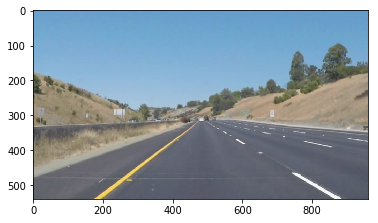

In [98]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [110]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    sum_right_line = 0
    sum_left_line = 0
    num_right_line = 0
    num_left_line = 0
    avg_right_line = 0
    sum_right_xposition = 0
    sum_right_yposition = 0
    
    right_array = []
    del_right_array = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #define acceptable slope range
            middle_num = 0.65 
            range_for_middle_num = 0.2
            
            #I try to get the slope value
            slope = ((y2-y1)/(x2-x1))
            #then seperate the left/right ones and abandon horizontal lines or over range lines
            if slope > 0 : #possible right lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('right slope is ',((y2-y1)/(x2-x1)))
                    sum_right_line += slope
                    num_right_line += 1
                    right_array.append([x1,y1])
                    right_array.append([x2,y2])
                    sum_right_xposition += (x1 + x2)
                    sum_right_yposition += (y1 + y2)
            else: #possible left lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('left slope is ',((y2-y1)/(x2-x1)))
                    sum_left_line += slope
                    num_left_line += 1
                    
            
            #print('slope is ',((y2-y1)/(x2-x1)))
            
    #average slope calculation
    avg_slope_right = sum_right_line/num_right_line
    avg_slope_left = sum_left_line/num_left_line
    avg_right_xposition = sum_right_xposition/(num_right_line*2)
    avg_right_yposition = sum_right_yposition/(num_right_line*2)
    print('avg right position is x=',avg_right_xposition,' y= ',avg_right_yposition )
    right_array.sort(reverse=True)
    
    # for further delete some irrelevant points 
    for i in range(len(right_array)):
        print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (abs(right_array[i][0]-avg_right_xposition) > 250) or (abs(right_array[i][1]-avg_right_yposition) > 250): 
            del_right_array.append(i)

    
        
    for i in range(0,len(right_array)-2,1):
        print ('new i is ', i,'i0= ',right_array[i][0],' i+1 0=',right_array[i+1][0],' i+2 0=',right_array[i+2][0] )
        if (right_array[i][1]-right_array[i+1][1]<-3) and (right_array[i][1]-right_array[i+2][1]<-3):
            del_right_array.append(i+1)
            del_right_array.append(i+2)
        
    print('del array is ', del_right_array)
    new_del_right_array = sorted(set(del_right_array))
    print('del array is ', new_del_right_array)
    del_right_array.sort()
    for v in reversed(new_del_right_array):
        print('v is ', v)
        del right_array[v]
    
    print('avg right slope is ',avg_slope_right)
    print('avg left slope is ',avg_slope_left)
    print('right array is ', right_array)
    x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
    last_index_right_array = len(right_array)-1
    cv2.line(img,(x1_position,right_array[0][1]),(right_array[last_index_right_array][0],right_array[last_index_right_array][1]),[0,255,0],10)        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

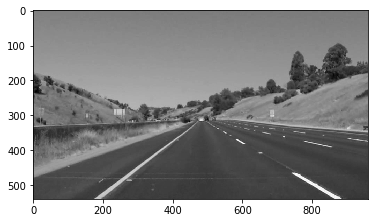

In [111]:
import os
os.listdir("test_images/")
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

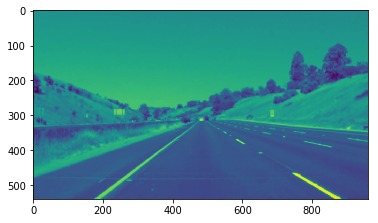

In [112]:
blur_gray = gaussian_blur(gray, 5)
plt.imshow(blur_gray)

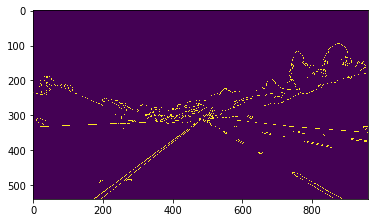

In [113]:
edges = canny(blur_gray, 10, 180)
plt.imshow(edges)

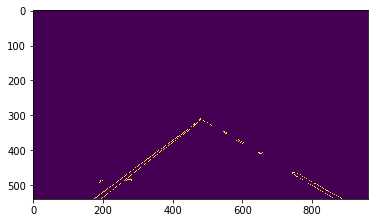

In [114]:
# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(60,imshape[0]),(480, 310), (480, 310), (imshape[1]-60,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)

avg right position is x= 656.625  y=  427.416666667
i is  0  right array i0 is  884 i1 is  538
i is  1  right array i0 is  881 i1 is  535
i is  2  right array i0 is  876 i1 is  532
i is  3  right array i0 is  870 i1 is  531
i is  4  right array i0 is  863 i1 is  539
i is  5  right array i0 is  863 i1 is  538
i is  6  right array i0 is  853 i1 is  522
i is  7  right array i0 is  852 i1 is  520
i is  8  right array i0 is  832 i1 is  510
i is  9  right array i0 is  831 i1 is  508
i is  10  right array i0 is  818 i1 is  511
i is  11  right array i0 is  818 i1 is  502
i is  12  right array i0 is  817 i1 is  500
i is  13  right array i0 is  816 i1 is  500
i is  14  right array i0 is  809 i1 is  507
i is  15  right array i0 is  780 i1 is  479
i is  16  right array i0 is  769 i1 is  474
i is  17  right array i0 is  768 i1 is  473
i is  18  right array i0 is  768 i1 is  472
i is  19  right array i0 is  757 i1 is  466
i is  20  right array i0 is  750 i1 is  472
i is  21  right array i0 is  743 i

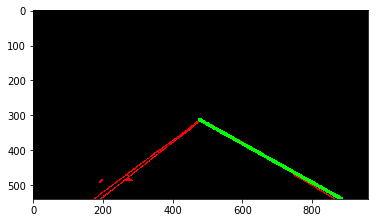

In [115]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines)

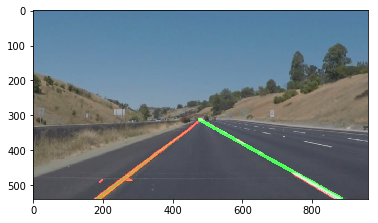

In [116]:
mix = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(mix)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [117]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [118]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [119]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    vertices = np.array([[(60,imshape[0]),(480, 300), (480, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 3
    max_line_gap = 7
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [120]:
white_output = 'segment_lines_right_finish.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

avg right position is x= 675.357142857  y=  425.607142857
i is  0  right array i0 is  870 i1 is  538
i is  1  right array i0 is  869 i1 is  538
i is  2  right array i0 is  850 i1 is  526
i is  3  right array i0 is  848 i1 is  538
i is  4  right array i0 is  846 i1 is  538
i is  5  right array i0 is  840 i1 is  533
i is  6  right array i0 is  838 i1 is  533
i is  7  right array i0 is  812 i1 is  517
i is  8  right array i0 is  799 i1 is  497
i is  9  right array i0 is  786 i1 is  499
i is  10  right array i0 is  786 i1 is  489
i is  11  right array i0 is  773 i1 is  491
i is  12  right array i0 is  770 i1 is  490
i is  13  right array i0 is  763 i1 is  486
i is  14  right array i0 is  759 i1 is  482
i is  15  right array i0 is  749 i1 is  477
i is  16  right array i0 is  741 i1 is  462
i is  17  right array i0 is  739 i1 is  469
i is  18  right array i0 is  721 i1 is  459
i is  19  right array i0 is  709 i1 is  450
i is  20  right array i0 is  706 i1 is  439
i is  21  right array i0 is 



  0%|          | 0/222 [00:00<?, ?it/s]

avg right position is x= 675.357142857  y=  425.607142857
i is  0  right array i0 is  870 i1 is  538
i is  1  right array i0 is  869 i1 is  538
i is  2  right array i0 is  850 i1 is  526
i is  3  right array i0 is  848 i1 is  538
i is  4  right array i0 is  846 i1 is  538
i is  5  right array i0 is  840 i1 is  533
i is  6  right array i0 is  838 i1 is  533
i is  7  right array i0 is  812 i1 is  517
i is  8  right array i0 is  799 i1 is  497
i is  9  right array i0 is  786 i1 is  499
i is  10  right array i0 is  786 i1 is  489
i is  11  right array i0 is  773 i1 is  491
i is  12  right array i0 is  770 i1 is  490
i is  13  right array i0 is  763 i1 is  486
i is  14  right array i0 is  759 i1 is  482
i is  15  right array i0 is  749 i1 is  477
i is  16  right array i0 is  741 i1 is  462
i is  17  right array i0 is  739 i1 is  469
i is  18  right array i0 is  721 i1 is  459
i is  19  right array i0 is  709 i1 is  450
i is  20  right array i0 is  706 i1 is  439
i is  21  right array i0 is 

 right array i0 is  653 i1 is  407
i is  30  right array i0 is  647 i1 is  404
i is  31  right array i0 is  647 i1 is  403
i is  32  right array i0 is  639 i1 is  399
i is  33  right array i0 is  635 i1 is  397
i is  34  right array i0 is  631 i1 is  394
i is  35  right array i0 is  628 i1 is  399
i is  36  right array i0 is  627 i1 is  392
i is  37  right array i0 is  618 i1 is  387
i is  38  right array i0 is  611 i1 is  388
i is  39  right array i0 is  607 i1 is  386
i is  40  right array i0 is  606 i1 is  385
i is  41  right array i0 is  585



  0%|          | 1/222 [00:00<00:55,  3.95it/s]

 i1 is  372
i is  42  right array i0 is  583 i1 is  366
i is  43  right array i0 is  583 i1 is  365
i is  44  right array i0 is  579 i1 is  364
i is  45  right array i0 is  578 i1 is  362
i is  46  right array i0 is  575 i1 is  366
i is  47  right array i0 is  571 i1 is  358
i is  48  right array i0 is  559 i1 is  351
i is  49  right array i0 is  558 i1 is  350
i is  50  right array i0 is  550 i1 is  345
i is  51  right array i0 is  538 i1 is  339
i is  52  right array i0 is  507 i1 is  320
i is  53  right array i0 is  493 i1 is  315
i is  54  right array i0 is  483 i1 is  304
i is  55  right array i0 is  478 i1 is  304
new i is  0 i0=  870  i+1 0= 869  i+2 0= 850
new i is  1 i0=  869  i+1 0= 850  i+2 0= 848
new i is  2 i0=  850  i+1 0= 848  i+2 0= 846
new i is  3 i0=  848  i+1 0= 846  i+2 0= 840
new i is  4 i0=  846  i+1 0= 840  i+2 0= 838
new i is  5 i0=  840  i+1 0= 838  i+2 0= 812
new i is  6 i0=  838  i+1 0= 812  i+2 0= 799
new i is  7 i0=  812  i+1 0= 799  i+2 0= 786
new i is  8 



  1%|          | 2/222 [00:00<01:15,  2.90it/s]

 25  right array i0 is  746 i1 is  465
i is  26  right array i0 is  733 i1 is  457
i is  27  right array i0 is  733 i1 is  456
i is  28  right array i0 is  732 i1 is  455
i is  29  right array i0 is  730 i1 is  455
i is  30  right array i0 is  727 i1 is  452
i is  31  right array i0 is  721 i1 is  459
i is  32  right array i0 is  720 i1 is  457
i is  33  right array i0 is  715 i1 is  446
i is  34  right array i0 is  710 i1 is  443
i is  35  right array i0 is  709 i1 is  441
i is  36  right array i0 is  702 i1 is  437
i is  37  right array i0 is  700 i1 is  437
i is  38  right array i0 is  689 i1 is  429
i is  39  right array i0 is  685 i1 is  428
i is  40  right array i0 is  667 i1 is  417
i is  41  right array i0 is  666 i1 is  415
i is  42  right array i0 is  657 i1 is  418
i is  43  right array i0 is  653 i1 is  407
i is  44  right array i0 is  646 i1 is  403
i is  45  right array i0 is  626 i1 is  391
i is  46  right array i0 is  616 i1 is  385
i is  47  right array i0 is  608 i1 i



  1%|▏         | 3/222 [00:01<01:10,  3.09it/s]

  2%|▏         | 4/222 [00:01<01:04,  3.40it/s]

489  i+1 0= 486  i+2 0= 481
new i is  22 i0=  486  i+1 0= 481  i+2 0= 480
new i is  23 i0=  481  i+1 0= 480  i+2 0= 478
del array is  [3, 4, 15, 16]
del array is  [3, 4, 15, 16]
v is  16
v is  15
v is  4
v is  3
avg right slope is  0.612686777086
avg left slope is  -0.718597559535
right array is  [[868, 539], [868, 538], [859, 533], [840, 521], [832, 516], [805, 513], [801, 509], [792, 493], [755, 479], [751, 478], [708, 442], [707, 441], [673, 419], [556, 349], [491, 308], [490, 310], [490, 309], [489, 305], [486, 310], [481, 301], [480, 301], [478, 306]]
avg right position is x= 684.566666667  y=  438.933333333
i is  0  right array i0 is  868 i1 is  539
i is  1  right array i0 is  868 i1 is  538
i is  2  right array i0 is  847 i1 is  538
i is  3  right array i0 is  846 i1 is  524
i is  4  right array i0 is  844 i1 is  536
i is  5  right array i0 is  831 i1 is  529
i is  6  right array i0 is  829 i1 is  515
i is  7  right array i0 is  827 i1 is  525
i is  8  right array i0 is  822 i1 

avg right position is x= 686.5625  y=  436.65625
i is  0  right array i0 is  870 i1 is  538
i is  1  right array i0 is  849 i1 is  538
i is  2  right array i0 is  848 i1 is  538
i is  3  right array i0 is  844 i1 is  536
i is  4  right array i0 is  842 i1 is  534
i is  5  right array i0 is  838 i1 is  532
i is  6  right array i0 is  796 i1 is  505
i is  7  right array i0 is  782 i1 is  496
i is  8  right array i0 is  781 i1 is  496
i is  9  right array i0 is  777 i1 is  493
i is  10  right array i0 is  774 i1 is  492
i is  11  right array i0 is  762 i1 is  485
i is  12  right array i0 is  760 i1 is  473
i is  13  right array i0 is  758 i1 is  481
i is  14  right array i0 is  753 i1 is  479
i is  15  right array i0 is  749 i1 is  475
i is  16  right array i0 is  738 i1 is  468
i is  17  right array i0 is  728 i1 is  463
i is  18  right array i0 is  724 i1 is  459
i is  19  right array i0 is  714 i1 is  454
i is  20  right array i0 is  699 i1 is  434
i is  21  right array i0 is  684 i1 i



  2%|▏         | 5/222 [00:01<00:59,  3.63it/s]

 i+2 0= 699
new i is  19 i0=  714  i+1 0= 699  i+2 0= 684
new i is  20 i0=  699  i+1 0= 684  i+2 0= 558
new i is  21 i0=  684  i+1 0= 558  i+2 0= 541
new i is  22 i0=  558  i+1 0= 541  i+2 0= 496
new i is  23 i0=  541  i+1 0= 496  i+2 0= 486
new i is  24 i0=  496  i+1 0= 486  i+2 0= 482
new i is  25 i0=  486  i+1 0= 482  i+2 0= 477
new i is  26 i0=  482  i+1 0= 477  i+2 0= 473
new i is  27 i0=  477  i+1 0= 473  i+2 0= 470
new i is  28 i0=  473  i+1 0= 470  i+2 0= 460
new i is  29 i0=  470  i+1 0= 460  i+2 0= 457
del array is  [13, 14, 28, 29, 30, 31]
del array is  [13, 14, 28, 29, 30, 31]
v is  31
v is  30
v is  29
v is  28
v is  14
v is  13
avg right slope is  0.594635211585
avg left slope is  -0.701904416368
right array is  [[870, 538], [849, 538], [848, 538], [844, 536], [842, 534], [838, 532], [796, 505], [782, 496], [781, 496], [777, 493], [774, 492], [762, 485], [760, 473], [749, 475], [738, 468], [728, 463], [724, 459], [714, 454], [699, 434], [684, 427], [558, 350], [541, 341],



  3%|▎         | 6/222 [00:01<01:06,  3.24it/s]

9 i0=  832  i+1 0= 831  i+2 0= 816
new i is  10 i0=  831  i+1 0= 816  i+2 0= 807
new i is  11 i0=  816  i+1 0= 807  i+2 0= 804
new i is  12 i0=  807  i+1 0= 804  i+2 0= 791
new i is  13 i0=  804  i+1 0= 791  i+2 0= 787
new i is  14 i0=  791  i+1 0= 787  i+2 0= 769
new i is  15 i0=  787  i+1 0= 769  i+2 0= 767
new i is  16 i0=  769  i+1 0= 767  i+2 0= 756
new i is  17 i0=  767  i+1 0= 756  i+2 0= 752
new i is  18 i0=  756  i+1 0= 752  i+2 0= 745
new i is  19 i0=  752  i+1 0= 745  i+2 0= 742
new i is  20 i0=  745  i+1 0= 742  i+2 0= 689
new i is  21 i0=  742  i+1 0= 689  i+2 0= 680
new i is  22 i0=  689  i+1 0= 680  i+2 0= 646
new i is  23 i0=  680  i+1 0= 646  i+2 0= 640
new i is  24 i0=  646  i+1 0= 640  i+2 0= 629
new i is  25 i0=  640  i+1 0= 629  i+2 0= 604
new i is  26 i0=  629  i+1 0= 604  i+2 0= 600
new i is  27 i0=  604  i+1 0= 600  i+2 0= 587
new i is  28 i0=  600  i+1 0= 587  i+2 0= 580
new i is  29 i0=  587  i+1 0= 580  i+2 0= 572
new i is  30 i0=  580  i+1 0= 572  i+2 0= 562



  3%|▎         | 7/222 [00:02<01:06,  3.21it/s]

 870  i+2 0= 870
new i is  1 i0=  870  i+1 0= 870  i+2 0= 857
new i is  2 i0=  870  i+1 0= 857  i+2 0= 848
new i is  3 i0=  857  i+1 0= 848  i+2 0= 847
new i is  4 i0=  848  i+1 0= 847  i+2 0= 844
new i is  5 i0=  847  i+1 0= 844  i+2 0= 840
new i is  6 i0=  844  i+1 0= 840  i+2 0= 838
new i is  7 i0=  840  i+1 0= 838  i+2 0= 832
new i is  8 i0=  838  i+1 0= 832  i+2 0= 826
new i is  9 i0=  832  i+1 0= 826  i+2 0= 810
new i is  10 i0=  826  i+1 0= 810  i+2 0= 784
new i is  11 i0=  810  i+1 0= 784  i+2 0= 781
new i is  12 i0=  784  i+1 0= 781  i+2 0= 780
new i is  13 i0=  781  i+1 0= 780  i+2 0= 778
new i is  14 i0=  780  i+1 0= 778  i+2 0= 777
new i is  15 i0=  778  i+1 0= 777  i+2 0= 756
new i is  16 i0=  777  i+1 0= 756  i+2 0= 741
new i is  17 i0=  756  i+1 0= 741  i+2 0= 740
new i is  18 i0=  741  i+1 0= 740  i+2 0= 737
new i is  19 i0=  740  i+1 0= 737  i+2 0= 734
new i is  20 i0=  737  i+1 0= 734  i+2 0= 730
new i is  21 i0=  734  i+1 0= 730  i+2 0= 725
new i is  22 i0=  730  i+1



  4%|▎         | 8/222 [00:02<01:15,  2.84it/s]

 654
new i is  11 i0=  705  i+1 0= 654  i+2 0= 650
new i is  12 i0=  654  i+1 0= 650  i+2 0= 622
new i is  13 i0=  650  i+1 0= 622  i+2 0= 619
new i is  14 i0=  622  i+1 0= 619  i+2 0= 618
new i is  15 i0=  619  i+1 0= 618  i+2 0= 587
new i is  16 i0=  618  i+1 0= 587  i+2 0= 586
new i is  17 i0=  587  i+1 0= 586  i+2 0= 580
new i is  18 i0=  586  i+1 0= 580  i+2 0= 567
new i is  19 i0=  580  i+1 0= 567  i+2 0= 563
new i is  20 i0=  567  i+1 0= 563  i+2 0= 520
new i is  21 i0=  563  i+1 0= 520  i+2 0= 507
new i is  22 i0=  520  i+1 0= 507  i+2 0= 494
new i is  23 i0=  507  i+1 0= 494  i+2 0= 494
new i is  24 i0=  494  i+1 0= 494  i+2 0= 482
new i is  25 i0=  494  i+1 0= 482  i+2 0= 478
new i is  26 i0=  482  i+1 0= 478  i+2 0= 477
new i is  27 i0=  478  i+1 0= 477  i+2 0= 473
new i is  28 i0=  477  i+1 0= 473  i+2 0= 235
new i is  29 i0=  473  i+1 0= 235  i+2 0= 234
new i is  30 i0=  235  i+1 0= 234  i+2 0= 229
new i is  31 i0=  234  i+1 0= 229  i+2 0= 227
del array is  [0, 1, 30, 31, 



  4%|▍         | 9/222 [00:03<01:44,  2.04it/s]

 i+1 0= 549  i+2 0= 536
new i is  93 i0=  549  i+1 0= 536  i+2 0= 530
new i is  94 i0=  536  i+1 0= 530  i+2 0= 518
new i is  95 i0=  530  i+1 0= 518  i+2 0= 514
new i is  96 i0=  518  i+1 0= 514  i+2 0= 509
new i is  97 i0=  514  i+1 0= 509  i+2 0= 492
new i is  98 i0=  509  i+1 0= 492  i+2 0= 486
new i is  99 i0=  492  i+1 0= 486  i+2 0= 485
new i is  100 i0=  486  i+1 0= 485  i+2 0= 484
new i is  101 i0=  485  i+1 0= 484  i+2 0= 482
new i is  102 i0=  484  i+1 0= 482  i+2 0= 482
new i is  103 i0=  482  i+1 0= 482  i+2 0= 481
new i is  104 i0=  482  i+1 0= 481  i+2 0= 479
new i is  105 i0=  481  i+1 0= 479  i+2 0= 478
new i is  106 i0=  479  i+1 0= 478  i+2 0= 474
new i is  107 i0=  478  i+1 0= 474  i+2 0= 472
new i is  108 i0=  474  i+1 0= 472  i+2 0= 465
new i is  109 i0=  472  i+1 0= 465  i+2 0= 462
new i is  110 i0=  465  i+1 0= 462  i+2 0= 445
new i is  111 i0=  462  i+1 0= 445  i+2 0= 440
new i is  112 i0=  445  i+1 0= 440  i+2 0= 361
new i is  113 i0=  440  i+1 0= 361  i+2 0= 



  5%|▍         | 10/222 [00:03<01:37,  2.17it/s]

631 i1 is  405
i is  35  right array i0 is  621 i1 is  391
i is  36  right array i0 is  619 i1 is  397
i is  37  right array i0 is  610 i1 is  390
i is  38  right array i0 is  604 i1 is  386
i is  39  right array i0 is  591 i1 is  379
i is  40  right array i0 is  580 i1 is  367
i is  41  right array i0 is  576 i1 is  363
i is  42  right array i0 is  564 i1 is  360
i is  43  right array i0 is  557 i1 is  357
i is  44  right array i0 is  529 i1 is  338
i is  45  right array i0 is  514 i1 is  326
i is  46  right array i0 is  505 i1 is  319
i is  47  right array i0 is  501 i1 is  312
i is  48  right array i0 is  498 i1 is  311
i is  49  right array i0 is  491 i1 is  312
i is  50  right array i0 is  489 i1 is  306
i is  51  right array i0 is  489 i1 is  305
i is  52  right array i0 is  484 i1 is  315
i is  53  right array i0 is  483 i1 is  304
i is  54  right array i0 is  480 i1 is  302
i is  55  right array i0 is  479 i1 is  311
i is  56  right array i0 is  477 i1 is  303
i is  57  right a



  5%|▍         | 11/222 [00:04<02:00,  1.76it/s]


i is  51  right array i0 is  694 i1 is  438
i is  52  right array i0 is  690 i1 is  437
i is  53  right array i0 is  682 i1 is  431
i is  54  right array i0 is  680 i1 is  439
i is  55  right array i0 is  680 i1 is  431
i is  56  right array i0 is  679 i1 is  429
i is  57  right array i0 is  675 i1 is  428
i is  58  right array i0 is  665 i1 is  422
i is  59  right array i0 is  664 i1 is  420
i is  60  right array i0 is  654 i1 is  414
i is  61  right array i0 is  647 i1 is  411
i is  62  right array i0 is  644 i1 is  408
i is  63  right array i0 is  634 i1 is  403
i is  64  right array i0 is  612 i1 is  388
i is  65  right array i0 is  608 i1 is  387
i is  66  right array i0 is  593 i1 is  376
i is  67  right array i0 is  589 i1 is  375
i is  68  right array i0 is  564 i1 is  358
i is  69  right array i0 is  536 i1 is  342
i is  70  right array i0 is  530 i1 is  341
i is  71  right array i0 is  525 i1 is  334
i is  72  right array i0 is  523 i1 is  338
i is  73  right array i0 is  50

 right array i0 is  754 i1 is  488
i is  33  right array i0 is  746 i1 is  483
i is  34  right array i0 is  742 i1 is  479
i is  35  right array i0 is  733 i1 is  465
i is  36  right array i0 is  722 i1 is  457
i is  37  right array i0 is  715 i1 is  454
i is  38  right array i0 is  712 i1 is  460
i is  39  right array i0 is  712 i1 is  451
i is  40  right array i0 is  710 i1 is  451
i is  41  right array i0 is  708 i1 is  449
i is  42  right array i0 is  704 i1 is  456
i is  43  right array i0 is  704 i1 is  446
i is  44  right array i0 is  702 i1 is  455
i is  45  right array i0 is  691 i1 is  438
i is  46  right array i0 is  688 i1 is  446
i is  47  right array i0 is  687 i1 is  436
i is  48  right array i0 is  680 i1 is  433
i is  49  right array i0 is  677 i1 is  430
i is  50  right array i0 is  671 i1 is  426
i is  51  right array i0 is  669 i1 is  426
i is  52  right array i0 is  659 i1 is  426
i is  53  right array i0 is  655 i1 is  425
i is  54  right array i0 is  649 i1 is  4



  5%|▌         | 12/222 [00:05<02:07,  1.65it/s]

  6%|▌         | 13/222 [00:05<01:47,  1.94it/s]

449  i+2 0= 408
new i is  97 i0=  449  i+1 0= 408  i+2 0= 404
new i is  98 i0=  408  i+1 0= 404  i+2 0= 279
new i is  99 i0=  404  i+1 0= 279  i+2 0= 273
del array is  [98, 99, 100, 101, 16, 17, 58, 59, 92, 93, 93, 94, 96, 97, 98, 99, 100, 101]
del array is  [16, 17, 58, 59, 92, 93, 94, 96, 97, 98, 99, 100, 101]
v is  101
v is  100
v is  99
v is  98
v is  97
v is  96
v is  94
v is  93
v is  92
v is  59
v is  58
v is  17
v is  16
avg right slope is  0.587686321669
avg left slope is  -0.684516538364
right array is  [[856, 539], [854, 537], [845, 531], [838, 528], [836, 526], [834, 538], [833, 524], [826, 521], [823, 532], [823, 518], [821, 518], [820, 517], [818, 516], [818, 515], [810, 511], [809, 509], [802, 505], [801, 518], [800, 504], [792, 500], [790, 511], [790, 498], [787, 496], [780, 492], [779, 504], [777, 490], [773, 489], [770, 497], [762, 481], [758, 480], [754, 488], [746, 483], [742, 479], [733, 465], [722, 457], [715, 454], [712, 460], [712, 451], [710, 451], [708, 449], 



  6%|▋         | 14/222 [00:05<01:26,  2.42it/s]


i is  3  right array i0 is  848 i1 is  533
i is  4  right array i0 is  843 i1 is  531
i is  5  right array i0 is  836 i1 is  526
i is  6  right array i0 is  833 i1 is  538
i is  7  right array i0 is  833 i1 is  524
i is  8  right array i0 is  830 i1 is  523
i is  9  right array i0 is  826 i1 is  520
i is  10  right array i0 is  810 i1 is  524
i is  11  right array i0 is  809 i1 is  511
i is  12  right array i0 is  667 i1 is  431
i is  13  right array i0 is  663 i1 is  420
i is  14  right array i0 is  660 i1 is  425
i is  15  right array i0 is  657 i1 is  417
i is  16  right array i0 is  625 i1 is  403
i is  17  right array i0 is  624 i1 is  401
i is  18  right array i0 is  620 i1 is  398
i is  19  right array i0 is  618 i1 is  398
i is  20  right array i0 is  612 i1 is  394
i is  21  right array i0 is  608 i1 is  390
i is  22  right array i0 is  606 i1 is  390
i is  23  right array i0 is  578 i1 is  367
i is  24  right array i0 is  577 i1 is  365
i is  25  right array i0 is  574 i1 is



  7%|▋         | 15/222 [00:06<01:33,  2.20it/s]

751 i1 is  474
i is  27  right array i0 is  751 i1 is  473
i is  28  right array i0 is  749 i1 is  482
i is  29  right array i0 is  746 i1 is  480
i is  30  right array i0 is  746 i1 is  470
i is  31  right array i0 is  741 i1 is  467
i is  32  right array i0 is  736 i1 is  475
i is  33  right array i0 is  735 i1 is  463
i is  34  right array i0 is  727 i1 is  469
i is  35  right array i0 is  723 i1 is  465
i is  36  right array i0 is  723 i1 is  456
i is  37  right array i0 is  720 i1 is  454
i is  38  right array i0 is  716 i1 is  451
i is  39  right array i0 is  714 i1 is  451
i is  40  right array i0 is  711 i1 is  448
i is  41  right array i0 is  708 i1 is  447
i is  42  right array i0 is  704 i1 is  454
i is  43  right array i0 is  703 i1 is  452
i is  44  right array i0 is  687 i1 is  434
i is  45  right array i0 is  686 i1 is  442
i is  46  right array i0 is  685 i1 is  432
i is  47  right array i0 is  684 i1 is  431
i is  48  right array i0 is  682 i1 is  438
i is  49  right a



  7%|▋         | 16/222 [00:06<01:24,  2.45it/s]

  i+1 0= 656  i+2 0= 656
new i is  13 i0=  656  i+1 0= 656  i+2 0= 644
new i is  14 i0=  656  i+1 0= 644  i+2 0= 632
new i is  15 i0=  644  i+1 0= 632  i+2 0= 513
new i is  16 i0=  632  i+1 0= 513  i+2 0= 490
new i is  17 i0=  513  i+1 0= 490  i+2 0= 478
new i is  18 i0=  490  i+1 0= 478  i+2 0= 443
new i is  19 i0=  478  i+1 0= 443  i+2 0= 440
del array is  [4, 5, 20, 21]
del array is  [4, 5, 20, 21]
v is  21
v is  20
v is  5
v is  4
avg right slope is  0.634941598258
avg left slope is  -0.691994703345
right array is  [[859, 539], [859, 538], [851, 533], [842, 529], [830, 534], [818, 527], [767, 494], [694, 444], [677, 426], [670, 420], [664, 424], [656, 420], [656, 419], [644, 412], [632, 404], [513, 322], [490, 307], [478, 303]]
avg right position is x= 684.555555556  y=  436.296296296
i is  0  right array i0 is  860 i1 is  538
i is  1  right array i0 is  859 i1 is  539
i is  2  right array i0 is  859 i1 is  538
i is  3  right array i0 is  850 i1 is  532
i is  4  right array i0 is  



  8%|▊         | 17/222 [00:06<01:11,  2.89it/s]

 i0=  768  i+1 0= 764  i+2 0= 761
new i is  16 i0=  764  i+1 0= 761  i+2 0= 751
new i is  17 i0=  761  i+1 0= 751  i+2 0= 749
new i is  18 i0=  751  i+1 0= 749  i+2 0= 742
new i is  19 i0=  749  i+1 0= 742  i+2 0= 734
new i is  20 i0=  742  i+1 0= 734  i+2 0= 734
new i is  21 i0=  734  i+1 0= 734  i+2 0= 732
new i is  22 i0=  734  i+1 0= 732  i+2 0= 729
new i is  23 i0=  732  i+1 0= 729  i+2 0= 711
new i is  24 i0=  729  i+1 0= 711  i+2 0= 701
new i is  25 i0=  711  i+1 0= 701  i+2 0= 690
new i is  26 i0=  701  i+1 0= 690  i+2 0= 688
new i is  27 i0=  690  i+1 0= 688  i+2 0= 685
new i is  28 i0=  688  i+1 0= 685  i+2 0= 674
new i is  29 i0=  685  i+1 0= 674  i+2 0= 659
new i is  30 i0=  674  i+1 0= 659  i+2 0= 638
new i is  31 i0=  659  i+1 0= 638  i+2 0= 635
new i is  32 i0=  638  i+1 0= 635  i+2 0= 632
new i is  33 i0=  635  i+1 0= 632  i+2 0= 628
new i is  34 i0=  632  i+1 0= 628  i+2 0= 628
new i is  35 i0=  628  i+1 0= 628  i+2 0= 616
new i is  36 i0=  628  i+1 0= 616  i+2 0= 612




  8%|▊         | 18/222 [00:07<01:12,  2.83it/s]

 663  i+2 0= 660
new i is  19 i0=  663  i+1 0= 660  i+2 0= 655
new i is  20 i0=  660  i+1 0= 655  i+2 0= 642
new i is  21 i0=  655  i+1 0= 642  i+2 0= 640
new i is  22 i0=  642  i+1 0= 640  i+2 0= 636
new i is  23 i0=  640  i+1 0= 636  i+2 0= 636
new i is  24 i0=  636  i+1 0= 636  i+2 0= 623
new i is  25 i0=  636  i+1 0= 623  i+2 0= 605
new i is  26 i0=  623  i+1 0= 605  i+2 0= 591
new i is  27 i0=  605  i+1 0= 591  i+2 0= 587
new i is  28 i0=  591  i+1 0= 587  i+2 0= 586
new i is  29 i0=  587  i+1 0= 586  i+2 0= 567
new i is  30 i0=  586  i+1 0= 567  i+2 0= 557
new i is  31 i0=  567  i+1 0= 557  i+2 0= 553
new i is  32 i0=  557  i+1 0= 553  i+2 0= 545
new i is  33 i0=  553  i+1 0= 545  i+2 0= 544
new i is  34 i0=  545  i+1 0= 544  i+2 0= 536
new i is  35 i0=  544  i+1 0= 536  i+2 0= 532
new i is  36 i0=  536  i+1 0= 532  i+2 0= 531
new i is  37 i0=  532  i+1 0= 531  i+2 0= 523
new i is  38 i0=  531  i+1 0= 523  i+2 0= 519
new i is  39 i0=  523  i+1 0= 519  i+2 0= 519
new i is  40 i0= 



  9%|▊         | 19/222 [00:07<01:28,  2.30it/s]

i is  50  right array i0 is  684 i1 is  430
i is  51  right array i0 is  682 i1 is  438
i is  52  right array i0 is  682 i1 is  437
i is  53  right array i0 is  676 i1 is  434
i is  54  right array i0 is  676 i1 is  433
i is  55  right array i0 is  673 i1 is  423
i is  56  right array i0 is  655 i1 is  420
i is  57  right array i0 is  655 i1 is  413
i is  58  right array i0 is  650 i1 is  410
i is  59  right array i0 is  647 i1 is  407
i is  60  right array i0 is  645 i1 is  407
i is  61  right array i0 is  640 i1 is  409
i is  62  right array i0 is  640 i1 is  404
i is  63  right array i0 is  639 i1 is  402
i is  64  right array i0 is  636 i1 is  407
i is  65  right array i0 is  636 i1 is  401
i is  66  right array i0 is  636 i1 is  400
i is  67  right array i0 is  621 i1 is  391
i is  68  right array i0 is  619 i1 is  391
i is  69  right array i0 is  594 i1 is  380
i is  70  right array i0 is  587 i1 is  369
i is  71  right array i0 is  578 i1 is  368
i is  72  right array i0 is  577



  9%|▉         | 20/222 [00:08<01:23,  2.41it/s]

  9%|▉         | 21/222 [00:08<01:12,  2.77it/s]

 512 i1 is  323
i is  17  right array i0 is  492 i1 is  314
i is  18  right array i0 is  489 i1 is  306
i is  19  right array i0 is  488 i1 is  308
i is  20  right array i0 is  485 i1 is  304
i is  21  right array i0 is  482 i1 is  305
i is  22  right array i0 is  479 i1 is  305
i is  23  right array i0 is  474 i1 is  303
i is  24  right array i0 is  439 i1 is  338
i is  25  right array i0 is  435 i1 is  336
new i is  0 i0=  855  i+1 0= 854  i+2 0= 833
new i is  1 i0=  854  i+1 0= 833  i+2 0= 779
new i is  2 i0=  833  i+1 0= 779  i+2 0= 761
new i is  3 i0=  779  i+1 0= 761  i+2 0= 746
new i is  4 i0=  761  i+1 0= 746  i+2 0= 735
new i is  5 i0=  746  i+1 0= 735  i+2 0= 734
new i is  6 i0=  735  i+1 0= 734  i+2 0= 709
new i is  7 i0=  734  i+1 0= 709  i+2 0= 698
new i is  8 i0=  709  i+1 0= 698  i+2 0= 618
new i is  9 i0=  698  i+1 0= 618  i+2 0= 617
new i is  10 i0=  618  i+1 0= 617  i+2 0= 549
new i is  11 i0=  617  i+1 0= 549  i+2 0= 521
new i is  12 i0=  549  i+1 0= 521  i+2 0= 519


avg right position is x= 646.904761905  y=  417.404761905
i is  0  right array i0 is  854 i1 is  539
i is  1  right array i0 is  854 i1 is  538
i is  2  right array i0 is  853 i1 is  537
i is  3  right array i0 is  833 i1 is  538
i is  4  right array i0 is  830 i1 is  537
i is  5  right array i0 is  827 i1 is  521
i is  6  right array i0 is  817 i1 is  529
i is  7  right array i0 is  813 i1 is  525
i is  8  right array i0 is  807 i1 is  521
i is  9  right array i0 is  797 i1 is  516
i is  10  right array i0 is  785 i1 is  508
i is  11  right array i0 is  781 i1 is  504
i is  12  right array i0 is  768 i1 is  497
i is  13  right array i0 is  767 i1 is  495
i is  14  right array i0 is  759 i1 is  491
i is  15  right array i0 is  758 i1 is  489
i is  16  right array i0 is  755 i1 is  488
i is  17  right array i0 is  750 i1 is  485
i is  18  right array i0 is  746 i1 is  482
i is  19  right array i0 is  704 i1 is  455
i is  20  right array i0 is  617 i1 is  396
i is  21  right array i0 is 



 10%|▉         | 22/222 [00:08<01:07,  2.98it/s]

 i+1 0= 704  i+2 0= 617
new i is  19 i0=  704  i+1 0= 617  i+2 0= 595
new i is  20 i0=  617  i+1 0= 595  i+2 0= 582
new i is  21 i0=  595  i+1 0= 582  i+2 0= 580
new i is  22 i0=  582  i+1 0= 580  i+2 0= 545
new i is  23 i0=  580  i+1 0= 545  i+2 0= 540
new i is  24 i0=  545  i+1 0= 540  i+2 0= 521
new i is  25 i0=  540  i+1 0= 521  i+2 0= 519
new i is  26 i0=  521  i+1 0= 519  i+2 0= 512
new i is  27 i0=  519  i+1 0= 512  i+2 0= 511
new i is  28 i0=  512  i+1 0= 511  i+2 0= 509
new i is  29 i0=  511  i+1 0= 509  i+2 0= 505
new i is  30 i0=  509  i+1 0= 505  i+2 0= 502
new i is  31 i0=  505  i+1 0= 502  i+2 0= 497
new i is  32 i0=  502  i+1 0= 497  i+2 0= 496
new i is  33 i0=  497  i+1 0= 496  i+2 0= 495
new i is  34 i0=  496  i+1 0= 495  i+2 0= 487
new i is  35 i0=  495  i+1 0= 487  i+2 0= 475
new i is  36 i0=  487  i+1 0= 475  i+2 0= 473
new i is  37 i0=  475  i+1 0= 473  i+2 0= 471
new i is  38 i0=  473  i+1 0= 471  i+2 0= 444
new i is  39 i0=  471  i+1 0= 444  i+2 0= 436
del array 



 10%|█         | 23/222 [00:09<01:01,  3.21it/s]

732
new i is  11 i0=  735  i+1 0= 732  i+2 0= 729
new i is  12 i0=  732  i+1 0= 729  i+2 0= 728
new i is  13 i0=  729  i+1 0= 728  i+2 0= 718
new i is  14 i0=  728  i+1 0= 718  i+2 0= 711
new i is  15 i0=  718  i+1 0= 711  i+2 0= 695
new i is  16 i0=  711  i+1 0= 695  i+2 0= 691
new i is  17 i0=  695  i+1 0= 691  i+2 0= 689
new i is  18 i0=  691  i+1 0= 689  i+2 0= 688
new i is  19 i0=  689  i+1 0= 688  i+2 0= 682
new i is  20 i0=  688  i+1 0= 682  i+2 0= 671
new i is  21 i0=  682  i+1 0= 671  i+2 0= 668
new i is  22 i0=  671  i+1 0= 668  i+2 0= 653
new i is  23 i0=  668  i+1 0= 653  i+2 0= 631
new i is  24 i0=  653  i+1 0= 631  i+2 0= 607
new i is  25 i0=  631  i+1 0= 607  i+2 0= 603
new i is  26 i0=  607  i+1 0= 603  i+2 0= 586
new i is  27 i0=  603  i+1 0= 586  i+2 0= 579
new i is  28 i0=  586  i+1 0= 579  i+2 0= 560
new i is  29 i0=  579  i+1 0= 560  i+2 0= 554
new i is  30 i0=  560  i+1 0= 554  i+2 0= 546
new i is  31 i0=  554  i+1 0= 546  i+2 0= 538
new i is  32 i0=  546  i+1 0= 



 11%|█         | 24/222 [00:09<01:03,  3.12it/s]

  i+1 0= 534  i+2 0= 516
new i is  31 i0=  534  i+1 0= 516  i+2 0= 514
new i is  32 i0=  516  i+1 0= 514  i+2 0= 512
new i is  33 i0=  514  i+1 0= 512  i+2 0= 501
new i is  34 i0=  512  i+1 0= 501  i+2 0= 493
new i is  35 i0=  501  i+1 0= 493  i+2 0= 477
new i is  36 i0=  493  i+1 0= 477  i+2 0= 459
new i is  37 i0=  477  i+1 0= 459  i+2 0= 455
del array is  [38, 39]
del array is  [38, 39]
v is  39
v is  38
avg right slope is  0.606003939035
avg left slope is  -0.716481461469
right array is  [[854, 539], [854, 538], [833, 538], [830, 536], [829, 536], [823, 531], [821, 530], [816, 528], [813, 526], [811, 524], [807, 522], [800, 516], [788, 508], [786, 508], [782, 504], [778, 503], [772, 499], [767, 496], [766, 494], [760, 491], [754, 487], [719, 463], [696, 449], [684, 441], [656, 415], [585, 374], [570, 366], [558, 357], [548, 352], [541, 346], [536, 343], [534, 343], [516, 329], [514, 324], [512, 327], [501, 317], [493, 311], [477, 305]]
avg right position is x= 674.954545455  y=  43



 11%|█▏        | 25/222 [00:09<01:04,  3.05it/s]

797  i+2 0= 795
new i is  6 i0=  797  i+1 0= 795  i+2 0= 794
new i is  7 i0=  795  i+1 0= 794  i+2 0= 787
new i is  8 i0=  794  i+1 0= 787  i+2 0= 784
new i is  9 i0=  787  i+1 0= 784  i+2 0= 783
new i is  10 i0=  784  i+1 0= 783  i+2 0= 781
new i is  11 i0=  783  i+1 0= 781  i+2 0= 777
new i is  12 i0=  781  i+1 0= 777  i+2 0= 773
new i is  13 i0=  777  i+1 0= 773  i+2 0= 771
new i is  14 i0=  773  i+1 0= 771  i+2 0= 762
new i is  15 i0=  771  i+1 0= 762  i+2 0= 752
new i is  16 i0=  762  i+1 0= 752  i+2 0= 751
new i is  17 i0=  752  i+1 0= 751  i+2 0= 746
new i is  18 i0=  751  i+1 0= 746  i+2 0= 741
new i is  19 i0=  746  i+1 0= 741  i+2 0= 727
new i is  20 i0=  741  i+1 0= 727  i+2 0= 726
new i is  21 i0=  727  i+1 0= 726  i+2 0= 724
new i is  22 i0=  726  i+1 0= 724  i+2 0= 723
new i is  23 i0=  724  i+1 0= 723  i+2 0= 720
new i is  24 i0=  723  i+1 0= 720  i+2 0= 709
new i is  25 i0=  720  i+1 0= 709  i+2 0= 708
new i is  26 i0=  709  i+1 0= 708  i+2 0= 706
new i is  27 i0=  708 



 12%|█▏        | 26/222 [00:10<01:17,  2.54it/s]

413
i is  42  right array i0 is  652 i1 is  419
i is  43  right array i0 is  652 i1 is  411
i is  44  right array i0 is  648 i1 is  416
i is  45  right array i0 is  632 i1 is  406
i is  46  right array i0 is  626 i1 is  394
i is  47  right array i0 is  616 i1 is  394
i is  48  right array i0 is  594 i1 is  381
i is  49  right array i0 is  590 i1 is  377
i is  50  right array i0 is  576 i1 is  368
i is  51  right array i0 is  569 i1 is  365
i is  52  right array i0 is  555 i1 is  356
i is  53  right array i0 is  549 i1 is  352
i is  54  right array i0 is  549 i1 is  348
i is  55  right array i0 is  534 i1 is  338
i is  56  right array i0 is  522 i1 is  330
i is  57  right array i0 is  515 i1 is  329
i is  58  right array i0 is  512 i1 is  322
i is  59  right array i0 is  507 i1 is  324
i is  60  right array i0 is  503 i1 is  320
i is  61  right array i0 is  497 i1 is  312
i is  62  right array i0 is  489 i1 is  307
i is  63  right array i0 is  488 i1 is  311
i is  64  right array i0 is 



 12%|█▏        | 27/222 [00:10<01:21,  2.40it/s]

14  right array i0 is  734 i1 is  462
i is  15  right array i0 is  732 i1 is  462
i is  16  right array i0 is  731 i1 is  460
i is  17  right array i0 is  724 i1 is  457
i is  18  right array i0 is  721 i1 is  455
i is  19  right array i0 is  702 i1 is  451
i is  20  right array i0 is  697 i1 is  449
i is  21  right array i0 is  683 i1 is  430
i is  22  right array i0 is  639 i1 is  404
i is  23  right array i0 is  614 i1 is  393
i is  24  right array i0 is  612 i1 is  392
i is  25  right array i0 is  611 i1 is  391
i is  26  right array i0 is  593 i1 is  375
i is  27  right array i0 is  588 i1 is  376
i is  28  right array i0 is  584 i1 is  374
i is  29  right array i0 is  583 i1 is  369
i is  30  right array i0 is  579 i1 is  366
i is  31  right array i0 is  566 i1 is  359
i is  32  right array i0 is  562 i1 is  361
i is  33  right array i0 is  562 i1 is  355
i is  34  right array i0 is  560 i1 is  354
i is  35  right array i0 is  550 i1 is  352
i is  36  right array i0 is  544 i1 is



 13%|█▎        | 28/222 [00:11<01:57,  1.65it/s]

v is  92
v is  26
v is  25
v is  21
v is  20
v is  13
v is  12
v is  3
v is  2
avg right slope is  0.615581876481
avg left slope is  -0.695503756678
right array is  [[856, 538], [845, 531], [814, 526], [808, 509], [803, 505], [799, 515], [797, 502], [796, 502], [795, 512], [795, 501], [790, 498], [788, 497], [787, 507], [787, 495], [782, 504], [782, 492], [778, 490], [773, 499], [766, 482], [758, 488], [756, 477], [744, 468], [742, 467], [740, 477], [740, 467], [735, 464], [734, 472], [734, 462], [732, 461], [726, 457], [725, 466], [724, 457], [723, 455], [715, 450], [714, 460], [711, 449], [710, 457], [708, 446], [707, 455], [700, 442], [697, 440], [693, 437], [690, 443], [687, 434], [684, 432], [681, 430], [672, 431], [670, 422], [668, 422], [663, 419], [659, 424], [656, 422], [648, 408], [640, 410], [633, 399], [615, 389], [613, 388], [599, 378], [598, 384], [594, 380], [584, 369], [576, 365], [574, 368], [574, 364], [568, 359], [566, 359], [562, 356], [560, 359], [558, 354], [552, 



 13%|█▎        | 29/222 [00:12<01:55,  1.68it/s]

41  right array i0 is  717 i1 is  452
i is  42  right array i0 is  712 i1 is  459
i is  43  right array i0 is  700 i1 is  441
i is  44  right array i0 is  691 i1 is  436
i is  45  right array i0 is  690 i1 is  436
i is  46  right array i0 is  688 i1 is  435
i is  47  right array i0 is  687 i1 is  434
i is  48  right array i0 is  685 i1 is  433
i is  49  right array i0 is  679 i1 is  436
i is  50  right array i0 is  677 i1 is  435
i is  51  right array i0 is  673 i1 is  433
i is  52  right array i0 is  668 i1 is  430
i is  53  right array i0 is  664 i1 is  426
i is  54  right array i0 is  663 i1 is  418
i is  55  right array i0 is  656 i1 is  422
i is  56  right array i0 is  653 i1 is  413
i is  57  right array i0 is  640 i1 is  405
i is  58  right array i0 is  630 i1 is  404
i is  59  right array i0 is  625 i1 is  402
i is  60  right array i0 is  623 i1 is  399
i is  61  right array i0 is  619 i1 is  398
i is  62  right array i0 is  608 i1 is  385
i is  63  right array i0 is  608 i1 is

avg right position is x= 651.076923077  y=  417.461538462
i is  0  right array i0 is  854 i1 is  536
i is  1  right array i0 is  844 i1 is  531
i is  2  right array i0 is  835 i1 is  539
i is  3  right array i0 is  835 i1 is  538
i is  4  right array i0 is  834 i1 is  525
i is  5  right array i0 is  828 i1 is  520
i is  6  right array i0 is  805 i1 is  507
i is  7  right array i0 is  802 i1 is  505
i is  8  right array i0 is  798 i1 is  502
i is  9  right array i0 is  753 i1 is  485
i is  10  right array i0 is  750 i1 is  483
i is  11  right array i0 is  696 i1 is  448
i is  12  right array i0 is  695 i1 is  446
i is  13  right array i0 is  640 i1 is  403
i is  14  right array i0 is  537 i1 is  344
i is  15  right array i0 is  535 i1 is  337
i is  16  right array i0 is  534 i1 is  337
i is  17  right array i0 is  533 i1 is  337
i is  18  right array i0 is  523 i1 is  330
i is  19  right array i0 is  498 i1 is  316
i is  20  right array i0 is  483 i1 is  308
i is  21  right array i0 is 



 14%|█▎        | 30/222 [00:12<01:43,  1.86it/s]

 537
new i is  13 i0=  640  i+1 0= 537  i+2 0= 535
new i is  14 i0=  537  i+1 0= 535  i+2 0= 534
new i is  15 i0=  535  i+1 0= 534  i+2 0= 533
new i is  16 i0=  534  i+1 0= 533  i+2 0= 523
new i is  17 i0=  533  i+1 0= 523  i+2 0= 498
new i is  18 i0=  523  i+1 0= 498  i+2 0= 483
new i is  19 i0=  498  i+1 0= 483  i+2 0= 482
new i is  20 i0=  483  i+1 0= 482  i+2 0= 478
new i is  21 i0=  482  i+1 0= 478  i+2 0= 477
new i is  22 i0=  478  i+1 0= 477  i+2 0= 441
new i is  23 i0=  477  i+1 0= 441  i+2 0= 438
del array is  [2, 3, 24, 25]
del array is  [2, 3, 24, 25]
v is  25
v is  24
v is  3
v is  2
avg right slope is  0.625923500731
avg left slope is  -0.655921855922
right array is  [[854, 536], [844, 531], [834, 525], [828, 520], [805, 507], [802, 505], [798, 502], [753, 485], [750, 483], [696, 448], [695, 446], [640, 403], [537, 344], [535, 337], [534, 337], [533, 337], [523, 330], [498, 316], [483, 308], [482, 305], [478, 304], [477, 302]]
avg right position is x= 608.038461538  y=  39



 14%|█▍        | 31/222 [00:13<01:38,  1.93it/s]

835  i+1 0= 830  i+2 0= 826
new i is  4 i0=  830  i+1 0= 826  i+2 0= 799
new i is  5 i0=  826  i+1 0= 799  i+2 0= 786
new i is  6 i0=  799  i+1 0= 786  i+2 0= 764
new i is  7 i0=  786  i+1 0= 764  i+2 0= 747
new i is  8 i0=  764  i+1 0= 747  i+2 0= 739
new i is  9 i0=  747  i+1 0= 739  i+2 0= 738
new i is  10 i0=  739  i+1 0= 738  i+2 0= 732
new i is  11 i0=  738  i+1 0= 732  i+2 0= 720
new i is  12 i0=  732  i+1 0= 720  i+2 0= 711
new i is  13 i0=  720  i+1 0= 711  i+2 0= 701
new i is  14 i0=  711  i+1 0= 701  i+2 0= 673
new i is  15 i0=  701  i+1 0= 673  i+2 0= 664
new i is  16 i0=  673  i+1 0= 664  i+2 0= 661
new i is  17 i0=  664  i+1 0= 661  i+2 0= 659
new i is  18 i0=  661  i+1 0= 659  i+2 0= 654
new i is  19 i0=  659  i+1 0= 654  i+2 0= 639
new i is  20 i0=  654  i+1 0= 639  i+2 0= 618
new i is  21 i0=  639  i+1 0= 618  i+2 0= 611
new i is  22 i0=  618  i+1 0= 611  i+2 0= 571
new i is  23 i0=  611  i+1 0= 571  i+2 0= 550
new i is  24 i0=  571  i+1 0= 550  i+2 0= 547
new i is  25



 14%|█▍        | 32/222 [00:13<01:29,  2.12it/s]

837
new i is  4 i0=  839  i+1 0= 837  i+2 0= 836
new i is  5 i0=  837  i+1 0= 836  i+2 0= 836
new i is  6 i0=  836  i+1 0= 836  i+2 0= 828
new i is  7 i0=  836  i+1 0= 828  i+2 0= 828
new i is  8 i0=  828  i+1 0= 828  i+2 0= 823
new i is  9 i0=  828  i+1 0= 823  i+2 0= 814
new i is  10 i0=  823  i+1 0= 814  i+2 0= 780
new i is  11 i0=  814  i+1 0= 780  i+2 0= 758
new i is  12 i0=  780  i+1 0= 758  i+2 0= 756
new i is  13 i0=  758  i+1 0= 756  i+2 0= 739
new i is  14 i0=  756  i+1 0= 739  i+2 0= 729
new i is  15 i0=  739  i+1 0= 729  i+2 0= 728
new i is  16 i0=  729  i+1 0= 728  i+2 0= 724
new i is  17 i0=  728  i+1 0= 724  i+2 0= 723
new i is  18 i0=  724  i+1 0= 723  i+2 0= 720
new i is  19 i0=  723  i+1 0= 720  i+2 0= 715
new i is  20 i0=  720  i+1 0= 715  i+2 0= 695
new i is  21 i0=  715  i+1 0= 695  i+2 0= 694
new i is  22 i0=  695  i+1 0= 694  i+2 0= 661
new i is  23 i0=  694  i+1 0= 661  i+2 0= 652
new i is  24 i0=  661  i+1 0= 652  i+2 0= 648
new i is  25 i0=  652  i+1 0= 648  i



 15%|█▍        | 33/222 [00:13<01:21,  2.31it/s]

 684
new i is  18 i0=  687  i+1 0= 684  i+2 0= 676
new i is  19 i0=  684  i+1 0= 676  i+2 0= 660
new i is  20 i0=  676  i+1 0= 660  i+2 0= 648
new i is  21 i0=  660  i+1 0= 648  i+2 0= 647
new i is  22 i0=  648  i+1 0= 647  i+2 0= 621
new i is  23 i0=  647  i+1 0= 621  i+2 0= 606
new i is  24 i0=  621  i+1 0= 606  i+2 0= 605
new i is  25 i0=  606  i+1 0= 605  i+2 0= 602
new i is  26 i0=  605  i+1 0= 602  i+2 0= 601
new i is  27 i0=  602  i+1 0= 601  i+2 0= 573
new i is  28 i0=  601  i+1 0= 573  i+2 0= 558
new i is  29 i0=  573  i+1 0= 558  i+2 0= 554
new i is  30 i0=  558  i+1 0= 554  i+2 0= 551
new i is  31 i0=  554  i+1 0= 551  i+2 0= 542
new i is  32 i0=  551  i+1 0= 542  i+2 0= 538
new i is  33 i0=  542  i+1 0= 538  i+2 0= 532
new i is  34 i0=  538  i+1 0= 532  i+2 0= 527
new i is  35 i0=  532  i+1 0= 527  i+2 0= 524
new i is  36 i0=  527  i+1 0= 524  i+2 0= 517
new i is  37 i0=  524  i+1 0= 517  i+2 0= 511
new i is  38 i0=  517  i+1 0= 511  i+2 0= 505
new i is  39 i0=  511  i+1 0=



 15%|█▌        | 34/222 [00:14<01:18,  2.38it/s]

395
i is  46  right array i0 is  616 i1 is  390
i is  47  right array i0 is  615 i1 is  395
i is  48  right array i0 is  609 i1 is  391
i is  49  right array i0 is  607 i1 is  389
i is  50  right array i0 is  606 i1 is  389
i is  51  right array i0 is  600 i1 is  384
i is  52  right array i0 is  599 i1 is  383
i is  53  right array i0 is  596 i1 is  381
i is  54  right array i0 is  596 i1 is  376
i is  55  right array i0 is  593 i1 is  379
i is  56  right array i0 is  591 i1 is  379
i is  57  right array i0 is  586 i1 is  376
i is  58  right array i0 is  577 i1 is  370
i is  59  right array i0 is  577 i1 is  369
i is  60  right array i0 is  573 i1 is  366
i is  61  right array i0 is  572 i1 is  362
i is  62  right array i0 is  572 i1 is  361
i is  63  right array i0 is  570 i1 is  361
i is  64  right array i0 is  563 i1 is  361
i is  65  right array i0 is  559 i1 is  358
i is  66  right array i0 is  557 i1 is  351
i is  67  right array i0 is  552 i1 is  353
i is  68  right array i0 is 



 16%|█▌        | 35/222 [00:15<01:47,  1.75it/s]

52  right array i0 is  646 i1 is  416
i is  53  right array i0 is  645 i1 is  409
i is  54  right array i0 is  644 i1 is  415
i is  55  right array i0 is  644 i1 is  414
i is  56  right array i0 is  640 i1 is  411
i is  57  right array i0 is  635 i1 is  408
i is  58  right array i0 is  632 i1 is  406
i is  59  right array i0 is  626 i1 is  402
i is  60  right array i0 is  613 i1 is  388
i is  61  right array i0 is  610 i1 is  393
i is  62  right array i0 is  610 i1 is  386
i is  63  right array i0 is  600 i1 is  385
i is  64  right array i0 is  600 i1 is  381
i is  65  right array i0 is  598 i1 is  384
i is  66  right array i0 is  581 i1 is  369
i is  67  right array i0 is  580 i1 is  373
i is  68  right array i0 is  571 i1 is  366
i is  69  right array i0 is  564 i1 is  358
i is  70  right array i0 is  562 i1 is  361
i is  71  right array i0 is  552 i1 is  354
i is  72  right array i0 is  551 i1 is  348
i is  73  right array i0 is  549 i1 is  352
i is  74  right array i0 is  545 i1 is



 16%|█▌        | 36/222 [00:15<01:34,  1.97it/s]

311
i is  33  right array i0 is  485 i1 is  310
i is  34  right array i0 is  447 i1 is  330
i is  35  right array i0 is  438 i1 is  324
new i is  0 i0=  855  i+1 0= 854  i+2 0= 839
new i is  1 i0=  854  i+1 0= 839  i+2 0= 833
new i is  2 i0=  839  i+1 0= 833  i+2 0= 833
new i is  3 i0=  833  i+1 0= 833  i+2 0= 826
new i is  4 i0=  833  i+1 0= 826  i+2 0= 823
new i is  5 i0=  826  i+1 0= 823  i+2 0= 793
new i is  6 i0=  823  i+1 0= 793  i+2 0= 775
new i is  7 i0=  793  i+1 0= 775  i+2 0= 766
new i is  8 i0=  775  i+1 0= 766  i+2 0= 741
new i is  9 i0=  766  i+1 0= 741  i+2 0= 738
new i is  10 i0=  741  i+1 0= 738  i+2 0= 713
new i is  11 i0=  738  i+1 0= 713  i+2 0= 703
new i is  12 i0=  713  i+1 0= 703  i+2 0= 698
new i is  13 i0=  703  i+1 0= 698  i+2 0= 680
new i is  14 i0=  698  i+1 0= 680  i+2 0= 678
new i is  15 i0=  680  i+1 0= 678  i+2 0= 676
new i is  16 i0=  678  i+1 0= 676  i+2 0= 675
new i is  17 i0=  676  i+1 0= 675  i+2 0= 673
new i is  18 i0=  675  i+1 0= 673  i+2 0= 673




 17%|█▋        | 37/222 [00:16<01:41,  1.83it/s]

77 i0=  525  i+1 0= 512  i+2 0= 510
new i is  78 i0=  512  i+1 0= 510  i+2 0= 509
new i is  79 i0=  510  i+1 0= 509  i+2 0= 505
new i is  80 i0=  509  i+1 0= 505  i+2 0= 501
new i is  81 i0=  505  i+1 0= 501  i+2 0= 500
new i is  82 i0=  501  i+1 0= 500  i+2 0= 493
new i is  83 i0=  500  i+1 0= 493  i+2 0= 486
new i is  84 i0=  493  i+1 0= 486  i+2 0= 198
new i is  85 i0=  486  i+1 0= 198  i+2 0= 196
new i is  86 i0=  198  i+1 0= 196  i+2 0= 192
new i is  87 i0=  196  i+1 0= 192  i+2 0= 192
del array is  [86, 87, 88, 89, 8, 9, 11, 12, 25, 26, 29, 30, 32, 33, 38, 39, 86, 87]
del array is  [8, 9, 11, 12, 25, 26, 29, 30, 32, 33, 38, 39, 86, 87, 88, 89]
v is  89
v is  88
v is  87
v is  86
v is  39
v is  38
v is  33
v is  32
v is  30
v is  29
v is  26
v is  25
v is  12
v is  11
v is  9
v is  8
avg right slope is  0.621196172176
avg left slope is  -0.718923780468
right array is  [[855, 538], [848, 534], [843, 532], [833, 539], [830, 524], [829, 523], [826, 533], [824, 519], [811, 511], [794,



 17%|█▋        | 38/222 [00:17<02:01,  1.52it/s]

i is  16  right array i0 is  740 i1 is  469
i is  17  right array i0 is  739 i1 is  467
i is  18  right array i0 is  729 i1 is  462
i is  19  right array i0 is  725 i1 is  458
i is  20  right array i0 is  712 i1 is  450
i is  21  right array i0 is  708 i1 is  448
i is  22  right array i0 is  694 i1 is  439
i is  23  right array i0 is  671 i1 is  426
i is  24  right array i0 is  657 i1 is  417
i is  25  right array i0 is  653 i1 is  422
i is  26  right array i0 is  640 i1 is  405
i is  27  right array i0 is  624 i1 is  395
i is  28  right array i0 is  617 i1 is  392
i is  29  right array i0 is  616 i1 is  396
i is  30  right array i0 is  592 i1 is  380
i is  31  right array i0 is  578 i1 is  372
i is  32  right array i0 is  566 i1 is  364
i is  33  right array i0 is  561 i1 is  359
i is  34  right array i0 is  550 i1 is  353
i is  35  right array i0 is  534 i1 is  338
i is  36  right array i0 is  489 i1 is  314
i is  37  right array i0 is  487 i1 is  315
i is  38  right array i0 is  479



 18%|█▊        | 39/222 [00:17<01:53,  1.61it/s]

 428
i is  19  right array i0 is  661 i1 is  426
i is  20  right array i0 is  659 i1 is  425
i is  21  right array i0 is  658 i1 is  423
i is  22  right array i0 is  654 i1 is  421
i is  23  right array i0 is  653 i1 is  421
i is  24  right array i0 is  653 i1 is  413
i is  25  right array i0 is  647 i1 is  417
i is  26  right array i0 is  645 i1 is  416
i is  27  right array i0 is  645 i1 is  409
i is  28  right array i0 is  644 i1 is  407
i is  29  right array i0 is  641 i1 is  412
i is  30  right array i0 is  629 i1 is  404
i is  31  right array i0 is  621 i1 is  400
i is  32  right array i0 is  612 i1 is  387
i is  33  right array i0 is  611 i1 is  392
i is  34  right array i0 is  607 i1 is  385
i is  35  right array i0 is  604 i1 is  383
i is  36  right array i0 is  603 i1 is  388
i is  37  right array i0 is  595 i1 is  376
i is  38  right array i0 is  591 i1 is  380
i is  39  right array i0 is  590 i1 is  378
i is  40  right array i0 is  582 i1 is  374
i is  41  right array i0 is




 18%|█▊        | 40/222 [00:19<03:06,  1.02s/it]

 i0=  818  i+1 0= 790  i+2 0= 772
new i is  7 i0=  790  i+1 0= 772  i+2 0= 768
new i is  8 i0=  772  i+1 0= 768  i+2 0= 763
new i is  9 i0=  768  i+1 0= 763  i+2 0= 753
new i is  10 i0=  763  i+1 0= 753  i+2 0= 747
new i is  11 i0=  753  i+1 0= 747  i+2 0= 742
new i is  12 i0=  747  i+1 0= 742  i+2 0= 739
new i is  13 i0=  742  i+1 0= 739  i+2 0= 737
new i is  14 i0=  739  i+1 0= 737  i+2 0= 721
new i is  15 i0=  737  i+1 0= 721  i+2 0= 712
new i is  16 i0=  721  i+1 0= 712  i+2 0= 707
new i is  17 i0=  712  i+1 0= 707  i+2 0= 706
new i is  18 i0=  707  i+1 0= 706  i+2 0= 702
new i is  19 i0=  706  i+1 0= 702  i+2 0= 699
new i is  20 i0=  702  i+1 0= 699  i+2 0= 690
new i is  21 i0=  699  i+1 0= 690  i+2 0= 681
new i is  22 i0=  690  i+1 0= 681  i+2 0= 641
new i is  23 i0=  681  i+1 0= 641  i+2 0= 634
new i is  24 i0=  641  i+1 0= 634  i+2 0= 613
new i is  25 i0=  634  i+1 0= 613  i+2 0= 597
new i is  26 i0=  613  i+1 0= 597  i+2 0= 582
new i is  27 i0=  597  i+1 0= 582  i+2 0= 574
new



 18%|█▊        | 41/222 [00:20<02:44,  1.10it/s]

23
v is  22
v is  5
v is  4
avg right slope is  0.604505518182
avg left slope is  -0.732844777512
right array is  [[855, 539], [855, 538], [850, 536], [842, 531], [832, 525], [824, 519], [823, 532], [819, 516], [815, 513], [813, 512], [811, 512], [807, 508], [804, 506], [800, 504], [795, 502], [786, 495], [778, 491], [776, 500], [776, 489], [773, 487], [766, 484], [760, 490], [759, 478], [747, 481], [737, 476], [736, 465], [735, 463], [732, 471], [732, 461], [731, 461], [726, 468], [725, 458], [721, 455], [717, 453], [711, 457], [711, 449], [709, 457], [706, 445], [703, 453], [695, 448], [694, 446], [693, 437], [687, 434], [685, 433], [683, 440], [681, 429], [674, 433], [674, 426], [671, 431], [671, 424], [668, 430], [668, 421], [666, 421], [666, 420], [661, 425], [661, 418], [660, 417], [660, 416], [648, 417], [644, 413], [633, 407], [629, 403], [623, 399], [622, 398], [617, 389], [609, 385], [603, 380], [598, 382], [593, 380], [577, 363], [560, 356], [538, 337], [506, 317], [505, 317



 19%|█▉        | 42/222 [00:20<02:22,  1.27it/s]

 19%|█▉        | 43/222 [00:21<02:04,  1.44it/s]

 i0=  831  i+1 0= 813  i+2 0= 800
new i is  4 i0=  813  i+1 0= 800  i+2 0= 701
new i is  5 i0=  800  i+1 0= 701  i+2 0= 664
new i is  6 i0=  701  i+1 0= 664  i+2 0= 632
new i is  7 i0=  664  i+1 0= 632  i+2 0= 630
new i is  8 i0=  632  i+1 0= 630  i+2 0= 622
new i is  9 i0=  630  i+1 0= 622  i+2 0= 621
new i is  10 i0=  622  i+1 0= 621  i+2 0= 619
new i is  11 i0=  621  i+1 0= 619  i+2 0= 617
new i is  12 i0=  619  i+1 0= 617  i+2 0= 614
new i is  13 i0=  617  i+1 0= 614  i+2 0= 611
new i is  14 i0=  614  i+1 0= 611  i+2 0= 609
new i is  15 i0=  611  i+1 0= 609  i+2 0= 605
new i is  16 i0=  609  i+1 0= 605  i+2 0= 604
new i is  17 i0=  605  i+1 0= 604  i+2 0= 603
new i is  18 i0=  604  i+1 0= 603  i+2 0= 598
new i is  19 i0=  603  i+1 0= 598  i+2 0= 591
new i is  20 i0=  598  i+1 0= 591  i+2 0= 590
new i is  21 i0=  591  i+1 0= 590  i+2 0= 589
new i is  22 i0=  590  i+1 0= 589  i+2 0= 568
new i is  23 i0=  589  i+1 0= 568  i+2 0= 554
new i is  24 i0=  568  i+1 0= 554  i+2 0= 553
new i 

avg right position is x= 671.827586207  y=  429.172413793
i is  0  right array i0 is  855 i1 is  538
i is  1  right array i0 is  833 i1 is  539
i is  2  right array i0 is  833 i1 is  538
i is  3  right array i0 is  831 i1 is  524
i is  4  right array i0 is  825 i1 is  534
i is  5  right array i0 is  784 i1 is  495
i is  6  right array i0 is  780 i1 is  493
i is  7  right array i0 is  778 i1 is  502
i is  8  right array i0 is  778 i1 is  491
i is  9  right array i0 is  777 i1 is  491
i is  10  right array i0 is  774 i1 is  489
i is  11  right array i0 is  773 i1 is  499
i is  12  right array i0 is  772 i1 is  499
i is  13  right array i0 is  761 i1 is  492
i is  14  right array i0 is  760 i1 is  491
i is  15  right array i0 is  758 i1 is  489
i is  16  right array i0 is  742 i1 is  478
i is  17  right array i0 is  740 i1 is  478
i is  18  right array i0 is  736 i1 is  474
i is  19  right array i0 is  735 i1 is  474
i is  20  right array i0 is  733 i1 is  472
i is  21  right array i0 is 



 20%|█▉        | 44/222 [00:21<01:40,  1.78it/s]

i is  55  right array i0 is  496 i1 is  313
i is  56  right array i0 is  492 i1 is  311
i is  57  right array i0 is  483 i1 is  302
new i is  0 i0=  855  i+1 0= 833  i+2 0= 833
new i is  1 i0=  833  i+1 0= 833  i+2 0= 831
new i is  2 i0=  833  i+1 0= 831  i+2 0= 825
new i is  3 i0=  831  i+1 0= 825  i+2 0= 784
new i is  4 i0=  825  i+1 0= 784  i+2 0= 780
new i is  5 i0=  784  i+1 0= 780  i+2 0= 778
new i is  6 i0=  780  i+1 0= 778  i+2 0= 778
new i is  7 i0=  778  i+1 0= 778  i+2 0= 777
new i is  8 i0=  778  i+1 0= 777  i+2 0= 774
new i is  9 i0=  777  i+1 0= 774  i+2 0= 773
new i is  10 i0=  774  i+1 0= 773  i+2 0= 772
new i is  11 i0=  773  i+1 0= 772  i+2 0= 761
new i is  12 i0=  772  i+1 0= 761  i+2 0= 760
new i is  13 i0=  761  i+1 0= 760  i+2 0= 758
new i is  14 i0=  760  i+1 0= 758  i+2 0= 742
new i is  15 i0=  758  i+1 0= 742  i+2 0= 740
new i is  16 i0=  742  i+1 0= 740  i+2 0= 736
new i is  17 i0=  740  i+1 0= 736  i+2 0= 735
new i is  18 i0=  736  i+1 0= 735  i+2 0= 733
new 



 20%|██        | 45/222 [00:22<01:33,  1.90it/s]

 i+2 0= 813
new i is  7 i0=  815  i+1 0= 813  i+2 0= 812
new i is  8 i0=  813  i+1 0= 812  i+2 0= 806
new i is  9 i0=  812  i+1 0= 806  i+2 0= 792
new i is  10 i0=  806  i+1 0= 792  i+2 0= 791
new i is  11 i0=  792  i+1 0= 791  i+2 0= 785
new i is  12 i0=  791  i+1 0= 785  i+2 0= 771
new i is  13 i0=  785  i+1 0= 771  i+2 0= 770
new i is  14 i0=  771  i+1 0= 770  i+2 0= 766
new i is  15 i0=  770  i+1 0= 766  i+2 0= 760
new i is  16 i0=  766  i+1 0= 760  i+2 0= 758
new i is  17 i0=  760  i+1 0= 758  i+2 0= 748
new i is  18 i0=  758  i+1 0= 748  i+2 0= 743
new i is  19 i0=  748  i+1 0= 743  i+2 0= 742
new i is  20 i0=  743  i+1 0= 742  i+2 0= 720
new i is  21 i0=  742  i+1 0= 720  i+2 0= 713
new i is  22 i0=  720  i+1 0= 713  i+2 0= 710
new i is  23 i0=  713  i+1 0= 710  i+2 0= 708
new i is  24 i0=  710  i+1 0= 708  i+2 0= 708
new i is  25 i0=  708  i+1 0= 708  i+2 0= 702
new i is  26 i0=  708  i+1 0= 702  i+2 0= 701
new i is  27 i0=  702  i+1 0= 701  i+2 0= 687
new i is  28 i0=  701  i+



 21%|██        | 46/222 [00:22<01:25,  2.07it/s]

  i+1 0= 822  i+2 0= 816
new i is  7 i0=  822  i+1 0= 816  i+2 0= 804
new i is  8 i0=  816  i+1 0= 804  i+2 0= 792
new i is  9 i0=  804  i+1 0= 792  i+2 0= 792
new i is  10 i0=  792  i+1 0= 792  i+2 0= 791
new i is  11 i0=  792  i+1 0= 791  i+2 0= 790
new i is  12 i0=  791  i+1 0= 790  i+2 0= 789
new i is  13 i0=  790  i+1 0= 789  i+2 0= 783
new i is  14 i0=  789  i+1 0= 783  i+2 0= 783
new i is  15 i0=  783  i+1 0= 783  i+2 0= 781
new i is  16 i0=  783  i+1 0= 781  i+2 0= 777
new i is  17 i0=  781  i+1 0= 777  i+2 0= 775
new i is  18 i0=  777  i+1 0= 775  i+2 0= 773
new i is  19 i0=  775  i+1 0= 773  i+2 0= 772
new i is  20 i0=  773  i+1 0= 772  i+2 0= 767
new i is  21 i0=  772  i+1 0= 767  i+2 0= 761
new i is  22 i0=  767  i+1 0= 761  i+2 0= 752
new i is  23 i0=  761  i+1 0= 752  i+2 0= 748
new i is  24 i0=  752  i+1 0= 748  i+2 0= 744
new i is  25 i0=  748  i+1 0= 744  i+2 0= 740
new i is  26 i0=  744  i+1 0= 740  i+2 0= 731
new i is  27 i0=  740  i+1 0= 731  i+2 0= 712
new i is  28



 21%|██        | 47/222 [00:22<01:19,  2.20it/s]

 476 i1 is  304
i is  52  right array i0 is  475 i1 is  305
i is  53  right array i0 is  472 i1 is  309
i is  54  right array i0 is  278 i1 is  451
i is  55  right array i0 is  273 i1 is  447
new i is  0 i0=  855  i+1 0= 855  i+2 0= 833
new i is  1 i0=  855  i+1 0= 833  i+2 0= 827
new i is  2 i0=  833  i+1 0= 827  i+2 0= 824
new i is  3 i0=  827  i+1 0= 824  i+2 0= 822
new i is  4 i0=  824  i+1 0= 822  i+2 0= 802
new i is  5 i0=  822  i+1 0= 802  i+2 0= 786
new i is  6 i0=  802  i+1 0= 786  i+2 0= 766
new i is  7 i0=  786  i+1 0= 766  i+2 0= 756
new i is  8 i0=  766  i+1 0= 756  i+2 0= 744
new i is  9 i0=  756  i+1 0= 744  i+2 0= 741
new i is  10 i0=  744  i+1 0= 741  i+2 0= 741
new i is  11 i0=  741  i+1 0= 741  i+2 0= 736
new i is  12 i0=  741  i+1 0= 736  i+2 0= 724
new i is  13 i0=  736  i+1 0= 724  i+2 0= 708
new i is  14 i0=  724  i+1 0= 708  i+2 0= 683
new i is  15 i0=  708  i+1 0= 683  i+2 0= 664
new i is  16 i0=  683  i+1 0= 664  i+2 0= 658
new i is  17 i0=  664  i+1 0= 658  i



 22%|██▏       | 48/222 [00:23<01:23,  2.08it/s]

466
i is  42  right array i0 is  720 i1 is  465
i is  43  right array i0 is  719 i1 is  464
i is  44  right array i0 is  718 i1 is  454
i is  45  right array i0 is  716 i1 is  461
i is  46  right array i0 is  693 i1 is  447
i is  47  right array i0 is  680 i1 is  437
i is  48  right array i0 is  666 i1 is  429
i is  49  right array i0 is  664 i1 is  426
i is  50  right array i0 is  662 i1 is  417
i is  51  right array i0 is  638 i1 is  410
i is  52  right array i0 is  637 i1 is  408
i is  53  right array i0 is  622 i1 is  399
i is  54  right array i0 is  566 i1 is  360
i is  55  right array i0 is  562 i1 is  358
i is  56  right array i0 is  557 i1 is  354
i is  57  right array i0 is  552 i1 is  352
i is  58  right array i0 is  543 i1 is  346
i is  59  right array i0 is  539 i1 is  343
i is  60  right array i0 is  538 i1 is  343
i is  61  right array i0 is  534 i1 is  339
i is  62  right array i0 is  527 i1 is  332
i is  63  right array i0 is  523 i1 is  328
i is  64  right array i0 is 



 22%|██▏       | 49/222 [00:23<01:27,  1.97it/s]

 8 i0=  805  i+1 0= 797  i+2 0= 782
new i is  9 i0=  797  i+1 0= 782  i+2 0= 772
new i is  10 i0=  782  i+1 0= 772  i+2 0= 696
new i is  11 i0=  772  i+1 0= 696  i+2 0= 691
new i is  12 i0=  696  i+1 0= 691  i+2 0= 688
new i is  13 i0=  691  i+1 0= 688  i+2 0= 680
new i is  14 i0=  688  i+1 0= 680  i+2 0= 675
new i is  15 i0=  680  i+1 0= 675  i+2 0= 672
new i is  16 i0=  675  i+1 0= 672  i+2 0= 664
new i is  17 i0=  672  i+1 0= 664  i+2 0= 660
new i is  18 i0=  664  i+1 0= 660  i+2 0= 652
new i is  19 i0=  660  i+1 0= 652  i+2 0= 642
new i is  20 i0=  652  i+1 0= 642  i+2 0= 641
new i is  21 i0=  642  i+1 0= 641  i+2 0= 635
new i is  22 i0=  641  i+1 0= 635  i+2 0= 607
new i is  23 i0=  635  i+1 0= 607  i+2 0= 592
new i is  24 i0=  607  i+1 0= 592  i+2 0= 588
new i is  25 i0=  592  i+1 0= 588  i+2 0= 560
new i is  26 i0=  588  i+1 0= 560  i+2 0= 541
new i is  27 i0=  560  i+1 0= 541  i+2 0= 538
new i is  28 i0=  541  i+1 0= 538  i+2 0= 538
new i is  29 i0=  538  i+1 0= 538  i+2 0= 536



 23%|██▎       | 50/222 [00:24<01:19,  2.15it/s]

i0=  757  i+1 0= 745  i+2 0= 675
new i is  12 i0=  745  i+1 0= 675  i+2 0= 601
new i is  13 i0=  675  i+1 0= 601  i+2 0= 596
new i is  14 i0=  601  i+1 0= 596  i+2 0= 586
new i is  15 i0=  596  i+1 0= 586  i+2 0= 584
new i is  16 i0=  586  i+1 0= 584  i+2 0= 524
new i is  17 i0=  584  i+1 0= 524  i+2 0= 512
new i is  18 i0=  524  i+1 0= 512  i+2 0= 493
new i is  19 i0=  512  i+1 0= 493  i+2 0= 493
new i is  20 i0=  493  i+1 0= 493  i+2 0= 488
new i is  21 i0=  493  i+1 0= 488  i+2 0= 486
new i is  22 i0=  488  i+1 0= 486  i+2 0= 486
new i is  23 i0=  486  i+1 0= 486  i+2 0= 482
new i is  24 i0=  486  i+1 0= 482  i+2 0= 481
new i is  25 i0=  482  i+1 0= 481  i+2 0= 481
new i is  26 i0=  481  i+1 0= 481  i+2 0= 479
new i is  27 i0=  481  i+1 0= 479  i+2 0= 478
new i is  28 i0=  479  i+1 0= 478  i+2 0= 401
new i is  29 i0=  478  i+1 0= 401  i+2 0= 397
del array is  [4, 5, 29, 30, 30, 31]
del array is  [4, 5, 29, 30, 31]
v is  31
v is  30
v is  29
v is  5
v is  4
avg right slope is  0.6755



 23%|██▎       | 51/222 [00:24<01:27,  1.95it/s]

 right array i0 is  584 i1 is  374
i is  59  right array i0 is  582 i1 is  372
i is  60  right array i0 is  578 i1 is  370
i is  61  right array i0 is  577 i1 is  369
i is  62  right array i0 is  574 i1 is  367
i is  63  right array i0 is  571 i1 is  359
i is  64  right array i0 is  570 i1 is  363
i is  65  right array i0 is  559 i1 is  357
i is  66  right array i0 is  555 i1 is  353
i is  67  right array i0 is  554 i1 is  348
i is  68  right array i0 is  550 i1 is  351
i is  69  right array i0 is  550 i1 is  347
i is  70  right array i0 is  535 i1 is  336
i is  71  right array i0 is  517 i1 is  325
i is  72  right array i0 is  515 i1 is  329
i is  73  right array i0 is  512 i1 is  327
i is  74  right array i0 is  509 i1 is  321
i is  75  right array i0 is  506 i1 is  318
i is  76  right array i0 is  494 i1 is  311
i is  77  right array i0 is  480 i1 is  304
i is  78  right array i0 is  457 i1 is  321
i is  79  right array i0 is  454 i1 is  319
i is  80  right array i0 is  444 i1 is  3



 23%|██▎       | 52/222 [00:25<01:36,  1.77it/s]

 4  right array i0 is  829 i1 is  524
i is  5  right array i0 is  812 i1 is  512
i is  6  right array i0 is  807 i1 is  509
i is  7  right array i0 is  799 i1 is  504
i is  8  right array i0 is  798 i1 is  503
i is  9  right array i0 is  792 i1 is  500
i is  10  right array i0 is  785 i1 is  496
i is  11  right array i0 is  780 i1 is  493
i is  12  right array i0 is  778 i1 is  492
i is  13  right array i0 is  771 i1 is  486
i is  14  right array i0 is  758 i1 is  489
i is  15  right array i0 is  755 i1 is  476
i is  16  right array i0 is  748 i1 is  473
i is  17  right array i0 is  727 i1 is  458
i is  18  right array i0 is  725 i1 is  467
i is  19  right array i0 is  717 i1 is  463
i is  20  right array i0 is  716 i1 is  462
i is  21  right array i0 is  712 i1 is  450
i is  22  right array i0 is  710 i1 is  458
i is  23  right array i0 is  698 i1 is  441
i is  24  right array i0 is  693 i1 is  437
i is  25  right array i0 is  689 i1 is  434
i is  26  right array i0 is  685 i1 is  440



 24%|██▍       | 53/222 [00:25<01:23,  2.03it/s]

 365
i is  33  right array i0 is  529 i1 is  338
i is  34  right array i0 is  524 i1 is  334
i is  35  right array i0 is  502 i1 is  320
i is  36  right array i0 is  496 i1 is  312
i is  37  right array i0 is  493 i1 is  310
i is  38  right array i0 is  485 i1 is  306
i is  39  right array i0 is  479 i1 is  309
i is  40  right array i0 is  478 i1 is  304
i is  41  right array i0 is  474 i1 is  305
i is  42  right array i0 is  458 i1 is  321
i is  43  right array i0 is  457 i1 is  322
i is  44  right array i0 is  455 i1 is  319
i is  45  right array i0 is  453 i1 is  320
i is  46  right array i0 is  449 i1 is  326
i is  47  right array i0 is  446 i1 is  324
i is  48  right array i0 is  424 i1 is  344
i is  49  right array i0 is  420 i1 is  342
new i is  0 i0=  853  i+1 0= 845  i+2 0= 836
new i is  1 i0=  845  i+1 0= 836  i+2 0= 831
new i is  2 i0=  836  i+1 0= 831  i+2 0= 826
new i is  3 i0=  831  i+1 0= 826  i+2 0= 820
new i is  4 i0=  826  i+1 0= 820  i+2 0= 816
new i is  5 i0=  820  



 24%|██▍       | 54/222 [00:26<01:36,  1.75it/s]

 i1 is  416
i is  55  right array i0 is  647 i1 is  415
i is  56  right array i0 is  644 i1 is  414
i is  57  right array i0 is  643 i1 is  405
i is  58  right array i0 is  641 i1 is  412
i is  59  right array i0 is  637 i1 is  409
i is  60  right array i0 is  635 i1 is  400
i is  61  right array i0 is  632 i1 is  406
i is  62  right array i0 is  628 i1 is  403
i is  63  right array i0 is  622 i1 is  393
i is  64  right array i0 is  618 i1 is  391
i is  65  right array i0 is  618 i1 is  390
i is  66  right array i0 is  606 i1 is  382
i is  67  right array i0 is  599 i1 is  383
i is  68  right array i0 is  597 i1 is  383
i is  69  right array i0 is  581 i1 is  366
i is  70  right array i0 is  577 i1 is  364
i is  71  right array i0 is  572 i1 is  366
i is  72  right array i0 is  572 i1 is  360
i is  73  right array i0 is  571 i1 is  364
i is  74  right array i0 is  568 i1 is  362
i is  75  right array i0 is  563 i1 is  360
i is  76  right array i0 is  548 i1 is  346
i is  77  right arra



 25%|██▍       | 55/222 [00:26<01:20,  2.07it/s]

380
i is  44  right array i0 is  591 i1 is  379
i is  45  right array i0 is  590 i1 is  377
i is  46  right array i0 is  578 i1 is  370
i is  47  right array i0 is  577 i1 is  368
i is  48  right array i0 is  557 i1 is  355
i is  49  right array i0 is  544 i1 is  347
i is  50  right array i0 is  508 i1 is  325
i is  51  right array i0 is  508 i1 is  321
i is  52  right array i0 is  485 i1 is  306
i is  53  right array i0 is  481 i1 is  307
i is  54  right array i0 is  473 i1 is  314
i is  55  right array i0 is  468 i1 is  310
i is  56  right array i0 is  439 i1 is  333
i is  57  right array i0 is  436 i1 is  331
i is  58  right array i0 is  373 i1 is  380
i is  59  right array i0 is  369 i1 is  377
new i is  0 i0=  853  i+1 0= 847  i+2 0= 844
new i is  1 i0=  847  i+1 0= 844  i+2 0= 826
new i is  2 i0=  844  i+1 0= 826  i+2 0= 824
new i is  3 i0=  826  i+1 0= 824  i+2 0= 823
new i is  4 i0=  824  i+1 0= 823  i+2 0= 819
new i is  5 i0=  823  i+1 0= 819  i+2 0= 818
new i is  6 i0=  819  



 25%|██▌       | 56/222 [00:27<01:18,  2.12it/s]

22 i0=  636  i+1 0= 635  i+2 0= 612
new i is  23 i0=  635  i+1 0= 612  i+2 0= 606
new i is  24 i0=  612  i+1 0= 606  i+2 0= 598
new i is  25 i0=  606  i+1 0= 598  i+2 0= 591
new i is  26 i0=  598  i+1 0= 591  i+2 0= 535
new i is  27 i0=  591  i+1 0= 535  i+2 0= 505
new i is  28 i0=  535  i+1 0= 505  i+2 0= 483
new i is  29 i0=  505  i+1 0= 483  i+2 0= 482
new i is  30 i0=  483  i+1 0= 482  i+2 0= 477
new i is  31 i0=  482  i+1 0= 477  i+2 0= 474
new i is  32 i0=  477  i+1 0= 474  i+2 0= 366
new i is  33 i0=  474  i+1 0= 366  i+2 0= 362
del array is  [34, 35, 34, 35]
del array is  [34, 35]
v is  35
v is  34
avg right slope is  0.644693012396
avg left slope is  -0.689667875668
right array is  [[852, 538], [848, 535], [830, 539], [820, 531], [797, 517], [795, 514], [786, 508], [778, 504], [769, 498], [762, 492], [759, 490], [754, 488], [745, 482], [744, 480], [727, 470], [708, 456], [686, 443], [685, 441], [673, 433], [671, 433], [651, 420], [650, 418], [636, 410], [635, 408], [612, 388],



 26%|██▌       | 57/222 [00:27<01:11,  2.29it/s]

i1 is  303
i is  43  right array i0 is  483 i1 is  315
i is  44  right array i0 is  473 i1 is  304
i is  45  right array i0 is  471 i1 is  307
i is  46  right array i0 is  333 i1 is  410
i is  47  right array i0 is  328 i1 is  406
new i is  0 i0=  852  i+1 0= 851  i+2 0= 830
new i is  1 i0=  851  i+1 0= 830  i+2 0= 829
new i is  2 i0=  830  i+1 0= 829  i+2 0= 819
new i is  3 i0=  829  i+1 0= 819  i+2 0= 815
new i is  4 i0=  819  i+1 0= 815  i+2 0= 802
new i is  5 i0=  815  i+1 0= 802  i+2 0= 801
new i is  6 i0=  802  i+1 0= 801  i+2 0= 800
new i is  7 i0=  801  i+1 0= 800  i+2 0= 798
new i is  8 i0=  800  i+1 0= 798  i+2 0= 795
new i is  9 i0=  798  i+1 0= 795  i+2 0= 791
new i is  10 i0=  795  i+1 0= 791  i+2 0= 786
new i is  11 i0=  791  i+1 0= 786  i+2 0= 782
new i is  12 i0=  786  i+1 0= 782  i+2 0= 777
new i is  13 i0=  782  i+1 0= 777  i+2 0= 776
new i is  14 i0=  777  i+1 0= 776  i+2 0= 750
new i is  15 i0=  776  i+1 0= 750  i+2 0= 746
new i is  16 i0=  750  i+1 0= 746  i+2 0= 7



 26%|██▌       | 58/222 [00:28<01:18,  2.08it/s]

365
i is  49  right array i0 is  572 i1 is  363
i is  50  right array i0 is  562 i1 is  358
i is  51  right array i0 is  549 i1 is  349
i is  52  right array i0 is  545 i1 is  346
i is  53  right array i0 is  538 i1 is  343
i is  54  right array i0 is  533 i1 is  340
i is  55  right array i0 is  513 i1 is  326
i is  56  right array i0 is  508 i1 is  324
i is  57  right array i0 is  505 i1 is  320
i is  58  right array i0 is  503 i1 is  324
i is  59  right array i0 is  496 i1 is  312
i is  60  right array i0 is  494 i1 is  314
i is  61  right array i0 is  492 i1 is  313
i is  62  right array i0 is  488 i1 is  306
i is  63  right array i0 is  485 i1 is  306
i is  64  right array i0 is  485 i1 is  304
i is  65  right array i0 is  481 i1 is  316
i is  66  right array i0 is  477 i1 is  307
i is  67  right array i0 is  473 i1 is  310
i is  68  right array i0 is  472 i1 is  316
i is  69  right array i0 is  467 i1 is  313
i is  70  right array i0 is  296 i1 is  436
i is  71  right array i0 is 



 27%|██▋       | 59/222 [00:28<01:21,  1.99it/s]


i is  31  right array i0 is  726 i1 is  461
i is  32  right array i0 is  723 i1 is  459
i is  33  right array i0 is  722 i1 is  459
i is  34  right array i0 is  721 i1 is  469
i is  35  right array i0 is  719 i1 is  458
i is  36  right array i0 is  711 i1 is  461
i is  37  right array i0 is  710 i1 is  451
i is  38  right array i0 is  708 i1 is  459
i is  39  right array i0 is  707 i1 is  459
i is  40  right array i0 is  707 i1 is  449
i is  41  right array i0 is  706 i1 is  449
i is  42  right array i0 is  704 i1 is  457
i is  43  right array i0 is  703 i1 is  457
i is  44  right array i0 is  702 i1 is  447
i is  45  right array i0 is  697 i1 is  444
i is  46  right array i0 is  694 i1 is  451
i is  47  right array i0 is  684 i1 is  443
i is  48  right array i0 is  683 i1 is  442
i is  49  right array i0 is  682 i1 is  433
i is  50  right array i0 is  681 i1 is  441
i is  51  right array i0 is  679 i1 is  431
i is  52  right array i0 is  676 i1 is  439
i is  53  right array i0 is  67

avg right position is x= 629.0  y=  402.555555556
i is  0  right array i0 is  848 i1 is  538
i is  1  right array i0 is  826 i1 is  539
i is  2  right array i0 is  826 i1 is  538
i is  3  right array i0 is  781 i1 is  497
i is  4  right array i0 is  777 i1 is  495
i is  5  right array i0 is  771 i1 is  501
i is  6  right array i0 is  761 i1 is  485
i is  7  right array i0 is  757 i1 is  482
i is  8  right array i0 is  693 i1 is  440
i is  9  right array i0 is  683 i1 is  434
i is  10  right array i0 is  680 i1 is  432
i is  11  right array i0 is  679 i1 is  432
i is  12  right array i0 is  676 i1 is  430
i is  13  right array i0 is  675 i1 is  429
i is  14  right array i0 is  672 i1 is  428
i is  15  right array i0 is  655 i1 is  417
i is  16  right array i0 is  647 i1 is  412
i is  17  right array i0 is  637 i1 is  412
i is  18  right array i0 is  632 i1 is  402
i is  19  right array i0 is  630 i1 is  401
i is  20  right array i0 is  623 i1 is  403
i is  21  right array i0 is  599 i1 



 27%|██▋       | 60/222 [00:29<01:20,  2.00it/s]

 683
new i is  8 i0=  693  i+1 0= 683  i+2 0= 680
new i is  9 i0=  683  i+1 0= 680  i+2 0= 679
new i is  10 i0=  680  i+1 0= 679  i+2 0= 676
new i is  11 i0=  679  i+1 0= 676  i+2 0= 675
new i is  12 i0=  676  i+1 0= 675  i+2 0= 672
new i is  13 i0=  675  i+1 0= 672  i+2 0= 655
new i is  14 i0=  672  i+1 0= 655  i+2 0= 647
new i is  15 i0=  655  i+1 0= 647  i+2 0= 637
new i is  16 i0=  647  i+1 0= 637  i+2 0= 632
new i is  17 i0=  637  i+1 0= 632  i+2 0= 630
new i is  18 i0=  632  i+1 0= 630  i+2 0= 623
new i is  19 i0=  630  i+1 0= 623  i+2 0= 599
new i is  20 i0=  623  i+1 0= 599  i+2 0= 595
new i is  21 i0=  599  i+1 0= 595  i+2 0= 553
new i is  22 i0=  595  i+1 0= 553  i+2 0= 549
new i is  23 i0=  553  i+1 0= 549  i+2 0= 542
new i is  24 i0=  549  i+1 0= 542  i+2 0= 510
new i is  25 i0=  542  i+1 0= 510  i+2 0= 508
new i is  26 i0=  510  i+1 0= 508  i+2 0= 505
new i is  27 i0=  508  i+1 0= 505  i+2 0= 499
new i is  28 i0=  505  i+1 0= 499  i+2 0= 487
new i is  29 i0=  499  i+1 0= 4



 27%|██▋       | 61/222 [00:29<01:15,  2.13it/s]

i1 is  408
i is  31  right array i0 is  619 i1 is  393
i is  32  right array i0 is  589 i1 is  376
i is  33  right array i0 is  586 i1 is  379
i is  34  right array i0 is  576 i1 is  371
i is  35  right array i0 is  574 i1 is  365
i is  36  right array i0 is  552 i1 is  356
i is  37  right array i0 is  551 i1 is  356
i is  38  right array i0 is  544 i1 is  346
i is  39  right array i0 is  542 i1 is  346
i is  40  right array i0 is  537 i1 is  347
i is  41  right array i0 is  533 i1 is  343
i is  42  right array i0 is  527 i1 is  339
i is  43  right array i0 is  517 i1 is  334
i is  44  right array i0 is  517 i1 is  330
i is  45  right array i0 is  513 i1 is  326
i is  46  right array i0 is  511 i1 is  326
i is  47  right array i0 is  509 i1 is  323
i is  48  right array i0 is  506 i1 is  322
i is  49  right array i0 is  501 i1 is  319
i is  50  right array i0 is  499 i1 is  320
i is  51  right array i0 is  491 i1 is  315
new i is  0 i0=  845  i+1 0= 824  i+2 0= 821
new i is  1 i0=  824



 28%|██▊       | 62/222 [00:30<01:19,  2.02it/s]

 right array i0 is  480 i1 is  309
i is  44  right array i0 is  470 i1 is  313
i is  45  right array i0 is  464 i1 is  319
i is  46  right array i0 is  464 i1 is  309
i is  47  right array i0 is  460 i1 is  317
new i is  0 i0=  844  i+1 0= 844  i+2 0= 835
new i is  1 i0=  844  i+1 0= 835  i+2 0= 834
new i is  2 i0=  835  i+1 0= 834  i+2 0= 822
new i is  3 i0=  834  i+1 0= 822  i+2 0= 820
new i is  4 i0=  822  i+1 0= 820  i+2 0= 817
new i is  5 i0=  820  i+1 0= 817  i+2 0= 817
new i is  6 i0=  817  i+1 0= 817  i+2 0= 816
new i is  7 i0=  817  i+1 0= 816  i+2 0= 816
new i is  8 i0=  816  i+1 0= 816  i+2 0= 815
new i is  9 i0=  816  i+1 0= 815  i+2 0= 813
new i is  10 i0=  815  i+1 0= 813  i+2 0= 804
new i is  11 i0=  813  i+1 0= 804  i+2 0= 800
new i is  12 i0=  804  i+1 0= 800  i+2 0= 795
new i is  13 i0=  800  i+1 0= 795  i+2 0= 783
new i is  14 i0=  795  i+1 0= 783  i+2 0= 782
new i is  15 i0=  783  i+1 0= 782  i+2 0= 768
new i is  16 i0=  782  i+1 0= 768  i+2 0= 766
new i is  17 i0= 



 28%|██▊       | 63/222 [00:30<01:20,  1.98it/s]

 41  right array i0 is  499 i1 is  317
i is  42  right array i0 is  491 i1 is  312
i is  43  right array i0 is  480 i1 is  309
i is  44  right array i0 is  479 i1 is  316
i is  45  right array i0 is  468 i1 is  309
new i is  0 i0=  844  i+1 0= 844  i+2 0= 823
new i is  1 i0=  844  i+1 0= 823  i+2 0= 822
new i is  2 i0=  823  i+1 0= 822  i+2 0= 821
new i is  3 i0=  822  i+1 0= 821  i+2 0= 814
new i is  4 i0=  821  i+1 0= 814  i+2 0= 798
new i is  5 i0=  814  i+1 0= 798  i+2 0= 792
new i is  6 i0=  798  i+1 0= 792  i+2 0= 788
new i is  7 i0=  792  i+1 0= 788  i+2 0= 786
new i is  8 i0=  788  i+1 0= 786  i+2 0= 778
new i is  9 i0=  786  i+1 0= 778  i+2 0= 777
new i is  10 i0=  778  i+1 0= 777  i+2 0= 750
new i is  11 i0=  777  i+1 0= 750  i+2 0= 746
new i is  12 i0=  750  i+1 0= 746  i+2 0= 742
new i is  13 i0=  746  i+1 0= 742  i+2 0= 735
new i is  14 i0=  742  i+1 0= 735  i+2 0= 727
new i is  15 i0=  735  i+1 0= 727  i+2 0= 693
new i is  16 i0=  727  i+1 0= 693  i+2 0= 680
new i is  17 



 29%|██▉       | 64/222 [00:31<01:45,  1.50it/s]

14  right array i0 is  772 i1 is  504
i is  15  right array i0 is  766 i1 is  501
i is  16  right array i0 is  764 i1 is  500
i is  17  right array i0 is  762 i1 is  497
i is  18  right array i0 is  757 i1 is  495
i is  19  right array i0 is  747 i1 is  476
i is  20  right array i0 is  743 i1 is  474
i is  21  right array i0 is  742 i1 is  473
i is  22  right array i0 is  741 i1 is  473
i is  23  right array i0 is  738 i1 is  481
i is  24  right array i0 is  738 i1 is  471
i is  25  right array i0 is  736 i1 is  469
i is  26  right array i0 is  732 i1 is  477
i is  27  right array i0 is  730 i1 is  477
i is  28  right array i0 is  726 i1 is  474
i is  29  right array i0 is  725 i1 is  472
i is  30  right array i0 is  725 i1 is  463
i is  31  right array i0 is  723 i1 is  462
i is  32  right array i0 is  719 i1 is  458
i is  33  right array i0 is  717 i1 is  468
i is  34  right array i0 is  713 i1 is  455
i is  35  right array i0 is  713 i1 is  454
i is  36  right array i0 is  708 i1 is



 29%|██▉       | 65/222 [00:32<01:40,  1.57it/s]

 571 i1 is  364
i is  12  right array i0 is  563 i1 is  365
i is  13  right array i0 is  562 i1 is  363
i is  14  right array i0 is  509 i1 is  325
i is  15  right array i0 is  492 i1 is  312
i is  16  right array i0 is  487 i1 is  307
i is  17  right array i0 is  484 i1 is  305
i is  18  right array i0 is  480 i1 is  309
i is  19  right array i0 is  478 i1 is  303
i is  20  right array i0 is  476 i1 is  303
i is  21  right array i0 is  475 i1 is  305
i is  22  right array i0 is  469 i1 is  316
i is  23  right array i0 is  464 i1 is  313
i is  24  right array i0 is  452 i1 is  325
i is  25  right array i0 is  449 i1 is  329
i is  26  right array i0 is  447 i1 is  322
i is  27  right array i0 is  445 i1 is  327
i is  28  right array i0 is  360 i1 is  388
i is  29  right array i0 is  356 i1 is  386
i is  30  right array i0 is  163 i1 is  529
i is  31  right array i0 is  157 i1 is  524
new i is  0 i0=  842  i+1 0= 841  i+2 0= 821
new i is  1 i0=  841  i+1 0= 821  i+2 0= 821
new i is  2 i0



 30%|██▉       | 66/222 [00:32<01:32,  1.69it/s]

819  i+2 0= 808
new i is  3 i0=  819  i+1 0= 808  i+2 0= 798
new i is  4 i0=  808  i+1 0= 798  i+2 0= 795
new i is  5 i0=  798  i+1 0= 795  i+2 0= 794
new i is  6 i0=  795  i+1 0= 794  i+2 0= 790
new i is  7 i0=  794  i+1 0= 790  i+2 0= 789
new i is  8 i0=  790  i+1 0= 789  i+2 0= 788
new i is  9 i0=  789  i+1 0= 788  i+2 0= 782
new i is  10 i0=  788  i+1 0= 782  i+2 0= 780
new i is  11 i0=  782  i+1 0= 780  i+2 0= 778
new i is  12 i0=  780  i+1 0= 778  i+2 0= 767
new i is  13 i0=  778  i+1 0= 767  i+2 0= 751
new i is  14 i0=  767  i+1 0= 751  i+2 0= 750
new i is  15 i0=  751  i+1 0= 750  i+2 0= 736
new i is  16 i0=  750  i+1 0= 736  i+2 0= 729
new i is  17 i0=  736  i+1 0= 729  i+2 0= 713
new i is  18 i0=  729  i+1 0= 713  i+2 0= 712
new i is  19 i0=  713  i+1 0= 712  i+2 0= 690
new i is  20 i0=  712  i+1 0= 690  i+2 0= 688
new i is  21 i0=  690  i+1 0= 688  i+2 0= 665
new i is  22 i0=  688  i+1 0= 665  i+2 0= 665
new i is  23 i0=  665  i+1 0= 665  i+2 0= 663
new i is  24 i0=  665  i+



 30%|███       | 67/222 [00:33<01:30,  1.71it/s]

  right array i0 is  634 i1 is  403
i is  29  right array i0 is  632 i1 is  410
i is  30  right array i0 is  617 i1 is  392
i is  31  right array i0 is  607 i1 is  387
i is  32  right array i0 is  606 i1 is  385
i is  33  right array i0 is  604 i1 is  385
i is  34  right array i0 is  601 i1 is  383
i is  35  right array i0 is  597 i1 is  379
i is  36  right array i0 is  583 i1 is  371
i is  37  right array i0 is  580 i1 is  370
i is  38  right array i0 is  579 i1 is  369
i is  39  right array i0 is  578 i1 is  372
i is  40  right array i0 is  571 i1 is  364
i is  41  right array i0 is  562 i1 is  362
i is  42  right array i0 is  561 i1 is  361
i is  43  right array i0 is  559 i1 is  355
i is  44  right array i0 is  553 i1 is  357
i is  45  right array i0 is  550 i1 is  355
i is  46  right array i0 is  532 i1 is  339
i is  47  right array i0 is  528 i1 is  339
i is  48  right array i0 is  526 i1 is  339
i is  49  right array i0 is  513 i1 is  330
i is  50  right array i0 is  510 i1 is  



 31%|███       | 68/222 [00:34<01:40,  1.54it/s]

721 i1 is  459
i is  30  right array i0 is  697 i1 is  454
i is  31  right array i0 is  695 i1 is  442
i is  32  right array i0 is  688 i1 is  439
i is  33  right array i0 is  677 i1 is  439
i is  34  right array i0 is  635 i1 is  412
i is  35  right array i0 is  633 i1 is  409
i is  36  right array i0 is  605 i1 is  390
i is  37  right array i0 is  603 i1 is  390
i is  38  right array i0 is  600 i1 is  388
i is  39  right array i0 is  584 i1 is  371
i is  40  right array i0 is  569 i1 is  366
i is  41  right array i0 is  555 i1 is  358
i is  42  right array i0 is  536 i1 is  344
i is  43  right array i0 is  520 i1 is  335
i is  44  right array i0 is  519 i1 is  334
i is  45  right array i0 is  518 i1 is  328
i is  46  right array i0 is  513 i1 is  330
i is  47  right array i0 is  508 i1 is  322
i is  48  right array i0 is  497 i1 is  317
i is  49  right array i0 is  495 i1 is  312
i is  50  right array i0 is  492 i1 is  311
i is  51  right array i0 is  492 i1 is  310
i is  52  right a



 31%|███       | 69/222 [00:35<01:55,  1.33it/s]

i is  51  right array i0 is  691 i1 is  441
i is  52  right array i0 is  687 i1 is  438
i is  53  right array i0 is  685 i1 is  446
i is  54  right array i0 is  683 i1 is  436
i is  55  right array i0 is  682 i1 is  434
i is  56  right array i0 is  675 i1 is  431
i is  57  right array i0 is  672 i1 is  436
i is  58  right array i0 is  669 i1 is  435
i is  59  right array i0 is  668 i1 is  425
i is  60  right array i0 is  664 i1 is  432
i is  61  right array i0 is  661 i1 is  422
i is  62  right array i0 is  657 i1 is  426
i is  63  right array i0 is  657 i1 is  418
i is  64  right array i0 is  656 i1 is  418
i is  65  right array i0 is  639 i1 is  415
i is  66  right array i0 is  639 i1 is  407
i is  67  right array i0 is  639 i1 is  406
i is  68  right array i0 is  637 i1 is  412
i is  69  right array i0 is  633 i1 is  410
i is  70  right array i0 is  633 i1 is  403
i is  71  right array i0 is  629 i1 is  408
i is  72  right array i0 is  601 i1 is  382
i is  73  right array i0 is  597



 32%|███▏      | 70/222 [00:35<01:43,  1.47it/s]

 i1 is  523
i is  7  right array i0 is  797 i1 is  521
i is  8  right array i0 is  794 i1 is  520
i is  9  right array i0 is  790 i1 is  505
i is  10  right array i0 is  789 i1 is  504
i is  11  right array i0 is  781 i1 is  498
i is  12  right array i0 is  779 i1 is  509
i is  13  right array i0 is  777 i1 is  509
i is  14  right array i0 is  775 i1 is  506
i is  15  right array i0 is  773 i1 is  506
i is  16  right array i0 is  772 i1 is  492
i is  17  right array i0 is  766 i1 is  500
i is  18  right array i0 is  763 i1 is  499
i is  19  right array i0 is  760 i1 is  496
i is  20  right array i0 is  758 i1 is  495
i is  21  right array i0 is  752 i1 is  492
i is  22  right array i0 is  743 i1 is  486
i is  23  right array i0 is  739 i1 is  471
i is  24  right array i0 is  729 i1 is  475
i is  25  right array i0 is  718 i1 is  469
i is  26  right array i0 is  715 i1 is  467
i is  27  right array i0 is  708 i1 is  462
i is  28  right array i0 is  706 i1 is  460
i is  29  right array i



 32%|███▏      | 71/222 [00:36<01:54,  1.32it/s]

 445
i is  34  right array i0 is  691 i1 is  450
i is  35  right array i0 is  685 i1 is  446
i is  36  right array i0 is  682 i1 is  434
i is  37  right array i0 is  674 i1 is  430
i is  38  right array i0 is  670 i1 is  435
i is  39  right array i0 is  658 i1 is  420
i is  40  right array i0 is  657 i1 is  427
i is  41  right array i0 is  657 i1 is  426
i is  42  right array i0 is  653 i1 is  423
i is  43  right array i0 is  651 i1 is  415
i is  44  right array i0 is  650 i1 is  421
i is  45  right array i0 is  643 i1 is  417
i is  46  right array i0 is  641 i1 is  416
i is  47  right array i0 is  638 i1 is  414
i is  48  right array i0 is  631 i1 is  408
i is  49  right array i0 is  625 i1 is  404
i is  50  right array i0 is  623 i1 is  403
i is  51  right array i0 is  608 i1 is  394
i is  52  right array i0 is  580 i1 is  374
i is  53  right array i0 is  575 i1 is  372
i is  54  right array i0 is  561 i1 is  361
i is  55  right array i0 is  557 i1 is  354
i is  56  right array i0 is



 32%|███▏      | 72/222 [00:37<01:39,  1.51it/s]

i is  16  right array i0 is  694 i1 is  452
i is  17  right array i0 is  693 i1 is  450
i is  18  right array i0 is  682 i1 is  444
i is  19  right array i0 is  677 i1 is  439
i is  20  right array i0 is  669 i1 is  435
i is  21  right array i0 is  659 i1 is  427
i is  22  right array i0 is  655 i1 is  424
i is  23  right array i0 is  641 i1 is  416
i is  24  right array i0 is  637 i1 is  405
i is  25  right array i0 is  623 i1 is  404
i is  26  right array i0 is  593 i1 is  378
i is  27  right array i0 is  586 i1 is  374
i is  28  right array i0 is  556 i1 is  359
i is  29  right array i0 is  550 i1 is  355
i is  30  right array i0 is  526 i1 is  339
i is  31  right array i0 is  510 i1 is  322
i is  32  right array i0 is  501 i1 is  321
i is  33  right array i0 is  500 i1 is  319
i is  34  right array i0 is  493 i1 is  315
i is  35  right array i0 is  492 i1 is  314
i is  36  right array i0 is  490 i1 is  314
i is  37  right array i0 is  489 i1 is  310
i is  38  right array i0 is  489



 33%|███▎      | 73/222 [00:38<01:55,  1.30it/s]

 48  right array i0 is  689 i1 is  448
i is  49  right array i0 is  688 i1 is  447
i is  50  right array i0 is  682 i1 is  443
i is  51  right array i0 is  680 i1 is  443
i is  52  right array i0 is  678 i1 is  433
i is  53  right array i0 is  674 i1 is  438
i is  54  right array i0 is  674 i1 is  429
i is  55  right array i0 is  667 i1 is  434
i is  56  right array i0 is  659 i1 is  421
i is  57  right array i0 is  658 i1 is  420
i is  58  right array i0 is  655 i1 is  426
i is  59  right array i0 is  655 i1 is  417
i is  60  right array i0 is  618 i1 is  394
i is  61  right array i0 is  613 i1 is  392
i is  62  right array i0 is  609 i1 is  388
i is  63  right array i0 is  606 i1 is  392
i is  64  right array i0 is  602 i1 is  390
i is  65  right array i0 is  602 i1 is  384
i is  66  right array i0 is  596 i1 is  381
i is  67  right array i0 is  595 i1 is  385
i is  68  right array i0 is  585 i1 is  379
i is  69  right array i0 is  585 i1 is  373
i is  70  right array i0 is  582 i1 i

avg right position is x= 693.0  y=  446.528571429
i is  0  right array i0 is  838 i1 is  536
i is  1  right array i0 is  834 i1 is  533
i is  2  right array i0 is  831 i1 is  532
i is  3  right array i0 is  830 i1 is  530
i is  4  right array i0 is  825 i1 is  528
i is  5  right array i0 is  821 i1 is  525
i is  6  right array i0 is  820 i1 is  539
i is  7  right array i0 is  813 i1 is  519
i is  8  right array i0 is  807 i1 is  530
i is  9  right array i0 is  804 i1 is  528
i is  10  right array i0 is  800 i1 is  524
i is  11  right array i0 is  800 i1 is  512
i is  12  right array i0 is  799 i1 is  524
i is  13  right array i0 is  797 i1 is  522
i is  14  right array i0 is  796 i1 is  522
i is  15  right array i0 is  791 i1 is  505
i is  16  right array i0 is  790 i1 is  518
i is  17  right array i0 is  782 i1 is  513
i is  18  right array i0 is  769 i1 is  492
i is  19  right array i0 is  765 i1 is  488
i is  20  right array i0 is  758 i1 is  485
i is  21  right array i0 is  757 i1 



 33%|███▎      | 74/222 [00:39<02:01,  1.22it/s]

734 i1 is  468
i is  28  right array i0 is  732 i1 is  468
i is  29  right array i0 is  731 i1 is  478
i is  30  right array i0 is  729 i1 is  477
i is  31  right array i0 is  728 i1 is  475
i is  32  right array i0 is  727 i1 is  474
i is  33  right array i0 is  726 i1 is  463
i is  34  right array i0 is  721 i1 is  471
i is  35  right array i0 is  719 i1 is  470
i is  36  right array i0 is  713 i1 is  456
i is  37  right array i0 is  707 i1 is  452
i is  38  right array i0 is  706 i1 is  450
i is  39  right array i0 is  695 i1 is  443
i is  40  right array i0 is  693 i1 is  443
i is  41  right array i0 is  691 i1 is  442
i is  42  right array i0 is  687 i1 is  438
i is  43  right array i0 is  680 i1 is  442
i is  44  right array i0 is  676 i1 is  431
i is  45  right array i0 is  672 i1 is  430
i is  46  right array i0 is  661 i1 is  423
i is  47  right array i0 is  651 i1 is  423
i is  48  right array i0 is  647 i1 is  413
i is  49  right array i0 is  639 i1 is  415
i is  50  right a



 34%|███▍      | 75/222 [00:39<01:53,  1.29it/s]

 0  right array i0 is  842 i1 is  538
i is  1  right array i0 is  841 i1 is  538
i is  2  right array i0 is  825 i1 is  527
i is  3  right array i0 is  820 i1 is  538
i is  4  right array i0 is  819 i1 is  539
i is  5  right array i0 is  819 i1 is  538
i is  6  right array i0 is  814 i1 is  535
i is  7  right array i0 is  806 i1 is  516
i is  8  right array i0 is  797 i1 is  509
i is  9  right array i0 is  795 i1 is  509
i is  10  right array i0 is  790 i1 is  506
i is  11  right array i0 is  783 i1 is  500
i is  12  right array i0 is  780 i1 is  498
i is  13  right array i0 is  777 i1 is  510
i is  14  right array i0 is  770 i1 is  493
i is  15  right array i0 is  767 i1 is  490
i is  16  right array i0 is  762 i1 is  488
i is  17  right array i0 is  758 i1 is  484
i is  18  right array i0 is  755 i1 is  482
i is  19  right array i0 is  753 i1 is  481
i is  20  right array i0 is  679 i1 is  442
i is  21  right array i0 is  666 i1 is  435
i is  22  right array i0 is  643 i1 is  419
i i



 34%|███▍      | 76/222 [00:40<01:48,  1.34it/s]

 35%|███▍      | 77/222 [00:40<01:34,  1.53it/s]

 512 i1 is  325
i is  41  right array i0 is  497 i1 is  318
i is  42  right array i0 is  481 i1 is  304
i is  43  right array i0 is  476 i1 is  314
i is  44  right array i0 is  474 i1 is  303
i is  45  right array i0 is  471 i1 is  311
new i is  0 i0=  841  i+1 0= 841  i+2 0= 837
new i is  1 i0=  841  i+1 0= 837  i+2 0= 833
new i is  2 i0=  837  i+1 0= 833  i+2 0= 819
new i is  3 i0=  833  i+1 0= 819  i+2 0= 818
new i is  4 i0=  819  i+1 0= 818  i+2 0= 816
new i is  5 i0=  818  i+1 0= 816  i+2 0= 815
new i is  6 i0=  816  i+1 0= 815  i+2 0= 806
new i is  7 i0=  815  i+1 0= 806  i+2 0= 798
new i is  8 i0=  806  i+1 0= 798  i+2 0= 791
new i is  9 i0=  798  i+1 0= 791  i+2 0= 783
new i is  10 i0=  791  i+1 0= 783  i+2 0= 781
new i is  11 i0=  783  i+1 0= 781  i+2 0= 780
new i is  12 i0=  781  i+1 0= 780  i+2 0= 779
new i is  13 i0=  780  i+1 0= 779  i+2 0= 776
new i is  14 i0=  779  i+1 0= 776  i+2 0= 768
new i is  15 i0=  776  i+1 0= 768  i+2 0= 742
new i is  16 i0=  768  i+1 0= 742  i+2

avg right position is x= 668.204545455  y=  435.181818182
i is  0  right array i0 is  839 i1 is  539
i is  1  right array i0 is  839 i1 is  538
i is  2  right array i0 is  831 i1 is  533
i is  3  right array i0 is  829 i1 is  531
i is  4  right array i0 is  818 i1 is  538
i is  5  right array i0 is  814 i1 is  535
i is  6  right array i0 is  793 i1 is  521
i is  7  right array i0 is  790 i1 is  506
i is  8  right array i0 is  786 i1 is  517
i is  9  right array i0 is  786 i1 is  505
i is  10  right array i0 is  778 i1 is  511
i is  11  right array i0 is  774 i1 is  509
i is  12  right array i0 is  773 i1 is  509
i is  13  right array i0 is  772 i1 is  507
i is  14  right array i0 is  769 i1 is  506
i is  15  right array i0 is  768 i1 is  504
i is  16  right array i0 is  760 i1 is  500
i is  17  right array i0 is  754 i1 is  496
i is  18  right array i0 is  754 i1 is  495
i is  19  right array i0 is  750 i1 is  493
i is  20  right array i0 is  745 i1 is  490
i is  21  right array i0 is 



 35%|███▌      | 78/222 [00:41<01:17,  1.85it/s]

778  i+2 0= 774
new i is  10 i0=  778  i+1 0= 774  i+2 0= 773
new i is  11 i0=  774  i+1 0= 773  i+2 0= 772
new i is  12 i0=  773  i+1 0= 772  i+2 0= 769
new i is  13 i0=  772  i+1 0= 769  i+2 0= 768
new i is  14 i0=  769  i+1 0= 768  i+2 0= 760
new i is  15 i0=  768  i+1 0= 760  i+2 0= 754
new i is  16 i0=  760  i+1 0= 754  i+2 0= 754
new i is  17 i0=  754  i+1 0= 754  i+2 0= 750
new i is  18 i0=  754  i+1 0= 750  i+2 0= 745
new i is  19 i0=  750  i+1 0= 745  i+2 0= 745
new i is  20 i0=  745  i+1 0= 745  i+2 0= 744
new i is  21 i0=  745  i+1 0= 744  i+2 0= 741
new i is  22 i0=  744  i+1 0= 741  i+2 0= 737
new i is  23 i0=  741  i+1 0= 737  i+2 0= 698
new i is  24 i0=  737  i+1 0= 698  i+2 0= 603
new i is  25 i0=  698  i+1 0= 603  i+2 0= 598
new i is  26 i0=  603  i+1 0= 598  i+2 0= 595
new i is  27 i0=  598  i+1 0= 595  i+2 0= 574
new i is  28 i0=  595  i+1 0= 574  i+2 0= 527
new i is  29 i0=  574  i+1 0= 527  i+2 0= 516
new i is  30 i0=  527  i+1 0= 516  i+2 0= 516
new i is  31 i0=  



 36%|███▌      | 79/222 [00:41<01:21,  1.75it/s]

642 i1 is  419
i is  53  right array i0 is  630 i1 is  412
i is  54  right array i0 is  629 i1 is  404
i is  55  right array i0 is  629 i1 is  403
i is  56  right array i0 is  621 i1 is  404
i is  57  right array i0 is  619 i1 is  404
i is  58  right array i0 is  619 i1 is  403
i is  59  right array i0 is  615 i1 is  401
i is  60  right array i0 is  590 i1 is  384
i is  61  right array i0 is  586 i1 is  376
i is  62  right array i0 is  585 i1 is  374
i is  63  right array i0 is  577 i1 is  375
i is  64  right array i0 is  565 i1 is  367
i is  65  right array i0 is  563 i1 is  361
i is  66  right array i0 is  554 i1 is  355
i is  67  right array i0 is  543 i1 is  352
i is  68  right array i0 is  517 i1 is  329
i is  69  right array i0 is  513 i1 is  330
i is  70  right array i0 is  498 i1 is  318
i is  71  right array i0 is  496 i1 is  318
i is  72  right array i0 is  493 i1 is  315
i is  73  right array i0 is  491 i1 is  314
i is  74  right array i0 is  490 i1 is  310
i is  75  right a

 539
i is  3  right array i0 is  813 i1 is  538
i is  4  right array i0 is  812 i1 is  538
i is  5  right array i0 is  809 i1 is  521
i is  6  right array i0 is  802 i1 is  530
i is  7  right array i0 is  801 i1 is  529
i is  8  right array i0 is  800 i1 is  515
i is  9  right array i0 is  796 i1 is  513
i is  10  right array i0 is  794 i1 is  511
i is  11  right array i0 is  793 i1 is  524
i is  12  right array i0 is  790 i1 is  509
i is  13  right array i0 is  789 i1 is  521
i is  14  right array i0 is  788 i1 is  507
i is  15  right array i0 is  785 i1 is  505
i is  16  right array i0 is  784 i1 is  505
i is  17  right array i0 is  763 i1 is  504
i is  18  right array i0 is  762 i1 is  491
i is  19  right array i0 is  758 i1 is  488
i is  20  right array i0 is  754 i1 is  497
i is  21  right array i0 is  753 i1 is  485
i is  22  right array i0 is  753 i1 is  484
i is  23  right array i0 is  748 i1 is  481
i is  24  right array i0 is  747 i1 is  481
i is  25  right array i0 is  746 i



 36%|███▌      | 80/222 [00:42<01:32,  1.53it/s]

 i+1 0= 551  i+2 0= 545
new i is  82 i0=  551  i+1 0= 545  i+2 0= 545
new i is  83 i0=  545  i+1 0= 545  i+2 0= 544
new i is  84 i0=  545  i+1 0= 544  i+2 0= 536
new i is  85 i0=  544  i+1 0= 536  i+2 0= 534
new i is  86 i0=  536  i+1 0= 534  i+2 0= 532
new i is  87 i0=  534  i+1 0= 532  i+2 0= 530
new i is  88 i0=  532  i+1 0= 530  i+2 0= 528
new i is  89 i0=  530  i+1 0= 528  i+2 0= 523
new i is  90 i0=  528  i+1 0= 523  i+2 0= 520
new i is  91 i0=  523  i+1 0= 520  i+2 0= 515
new i is  92 i0=  520  i+1 0= 515  i+2 0= 515
new i is  93 i0=  515  i+1 0= 515  i+2 0= 507
new i is  94 i0=  515  i+1 0= 507  i+2 0= 502
new i is  95 i0=  507  i+1 0= 502  i+2 0= 498
new i is  96 i0=  502  i+1 0= 498  i+2 0= 364
new i is  97 i0=  498  i+1 0= 364  i+2 0= 360
del array is  [98, 99, 6, 7, 29, 30, 34, 35, 52, 53, 98, 99]
del array is  [6, 7, 29, 30, 34, 35, 52, 53, 98, 99]
v is  99
v is  98
v is  53
v is  52
v is  35
v is  34
v is  30
v is  29
v is  7
v is  6
avg right slope is  0.666974464476
avg



 36%|███▋      | 81/222 [00:43<01:17,  1.82it/s]

1 i0=  834  i+1 0= 831  i+2 0= 813
new i is  2 i0=  831  i+1 0= 813  i+2 0= 813
new i is  3 i0=  813  i+1 0= 813  i+2 0= 804
new i is  4 i0=  813  i+1 0= 804  i+2 0= 790
new i is  5 i0=  804  i+1 0= 790  i+2 0= 781
new i is  6 i0=  790  i+1 0= 781  i+2 0= 781
new i is  7 i0=  781  i+1 0= 781  i+2 0= 775
new i is  8 i0=  781  i+1 0= 775  i+2 0= 774
new i is  9 i0=  775  i+1 0= 774  i+2 0= 771
new i is  10 i0=  774  i+1 0= 771  i+2 0= 769
new i is  11 i0=  771  i+1 0= 769  i+2 0= 767
new i is  12 i0=  769  i+1 0= 767  i+2 0= 745
new i is  13 i0=  767  i+1 0= 745  i+2 0= 737
new i is  14 i0=  745  i+1 0= 737  i+2 0= 737
new i is  15 i0=  737  i+1 0= 737  i+2 0= 695
new i is  16 i0=  737  i+1 0= 695  i+2 0= 664
new i is  17 i0=  695  i+1 0= 664  i+2 0= 631
new i is  18 i0=  664  i+1 0= 631  i+2 0= 620
new i is  19 i0=  631  i+1 0= 620  i+2 0= 612
new i is  20 i0=  620  i+1 0= 612  i+2 0= 574
new i is  21 i0=  612  i+1 0= 574  i+2 0= 520
new i is  22 i0=  574  i+1 0= 520  i+2 0= 517
new i i



 37%|███▋      | 82/222 [00:43<01:18,  1.79it/s]

526 i1 is  334
i is  70  right array i0 is  524 i1 is  334
i is  71  right array i0 is  522 i1 is  332
i is  72  right array i0 is  522 i1 is  331
i is  73  right array i0 is  521 i1 is  336
i is  74  right array i0 is  515 i1 is  331
i is  75  right array i0 is  508 i1 is  325
i is  76  right array i0 is  507 i1 is  324
i is  77  right array i0 is  502 i1 is  322
i is  78  right array i0 is  492 i1 is  314
i is  79  right array i0 is  481 i1 is  304
i is  80  right array i0 is  477 i1 is  305
i is  81  right array i0 is  475 i1 is  306
new i is  0 i0=  834  i+1 0= 833  i+2 0= 833
new i is  1 i0=  833  i+1 0= 833  i+2 0= 826
new i is  2 i0=  833  i+1 0= 826  i+2 0= 813
new i is  3 i0=  826  i+1 0= 813  i+2 0= 810
new i is  4 i0=  813  i+1 0= 810  i+2 0= 808
new i is  5 i0=  810  i+1 0= 808  i+2 0= 805
new i is  6 i0=  808  i+1 0= 805  i+2 0= 804
new i is  7 i0=  805  i+1 0= 804  i+2 0= 798
new i is  8 i0=  804  i+1 0= 798  i+2 0= 797
new i is  9 i0=  798  i+1 0= 797  i+2 0= 795
new i i



 37%|███▋      | 83/222 [00:44<01:12,  1.93it/s]

 i1 is  335
i is  66  right array i0 is  519 i1 is  330
i is  67  right array i0 is  513 i1 is  328
i is  68  right array i0 is  492 i1 is  314
i is  69  right array i0 is  491 i1 is  310
i is  70  right array i0 is  481 i1 is  303
i is  71  right array i0 is  478 i1 is  310
i is  72  right array i0 is  474 i1 is  303
i is  73  right array i0 is  472 i1 is  306
new i is  0 i0=  833  i+1 0= 832  i+2 0= 828
new i is  1 i0=  832  i+1 0= 828  i+2 0= 827
new i is  2 i0=  828  i+1 0= 827  i+2 0= 824
new i is  3 i0=  827  i+1 0= 824  i+2 0= 823
new i is  4 i0=  824  i+1 0= 823  i+2 0= 815
new i is  5 i0=  823  i+1 0= 815  i+2 0= 812
new i is  6 i0=  815  i+1 0= 812  i+2 0= 809
new i is  7 i0=  812  i+1 0= 809  i+2 0= 805
new i is  8 i0=  809  i+1 0= 805  i+2 0= 804
new i is  9 i0=  805  i+1 0= 804  i+2 0= 803
new i is  10 i0=  804  i+1 0= 803  i+2 0= 802
new i is  11 i0=  803  i+1 0= 802  i+2 0= 800
new i is  12 i0=  802  i+1 0= 800  i+2 0= 799
new i is  13 i0=  800  i+1 0= 799  i+2 0= 796
ne



 38%|███▊      | 84/222 [00:44<01:10,  1.95it/s]

  right array i0 is  693 i1 is  455
i is  30  right array i0 is  684 i1 is  450
i is  31  right array i0 is  675 i1 is  435
i is  32  right array i0 is  675 i1 is  434
i is  33  right array i0 is  674 i1 is  443
i is  34  right array i0 is  671 i1 is  441
i is  35  right array i0 is  671 i1 is  432
i is  36  right array i0 is  663 i1 is  434
i is  37  right array i0 is  653 i1 is  427
i is  38  right array i0 is  652 i1 is  419
i is  39  right array i0 is  648 i1 is  417
i is  40  right array i0 is  639 i1 is  418
i is  41  right array i0 is  638 i1 is  417
i is  42  right array i0 is  633 i1 is  414
i is  43  right array i0 is  633 i1 is  413
i is  44  right array i0 is  631 i1 is  412
i is  45  right array i0 is  630 i1 is  411
i is  46  right array i0 is  627 i1 is  410
i is  47  right array i0 is  616 i1 is  396
i is  48  right array i0 is  611 i1 is  399
i is  49  right array i0 is  606 i1 is  394
i is  50  right array i0 is  606 i1 is  388
i is  51  right array i0 is  597 i1 is  



 38%|███▊      | 85/222 [00:45<01:08,  2.00it/s]

547  i+2 0= 527
new i is  14 i0=  547  i+1 0= 527  i+2 0= 522
new i is  15 i0=  527  i+1 0= 522  i+2 0= 521
new i is  16 i0=  522  i+1 0= 521  i+2 0= 505
new i is  17 i0=  521  i+1 0= 505  i+2 0= 500
new i is  18 i0=  505  i+1 0= 500  i+2 0= 498
new i is  19 i0=  500  i+1 0= 498  i+2 0= 494
new i is  20 i0=  498  i+1 0= 494  i+2 0= 491
new i is  21 i0=  494  i+1 0= 491  i+2 0= 485
new i is  22 i0=  491  i+1 0= 485  i+2 0= 478
new i is  23 i0=  485  i+1 0= 478  i+2 0= 472
new i is  24 i0=  478  i+1 0= 472  i+2 0= 388
new i is  25 i0=  472  i+1 0= 388  i+2 0= 385
del array is  [5, 6, 26, 27]
del array is  [5, 6, 26, 27]
v is  27
v is  26
v is  6
v is  5
avg right slope is  0.671366349938
avg left slope is  -0.637649394408
right array is  [[833, 538], [832, 539], [831, 538], [827, 534], [822, 532], [795, 513], [733, 472], [729, 471], [671, 431], [667, 430], [614, 395], [596, 382], [547, 350], [527, 340], [522, 332], [521, 330], [505, 319], [500, 317], [498, 318], [494, 315], [491, 311], [



 39%|███▊      | 86/222 [00:45<00:59,  2.28it/s]


new i is  17 i0=  726  i+1 0= 723  i+2 0= 717
new i is  18 i0=  723  i+1 0= 717  i+2 0= 714
new i is  19 i0=  717  i+1 0= 714  i+2 0= 703
new i is  20 i0=  714  i+1 0= 703  i+2 0= 638
new i is  21 i0=  703  i+1 0= 638  i+2 0= 629
new i is  22 i0=  638  i+1 0= 629  i+2 0= 573
new i is  23 i0=  629  i+1 0= 573  i+2 0= 569
new i is  24 i0=  573  i+1 0= 569  i+2 0= 557
new i is  25 i0=  569  i+1 0= 557  i+2 0= 552
new i is  26 i0=  557  i+1 0= 552  i+2 0= 547
new i is  27 i0=  552  i+1 0= 547  i+2 0= 546
new i is  28 i0=  547  i+1 0= 546  i+2 0= 544
new i is  29 i0=  546  i+1 0= 544  i+2 0= 535
new i is  30 i0=  544  i+1 0= 535  i+2 0= 530
new i is  31 i0=  535  i+1 0= 530  i+2 0= 522
new i is  32 i0=  530  i+1 0= 522  i+2 0= 520
new i is  33 i0=  522  i+1 0= 520  i+2 0= 520
new i is  34 i0=  520  i+1 0= 520  i+2 0= 507
new i is  35 i0=  520  i+1 0= 507  i+2 0= 489
new i is  36 i0=  507  i+1 0= 489  i+2 0= 489
new i is  37 i0=  489  i+1 0= 489  i+2 0= 488
del array is  [3, 4]
del array is



 39%|███▉      | 87/222 [00:45<00:56,  2.39it/s]

314
i is  58  right array i0 is  480 i1 is  307
i is  59  right array i0 is  472 i1 is  307
i is  60  right array i0 is  459 i1 is  320
i is  61  right array i0 is  456 i1 is  318
i is  62  right array i0 is  217 i1 is  483
i is  63  right array i0 is  209 i1 is  479
i is  64  right array i0 is  198 i1 is  496
i is  65  right array i0 is  190 i1 is  490
new i is  0 i0=  831  i+1 0= 831  i+2 0= 811
new i is  1 i0=  831  i+1 0= 811  i+2 0= 810
new i is  2 i0=  811  i+1 0= 810  i+2 0= 809
new i is  3 i0=  810  i+1 0= 809  i+2 0= 808
new i is  4 i0=  809  i+1 0= 808  i+2 0= 807
new i is  5 i0=  808  i+1 0= 807  i+2 0= 803
new i is  6 i0=  807  i+1 0= 803  i+2 0= 798
new i is  7 i0=  803  i+1 0= 798  i+2 0= 791
new i is  8 i0=  798  i+1 0= 791  i+2 0= 790
new i is  9 i0=  791  i+1 0= 790  i+2 0= 780
new i is  10 i0=  790  i+1 0= 780  i+2 0= 776
new i is  11 i0=  780  i+1 0= 776  i+2 0= 770
new i is  12 i0=  776  i+1 0= 770  i+2 0= 768
new i is  13 i0=  770  i+1 0= 768  i+2 0= 761
new i is  



 40%|███▉      | 88/222 [00:46<00:54,  2.45it/s]

 523  i+2 0= 521
new i is  23 i0=  523  i+1 0= 521  i+2 0= 496
new i is  24 i0=  521  i+1 0= 496  i+2 0= 491
new i is  25 i0=  496  i+1 0= 491  i+2 0= 485
new i is  26 i0=  491  i+1 0= 485  i+2 0= 455
new i is  27 i0=  485  i+1 0= 455  i+2 0= 452
del array is  [28, 29]
del array is  [28, 29]
v is  29
v is  28
avg right slope is  0.694035630043
avg left slope is  -0.659612224951
right array is  [[831, 539], [831, 538], [810, 539], [810, 538], [806, 521], [798, 517], [776, 501], [774, 501], [770, 498], [768, 496], [765, 494], [746, 483], [745, 482], [730, 471], [705, 455], [701, 452], [679, 437], [637, 411], [614, 395], [610, 393], [597, 383], [538, 348], [532, 342], [523, 331], [521, 335], [496, 313], [491, 314], [485, 306]]
avg right position is x= 578.204545455  y=  405.681818182
i is  0  right array i0 is  831 i1 is  538
i is  1  right array i0 is  809 i1 is  539
i is  2  right array i0 is  808 i1 is  537
i is  3  right array i0 is  746 i1 is  482
i is  4  right array i0 is  734 i1 i



 40%|████      | 89/222 [00:46<00:49,  2.68it/s]

746
new i is  2 i0=  808  i+1 0= 746  i+2 0= 734
new i is  3 i0=  746  i+1 0= 734  i+2 0= 721
new i is  4 i0=  734  i+1 0= 721  i+2 0= 709
new i is  5 i0=  721  i+1 0= 709  i+2 0= 709
new i is  6 i0=  709  i+1 0= 709  i+2 0= 701
new i is  7 i0=  709  i+1 0= 701  i+2 0= 695
new i is  8 i0=  701  i+1 0= 695  i+2 0= 690
new i is  9 i0=  695  i+1 0= 690  i+2 0= 687
new i is  10 i0=  690  i+1 0= 687  i+2 0= 683
new i is  11 i0=  687  i+1 0= 683  i+2 0= 679
new i is  12 i0=  683  i+1 0= 679  i+2 0= 672
new i is  13 i0=  679  i+1 0= 672  i+2 0= 661
new i is  14 i0=  672  i+1 0= 661  i+2 0= 652
new i is  15 i0=  661  i+1 0= 652  i+2 0= 650
new i is  16 i0=  652  i+1 0= 650  i+2 0= 624
new i is  17 i0=  650  i+1 0= 624  i+2 0= 622
new i is  18 i0=  624  i+1 0= 622  i+2 0= 615
new i is  19 i0=  622  i+1 0= 615  i+2 0= 612
new i is  20 i0=  615  i+1 0= 612  i+2 0= 602
new i is  21 i0=  612  i+1 0= 602  i+2 0= 595
new i is  22 i0=  602  i+1 0= 595  i+2 0= 575
new i is  23 i0=  595  i+1 0= 575  i+2



 41%|████      | 90/222 [00:47<01:08,  1.92it/s]

avg right position is x= 672.017241379  y=  443.844827586
i is  0  right array i0 is  829 i1 is  539
i is  1  right array i0 is  828 i1 is  537
i is  2  right array i0 is  824 i1 is  534
i is  3  right array i0 is  822 i1 is  534
i is  4  right array i0 is  820 i1 is  532
i is  5  right array i0 is  819 i1 is  532
i is  6  right array i0 is  816 i1 is  530
i is  7  right array i0 is  808 i1 is  538
i is  8  right array i0 is  806 i1 is  523
i is  9  right array i0 is  805 i1 is  522
i is  10  right array i0 is  801 i1 is  520
i is  11  right array i0 is  800 i1 is  532
i is  12  right array i0 is  773 i1 is  513
i is  13  right array i0 is  770 i1 is  511
i is  14  right array i0 is  769 i1 is  511
i is  15  right array i0 is  768 i1 is  511
i is  16  right array i0 is  766 i1 is  509
i is  17  right array i0 is  763 i1 is  495
i is  18  right array i0 is  760 i1 is  504
i is  19  right array i0 is  758 i1 is  504
i is  20  right array i0 is  756 i1 is  501
i is  21  right array i0 is 



 41%|████      | 91/222 [00:47<00:59,  2.19it/s]

 right array i0 is  485 i1 is  311
i is  56  right array i0 is  370 i1 is  382
i is  57  right array i0 is  365 i1 is  379
new i is  0 i0=  829  i+1 0= 828  i+2 0= 824
new i is  1 i0=  828  i+1 0= 824  i+2 0= 822
new i is  2 i0=  824  i+1 0= 822  i+2 0= 820
new i is  3 i0=  822  i+1 0= 820  i+2 0= 819
new i is  4 i0=  820  i+1 0= 819  i+2 0= 816
new i is  5 i0=  819  i+1 0= 816  i+2 0= 808
new i is  6 i0=  816  i+1 0= 808  i+2 0= 806
new i is  7 i0=  808  i+1 0= 806  i+2 0= 805
new i is  8 i0=  806  i+1 0= 805  i+2 0= 801
new i is  9 i0=  805  i+1 0= 801  i+2 0= 800
new i is  10 i0=  801  i+1 0= 800  i+2 0= 773
new i is  11 i0=  800  i+1 0= 773  i+2 0= 770
new i is  12 i0=  773  i+1 0= 770  i+2 0= 769
new i is  13 i0=  770  i+1 0= 769  i+2 0= 768
new i is  14 i0=  769  i+1 0= 768  i+2 0= 766
new i is  15 i0=  768  i+1 0= 766  i+2 0= 763
new i is  16 i0=  766  i+1 0= 763  i+2 0= 760
new i is  17 i0=  763  i+1 0= 760  i+2 0= 758
new i is  18 i0=  760  i+1 0= 758  i+2 0= 756
new i is  19 



 41%|████▏     | 92/222 [00:47<00:55,  2.33it/s]

 42%|████▏     | 93/222 [00:48<00:49,  2.61it/s]

23 i0=  537  i+1 0= 534  i+2 0= 531
new i is  24 i0=  534  i+1 0= 531  i+2 0= 526
new i is  25 i0=  531  i+1 0= 526  i+2 0= 525
new i is  26 i0=  526  i+1 0= 525  i+2 0= 519
new i is  27 i0=  525  i+1 0= 519  i+2 0= 488
new i is  28 i0=  519  i+1 0= 488  i+2 0= 486
new i is  29 i0=  488  i+1 0= 486  i+2 0= 482
new i is  30 i0=  486  i+1 0= 482  i+2 0= 328
new i is  31 i0=  482  i+1 0= 328  i+2 0= 323
del array is  [32, 33, 4, 5, 9, 10, 32, 33]
del array is  [4, 5, 9, 10, 32, 33]
v is  33
v is  32
v is  10
v is  9
v is  5
v is  4
avg right slope is  0.659884437096
avg left slope is  -0.645107062676
right array is  [[830, 538], [829, 539], [829, 538], [811, 526], [716, 464], [715, 462], [679, 438], [659, 426], [605, 390], [585, 376], [581, 377], [580, 371], [575, 374], [574, 373], [566, 366], [565, 362], [557, 361], [556, 360], [548, 353], [537, 345], [534, 344], [531, 336], [526, 338], [525, 337], [519, 329], [488, 314], [486, 307], [482, 310]]
avg right position is x= 623.785714286  y=

avg right position is x= 702.78125  y=  458.578125
i is  0  right array i0 is  828 i1 is  538
i is  1  right array i0 is  815 i1 is  530
i is  2  right array i0 is  804 i1 is  535
i is  3  right array i0 is  803 i1 is  535
i is  4  right array i0 is  803 i1 is  521
i is  5  right array i0 is  798 i1 is  517
i is  6  right array i0 is  795 i1 is  530
i is  7  right array i0 is  795 i1 is  515
i is  8  right array i0 is  793 i1 is  515
i is  9  right array i0 is  788 i1 is  524
i is  10  right array i0 is  785 i1 is  523
i is  11  right array i0 is  784 i1 is  522
i is  12  right array i0 is  784 i1 is  521
i is  13  right array i0 is  784 i1 is  509
i is  14  right array i0 is  779 i1 is  517
i is  15  right array i0 is  777 i1 is  503
i is  16  right array i0 is  774 i1 is  515
i is  17  right array i0 is  774 i1 is  514
i is  18  right array i0 is  773 i1 is  514
i is  19  right array i0 is  772 i1 is  512
i is  20  right array i0 is  770 i1 is  512
i is  21  right array i0 is  762 i1



 42%|████▏     | 94/222 [00:48<00:49,  2.60it/s]

 i1 is  413
i is  50  right array i0 is  639 i1 is  411
i is  51  right array i0 is  629 i1 is  404
i is  52  right array i0 is  624 i1 is  401
i is  53  right array i0 is  617 i1 is  397
i is  54  right array i0 is  611 i1 is  393
i is  55  right array i0 is  609 i1 is  391
i is  56  right array i0 is  601 i1 is  386
i is  57  right array i0 is  596 i1 is  382
i is  58  right array i0 is  556 i1 is  355
i is  59  right array i0 is  550 i1 is  349
i is  60  right array i0 is  541 i1 is  344
i is  61  right array i0 is  502 i1 is  319
i is  62  right array i0 is  495 i1 is  315
i is  63  right array i0 is  487 i1 is  306
new i is  0 i0=  828  i+1 0= 815  i+2 0= 804
new i is  1 i0=  815  i+1 0= 804  i+2 0= 803
new i is  2 i0=  804  i+1 0= 803  i+2 0= 803
new i is  3 i0=  803  i+1 0= 803  i+2 0= 798
new i is  4 i0=  803  i+1 0= 798  i+2 0= 795
new i is  5 i0=  798  i+1 0= 795  i+2 0= 795
new i is  6 i0=  795  i+1 0= 795  i+2 0= 793
new i is  7 i0=  795  i+1 0= 793  i+2 0= 788
new i is  8 



 43%|████▎     | 95/222 [00:48<00:49,  2.55it/s]


new i is  20 i0=  624  i+1 0= 623  i+2 0= 620
new i is  21 i0=  623  i+1 0= 620  i+2 0= 612
new i is  22 i0=  620  i+1 0= 612  i+2 0= 609
new i is  23 i0=  612  i+1 0= 609  i+2 0= 606
new i is  24 i0=  609  i+1 0= 606  i+2 0= 600
new i is  25 i0=  606  i+1 0= 600  i+2 0= 599
new i is  26 i0=  600  i+1 0= 599  i+2 0= 594
new i is  27 i0=  599  i+1 0= 594  i+2 0= 593
new i is  28 i0=  594  i+1 0= 593  i+2 0= 580
new i is  29 i0=  593  i+1 0= 580  i+2 0= 576
new i is  30 i0=  580  i+1 0= 576  i+2 0= 574
new i is  31 i0=  576  i+1 0= 574  i+2 0= 568
new i is  32 i0=  574  i+1 0= 568  i+2 0= 564
new i is  33 i0=  568  i+1 0= 564  i+2 0= 560
new i is  34 i0=  564  i+1 0= 560  i+2 0= 488
new i is  35 i0=  560  i+1 0= 488  i+2 0= 488
new i is  36 i0=  488  i+1 0= 488  i+2 0= 482
new i is  37 i0=  488  i+1 0= 482  i+2 0= 475
new i is  38 i0=  482  i+1 0= 475  i+2 0= 287
new i is  39 i0=  475  i+1 0= 287  i+2 0= 282
del array is  [40, 41, 3, 4, 40, 41]
del array is  [3, 4, 40, 41]
v is  41
v is



 43%|████▎     | 96/222 [00:49<00:46,  2.69it/s]

741  i+2 0= 709
new i is  11 i0=  741  i+1 0= 709  i+2 0= 707
new i is  12 i0=  709  i+1 0= 707  i+2 0= 699
new i is  13 i0=  707  i+1 0= 699  i+2 0= 691
new i is  14 i0=  699  i+1 0= 691  i+2 0= 689
new i is  15 i0=  691  i+1 0= 689  i+2 0= 687
new i is  16 i0=  689  i+1 0= 687  i+2 0= 671
new i is  17 i0=  687  i+1 0= 671  i+2 0= 655
new i is  18 i0=  671  i+1 0= 655  i+2 0= 599
new i is  19 i0=  655  i+1 0= 599  i+2 0= 592
new i is  20 i0=  599  i+1 0= 592  i+2 0= 581
new i is  21 i0=  592  i+1 0= 581  i+2 0= 576
new i is  22 i0=  581  i+1 0= 576  i+2 0= 572
new i is  23 i0=  576  i+1 0= 572  i+2 0= 570
new i is  24 i0=  572  i+1 0= 570  i+2 0= 567
new i is  25 i0=  570  i+1 0= 567  i+2 0= 566
new i is  26 i0=  567  i+1 0= 566  i+2 0= 565
new i is  27 i0=  566  i+1 0= 565  i+2 0= 563
new i is  28 i0=  565  i+1 0= 563  i+2 0= 562
new i is  29 i0=  563  i+1 0= 562  i+2 0= 556
new i is  30 i0=  562  i+1 0= 556  i+2 0= 552
new i is  31 i0=  556  i+1 0= 552  i+2 0= 552
new i is  32 i0=  



 44%|████▎     | 97/222 [00:49<00:46,  2.71it/s]

  i+1 0= 753  i+2 0= 751
new i is  8 i0=  753  i+1 0= 751  i+2 0= 731
new i is  9 i0=  751  i+1 0= 731  i+2 0= 723
new i is  10 i0=  731  i+1 0= 723  i+2 0= 713
new i is  11 i0=  723  i+1 0= 713  i+2 0= 712
new i is  12 i0=  713  i+1 0= 712  i+2 0= 684
new i is  13 i0=  712  i+1 0= 684  i+2 0= 683
new i is  14 i0=  684  i+1 0= 683  i+2 0= 679
new i is  15 i0=  683  i+1 0= 679  i+2 0= 675
new i is  16 i0=  679  i+1 0= 675  i+2 0= 672
new i is  17 i0=  675  i+1 0= 672  i+2 0= 657
new i is  18 i0=  672  i+1 0= 657  i+2 0= 612
new i is  19 i0=  657  i+1 0= 612  i+2 0= 609
new i is  20 i0=  612  i+1 0= 609  i+2 0= 608
new i is  21 i0=  609  i+1 0= 608  i+2 0= 603
new i is  22 i0=  608  i+1 0= 603  i+2 0= 600
new i is  23 i0=  603  i+1 0= 600  i+2 0= 597
new i is  24 i0=  600  i+1 0= 597  i+2 0= 596
new i is  25 i0=  597  i+1 0= 596  i+2 0= 595
new i is  26 i0=  596  i+1 0= 595  i+2 0= 593
new i is  27 i0=  595  i+1 0= 593  i+2 0= 588
new i is  28 i0=  593  i+1 0= 588  i+2 0= 584
new i is  2



 44%|████▍     | 98/222 [00:50<00:45,  2.70it/s]

 14 i0=  541  i+1 0= 537  i+2 0= 524
new i is  15 i0=  537  i+1 0= 524  i+2 0= 521
new i is  16 i0=  524  i+1 0= 521  i+2 0= 520
new i is  17 i0=  521  i+1 0= 520  i+2 0= 517
new i is  18 i0=  520  i+1 0= 517  i+2 0= 503
new i is  19 i0=  517  i+1 0= 503  i+2 0= 496
new i is  20 i0=  503  i+1 0= 496  i+2 0= 496
new i is  21 i0=  496  i+1 0= 496  i+2 0= 482
new i is  22 i0=  496  i+1 0= 482  i+2 0= 475
new i is  23 i0=  482  i+1 0= 475  i+2 0= 471
new i is  24 i0=  475  i+1 0= 471  i+2 0= 398
new i is  25 i0=  471  i+1 0= 398  i+2 0= 394
new i is  26 i0=  398  i+1 0= 394  i+2 0= 245
new i is  27 i0=  394  i+1 0= 245  i+2 0= 238
del array is  [0, 28, 29, 24, 25, 26, 27, 28, 29]
del array is  [0, 24, 25, 26, 27, 28, 29]
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
v is  0
avg right slope is  0.665416873953
avg left slope is  -0.643499564805
right array is  [[812, 538], [811, 539], [795, 527], [795, 526], [776, 513], [731, 482], [703, 451], [638, 408], [577, 365], [560, 353], [550



 45%|████▍     | 99/222 [00:50<00:51,  2.40it/s]

 i1 is  375
i is  50  right array i0 is  591 i1 is  375
i is  51  right array i0 is  589 i1 is  379
i is  52  right array i0 is  588 i1 is  377
i is  53  right array i0 is  587 i1 is  371
i is  54  right array i0 is  580 i1 is  371
i is  55  right array i0 is  578 i1 is  371
i is  56  right array i0 is  574 i1 is  362
i is  57  right array i0 is  573 i1 is  366
i is  58  right array i0 is  572 i1 is  362
i is  59  right array i0 is  566 i1 is  361
i is  60  right array i0 is  563 i1 is  360
i is  61  right array i0 is  562 i1 is  358
i is  62  right array i0 is  555 i1 is  354
i is  63  right array i0 is  547 i1 is  344
i is  64  right array i0 is  541 i1 is  338
i is  65  right array i0 is  535 i1 is  334
i is  66  right array i0 is  529 i1 is  330
i is  67  right array i0 is  505 i1 is  318
i is  68  right array i0 is  484 i1 is  313
i is  69  right array i0 is  476 i1 is  308
i is  70  right array i0 is  466 i1 is  317
i is  71  right array i0 is  463 i1 is  315
i is  72  right arra

avg right position is x= 699.081081081  y=  452.621621622
i is  0  right array i0 is  829 i1 is  535
i is  1  right array i0 is  825 i1 is  533
i is  2  right array i0 is  824 i1 is  533
i is  3  right array i0 is  813 i1 is  538
i is  4  right array i0 is  811 i1 is  523
i is  5  right array i0 is  805 i1 is  532
i is  6  right array i0 is  803 i1 is  519
i is  7  right array i0 is  800 i1 is  517
i is  8  right array i0 is  799 i1 is  528
i is  9  right array i0 is  798 i1 is  528
i is  10  right array i0 is  797 i1 is  528
i is  11  right array i0 is  795 i1 is  526
i is  12  right array i0 is  793 i1 is  524
i is  13  right array i0 is  788 i1 is  520
i is  14  right array i0 is  787 i1 is  507
i is  15  right array i0 is  783 i1 is  518
i is  16  right array i0 is  783 i1 is  505
i is  17  right array i0 is  783 i1 is  504
i is  18  right array i0 is  782 i1 is  517
i is  19  right array i0 is  781 i1 is  515
i is  20  right array i0 is  776 i1 is  513
i is  21  right array i0 is 



 45%|████▌     | 100/222 [00:51<00:59,  2.06it/s]

 i1 is  451
i is  41  right array i0 is  704 i1 is  460
i is  42  right array i0 is  696 i1 is  446
i is  43  right array i0 is  693 i1 is  452
i is  44  right array i0 is  691 i1 is  452
i is  45  right array i0 is  691 i1 is  442
i is  46  right array i0 is  690 i1 is  450
i is  47  right array i0 is  687 i1 is  440
i is  48  right array i0 is  679 i1 is  443
i is  49  right array i0 is  663 i1 is  422
i is  50  right array i0 is  658 i1 is  428
i is  51  right array i0 is  643 i1 is  410
i is  52  right array i0 is  641 i1 is  407
i is  53  right array i0 is  639 i1 is  406
i is  54  right array i0 is  636 i1 is  405
i is  55  right array i0 is  635 i1 is  404
i is  56  right array i0 is  614 i1 is  390
i is  57  right array i0 is  601 i1 is  380
i is  58  right array i0 is  596 i1 is  378
i is  59  right array i0 is  591 i1 is  379
i is  60  right array i0 is  589 i1 is  373
i is  61  right array i0 is  585 i1 is  375
i is  62  right array i0 is  576 i1 is  368
i is  63  right arra



 45%|████▌     | 101/222 [00:51<00:59,  2.04it/s]

 i+1 0= 528  i+2 0= 523
new i is  28 i0=  528  i+1 0= 523  i+2 0= 522
new i is  29 i0=  523  i+1 0= 522  i+2 0= 515
new i is  30 i0=  522  i+1 0= 515  i+2 0= 504
new i is  31 i0=  515  i+1 0= 504  i+2 0= 500
new i is  32 i0=  504  i+1 0= 500  i+2 0= 492
new i is  33 i0=  500  i+1 0= 492  i+2 0= 491
del array is  []
del array is  []
avg right slope is  0.690926825968
avg left slope is  -0.701050984916
right array is  [[832, 539], [832, 538], [820, 531], [812, 538], [804, 519], [798, 529], [753, 484], [749, 483], [696, 445], [668, 434], [660, 422], [638, 407], [624, 396], [612, 388], [586, 370], [584, 369], [578, 366], [575, 368], [575, 364], [571, 366], [570, 365], [569, 364], [565, 356], [563, 360], [559, 351], [546, 343], [530, 336], [529, 330], [528, 334], [523, 330], [522, 327], [515, 321], [504, 318], [500, 316], [492, 310], [491, 306]]
avg right position is x= 680.581632653  y=  441.387755102
i is  0  right array i0 is  832 i1 is  538
i is  1  right array i0 is  828 i1 is  536
i i



 46%|████▌     | 102/222 [00:53<01:39,  1.21it/s]

 804 i1 is  519
i is  10  right array i0 is  803 i1 is  519
i is  11  right array i0 is  797 i1 is  514
i is  12  right array i0 is  794 i1 is  525
i is  13  right array i0 is  789 i1 is  509
i is  14  right array i0 is  788 i1 is  521
i is  15  right array i0 is  785 i1 is  506
i is  16  right array i0 is  783 i1 is  518
i is  17  right array i0 is  783 i1 is  506
i is  18  right array i0 is  782 i1 is  518
i is  19  right array i0 is  780 i1 is  515
i is  20  right array i0 is  773 i1 is  510
i is  21  right array i0 is  772 i1 is  497
i is  22  right array i0 is  769 i1 is  508
i is  23  right array i0 is  768 i1 is  508
i is  24  right array i0 is  764 i1 is  504
i is  25  right array i0 is  762 i1 is  502
i is  26  right array i0 is  757 i1 is  499
i is  27  right array i0 is  753 i1 is  497
i is  28  right array i0 is  752 i1 is  496
i is  29  right array i0 is  751 i1 is  484
i is  30  right array i0 is  750 i1 is  483
i is  31  right array i0 is  742 i1 is  478
i is  32  right 

avg right position is x= 642.875  y=  415.6875
i is  0  right array i0 is  832 i1 is  538
i is  1  right array i0 is  831 i1 is  537
i is  2  right array i0 is  812 i1 is  538
i is  3  right array i0 is  811 i1 is  537
i is  4  right array i0 is  810 i1 is  537
i is  5  right array i0 is  804 i1 is  533
i is  6  right array i0 is  793 i1 is  511
i is  7  right array i0 is  764 i1 is  505
i is  8  right array i0 is  741 i1 is  476
i is  9  right array i0 is  709 i1 is  456
i is  10  right array i0 is  701 i1 is  459
i is  11  right array i0 is  695 i1 is  456
i is  12  right array i0 is  682 i1 is  438
i is  13  right array i0 is  679 i1 is  443
i is  14  right array i0 is  648 i1 is  421
i is  15  right array i0 is  634 i1 is  412
i is  16  right array i0 is  615 i1 is  398
i is  17  right array i0 is  598 i1 is  387
i is  18  right array i0 is  594 i1 is  377
i is  19  right array i0 is  580 i1 is  369
i is  20  right array i0 is  573 i1 is  369
i is  21  right array i0 is  563 i1 is 



 46%|████▋     | 103/222 [00:53<01:26,  1.37it/s]

 i0=  679  i+1 0= 648  i+2 0= 634
new i is  14 i0=  648  i+1 0= 634  i+2 0= 615
new i is  15 i0=  634  i+1 0= 615  i+2 0= 598
new i is  16 i0=  615  i+1 0= 598  i+2 0= 594
new i is  17 i0=  598  i+1 0= 594  i+2 0= 580
new i is  18 i0=  594  i+1 0= 580  i+2 0= 573
new i is  19 i0=  580  i+1 0= 573  i+2 0= 563
new i is  20 i0=  573  i+1 0= 563  i+2 0= 562
new i is  21 i0=  563  i+1 0= 562  i+2 0= 560
new i is  22 i0=  562  i+1 0= 560  i+2 0= 529
new i is  23 i0=  560  i+1 0= 529  i+2 0= 523
new i is  24 i0=  529  i+1 0= 523  i+2 0= 499
new i is  25 i0=  523  i+1 0= 499  i+2 0= 496
new i is  26 i0=  499  i+1 0= 496  i+2 0= 493
new i is  27 i0=  496  i+1 0= 493  i+2 0= 484
new i is  28 i0=  493  i+1 0= 484  i+2 0= 483
new i is  29 i0=  484  i+1 0= 483  i+2 0= 474
del array is  []
del array is  []
avg right slope is  0.673031770328
avg left slope is  -0.642405608382
right array is  [[832, 538], [831, 537], [812, 538], [811, 537], [810, 537], [804, 533], [793, 511], [764, 505], [741, 476], [



 47%|████▋     | 104/222 [00:54<01:25,  1.37it/s]

i1 is  460
i is  43  right array i0 is  714 i1 is  469
i is  44  right array i0 is  712 i1 is  467
i is  45  right array i0 is  711 i1 is  466
i is  46  right array i0 is  711 i1 is  457
i is  47  right array i0 is  710 i1 is  456
i is  48  right array i0 is  708 i1 is  464
i is  49  right array i0 is  707 i1 is  464
i is  50  right array i0 is  707 i1 is  463
i is  51  right array i0 is  706 i1 is  454
i is  52  right array i0 is  705 i1 is  452
i is  53  right array i0 is  704 i1 is  462
i is  54  right array i0 is  699 i1 is  448
i is  55  right array i0 is  697 i1 is  456
i is  56  right array i0 is  696 i1 is  446
i is  57  right array i0 is  692 i1 is  454
i is  58  right array i0 is  691 i1 is  453
i is  59  right array i0 is  691 i1 is  444
i is  60  right array i0 is  690 i1 is  442
i is  61  right array i0 is  687 i1 is  449
i is  62  right array i0 is  687 i1 is  440
i is  63  right array i0 is  682 i1 is  438
i is  64  right array i0 is  681 i1 is  436
i is  65  right array



 47%|████▋     | 105/222 [00:54<01:12,  1.61it/s]

 7  right array i0 is  725 i1 is  475
i is  8  right array i0 is  610 i1 is  395
i is  9  right array i0 is  608 i1 is  392
i is  10  right array i0 is  574 i1 is  364
i is  11  right array i0 is  550 i1 is  346
i is  12  right array i0 is  507 i1 is  321
i is  13  right array i0 is  506 i1 is  317
i is  14  right array i0 is  503 i1 is  320
i is  15  right array i0 is  493 i1 is  312
i is  16  right array i0 is  490 i1 is  309
i is  17  right array i0 is  489 i1 is  306
i is  18  right array i0 is  484 i1 is  305
i is  19  right array i0 is  483 i1 is  305
new i is  0 i0=  835  i+1 0= 832  i+2 0= 814
new i is  1 i0=  832  i+1 0= 814  i+2 0= 804
new i is  2 i0=  814  i+1 0= 804  i+2 0= 767
new i is  3 i0=  804  i+1 0= 767  i+2 0= 754
new i is  4 i0=  767  i+1 0= 754  i+2 0= 750
new i is  5 i0=  754  i+1 0= 750  i+2 0= 725
new i is  6 i0=  750  i+1 0= 725  i+2 0= 610
new i is  7 i0=  725  i+1 0= 610  i+2 0= 608
new i is  8 i0=  610  i+1 0= 608  i+2 0= 574
new i is  9 i0=  608  i+1 0= 57



 48%|████▊     | 106/222 [00:55<00:57,  2.02it/s]

 485
new i is  23 i0=  489  i+1 0= 485  i+2 0= 482
new i is  24 i0=  485  i+1 0= 482  i+2 0= 314
new i is  25 i0=  482  i+1 0= 314  i+2 0= 309
del array is  [26, 27, 3, 4, 26, 27]
del array is  [3, 4, 26, 27]
v is  27
v is  26
v is  4
v is  3
avg right slope is  0.678112276155
avg left slope is  -0.639492502533
right array is  [[836, 539], [836, 538], [821, 529], [814, 523], [803, 517], [784, 503], [778, 500], [776, 498], [740, 474], [702, 450], [646, 411], [639, 415], [608, 391], [601, 382], [575, 367], [570, 365], [567, 358], [556, 355], [525, 330], [500, 314], [500, 313], [489, 305], [485, 304], [482, 304]]
avg right position is x= 671.565217391  y=  434.065217391
i is  0  right array i0 is  838 i1 is  538
i is  1  right array i0 is  837 i1 is  538
i is  2  right array i0 is  817 i1 is  538
i is  3  right array i0 is  816 i1 is  538
i is  4  right array i0 is  810 i1 is  534
i is  5  right array i0 is  808 i1 is  518
i is  6  right array i0 is  804 i1 is  517
i is  7  right array i0



 48%|████▊     | 107/222 [00:55<00:50,  2.29it/s]

  i+2 0= 776
new i is  8 i0=  778  i+1 0= 776  i+2 0= 759
new i is  9 i0=  776  i+1 0= 759  i+2 0= 756
new i is  10 i0=  759  i+1 0= 756  i+2 0= 755
new i is  11 i0=  756  i+1 0= 755  i+2 0= 751
new i is  12 i0=  755  i+1 0= 751  i+2 0= 747
new i is  13 i0=  751  i+1 0= 747  i+2 0= 747
new i is  14 i0=  747  i+1 0= 747  i+2 0= 746
new i is  15 i0=  747  i+1 0= 746  i+2 0= 742
new i is  16 i0=  746  i+1 0= 742  i+2 0= 734
new i is  17 i0=  742  i+1 0= 734  i+2 0= 730
new i is  18 i0=  734  i+1 0= 730  i+2 0= 726
new i is  19 i0=  730  i+1 0= 726  i+2 0= 724
new i is  20 i0=  726  i+1 0= 724  i+2 0= 719
new i is  21 i0=  724  i+1 0= 719  i+2 0= 715
new i is  22 i0=  719  i+1 0= 715  i+2 0= 705
new i is  23 i0=  715  i+1 0= 705  i+2 0= 691
new i is  24 i0=  705  i+1 0= 691  i+2 0= 683
new i is  25 i0=  691  i+1 0= 683  i+2 0= 673
new i is  26 i0=  683  i+1 0= 673  i+2 0= 669
new i is  27 i0=  673  i+1 0= 669  i+2 0= 604
new i is  28 i0=  669  i+1 0= 604  i+2 0= 589
new i is  29 i0=  604  



 49%|████▊     | 108/222 [00:55<00:48,  2.33it/s]

783  i+2 0= 775
new i is  10 i0=  783  i+1 0= 775  i+2 0= 773
new i is  11 i0=  775  i+1 0= 773  i+2 0= 770
new i is  12 i0=  773  i+1 0= 770  i+2 0= 766
new i is  13 i0=  770  i+1 0= 766  i+2 0= 761
new i is  14 i0=  766  i+1 0= 761  i+2 0= 755
new i is  15 i0=  761  i+1 0= 755  i+2 0= 755
new i is  16 i0=  755  i+1 0= 755  i+2 0= 750
new i is  17 i0=  755  i+1 0= 750  i+2 0= 748
new i is  18 i0=  750  i+1 0= 748  i+2 0= 739
new i is  19 i0=  748  i+1 0= 739  i+2 0= 738
new i is  20 i0=  739  i+1 0= 738  i+2 0= 730
new i is  21 i0=  738  i+1 0= 730  i+2 0= 721
new i is  22 i0=  730  i+1 0= 721  i+2 0= 718
new i is  23 i0=  721  i+1 0= 718  i+2 0= 710
new i is  24 i0=  718  i+1 0= 710  i+2 0= 701
new i is  25 i0=  710  i+1 0= 701  i+2 0= 696
new i is  26 i0=  701  i+1 0= 696  i+2 0= 690
new i is  27 i0=  696  i+1 0= 690  i+2 0= 688
new i is  28 i0=  690  i+1 0= 688  i+2 0= 685
new i is  29 i0=  688  i+1 0= 685  i+2 0= 678
new i is  30 i0=  685  i+1 0= 678  i+2 0= 673
new i is  31 i0=  



 49%|████▉     | 109/222 [00:56<00:44,  2.56it/s]

 50%|████▉     | 110/222 [00:56<00:42,  2.61it/s]

 i0=  815  i+1 0= 812  i+2 0= 804
new i is  4 i0=  812  i+1 0= 804  i+2 0= 794
new i is  5 i0=  804  i+1 0= 794  i+2 0= 759
new i is  6 i0=  794  i+1 0= 759  i+2 0= 745
new i is  7 i0=  759  i+1 0= 745  i+2 0= 744
new i is  8 i0=  745  i+1 0= 744  i+2 0= 742
new i is  9 i0=  744  i+1 0= 742  i+2 0= 739
new i is  10 i0=  742  i+1 0= 739  i+2 0= 727
new i is  11 i0=  739  i+1 0= 727  i+2 0= 727
new i is  12 i0=  727  i+1 0= 727  i+2 0= 723
new i is  13 i0=  727  i+1 0= 723  i+2 0= 722
new i is  14 i0=  723  i+1 0= 722  i+2 0= 712
new i is  15 i0=  722  i+1 0= 712  i+2 0= 710
new i is  16 i0=  712  i+1 0= 710  i+2 0= 704
new i is  17 i0=  710  i+1 0= 704  i+2 0= 704
new i is  18 i0=  704  i+1 0= 704  i+2 0= 700
new i is  19 i0=  704  i+1 0= 700  i+2 0= 698
new i is  20 i0=  700  i+1 0= 698  i+2 0= 697
new i is  21 i0=  698  i+1 0= 697  i+2 0= 691
new i is  22 i0=  697  i+1 0= 691  i+2 0= 689
new i is  23 i0=  691  i+1 0= 689  i+2 0= 679
new i is  24 i0=  689  i+1 0= 679  i+2 0= 675
new i 

avg right position is x= 672.425531915  y=  434.117021277
i is  0  right array i0 is  838 i1 is  538
i is  1  right array i0 is  837 i1 is  538
i is  2  right array i0 is  832 i1 is  534
i is  3  right array i0 is  823 i1 is  529
i is  4  right array i0 is  821 i1 is  527
i is  5  right array i0 is  818 i1 is  525
i is  6  right array i0 is  817 i1 is  538
i is  7  right array i0 is  816 i1 is  538
i is  8  right array i0 is  816 i1 is  525
i is  9  right array i0 is  816 i1 is  524
i is  10  right array i0 is  809 i1 is  520
i is  11  right array i0 is  804 i1 is  517
i is  12  right array i0 is  801 i1 is  528
i is  13  right array i0 is  800 i1 is  513
i is  14  right array i0 is  797 i1 is  512
i is  15  right array i0 is  794 i1 is  509
i is  16  right array i0 is  793 i1 is  521
i is  17  right array i0 is  791 i1 is  507
i is  18  right array i0 is  790 i1 is  506
i is  19  right array i0 is  784 i1 is  516
i is  20  right array i0 is  781 i1 is  500
i is  21  right array i0 is 



 50%|█████     | 111/222 [00:57<00:47,  2.33it/s]

 606 i1 is  390
i is  64  right array i0 is  602 i1 is  380
i is  65  right array i0 is  600 i1 is  385
i is  66  right array i0 is  598 i1 is  377
i is  67  right array i0 is  595 i1 is  382
i is  68  right array i0 is  595 i1 is  381
i is  69  right array i0 is  593 i1 is  380
i is  70  right array i0 is  589 i1 is  378
i is  71  right array i0 is  587 i1 is  375
i is  72  right array i0 is  587 i1 is  371
i is  73  right array i0 is  581 i1 is  372
i is  74  right array i0 is  581 i1 is  371
i is  75  right array i0 is  578 i1 is  369
i is  76  right array i0 is  577 i1 is  368
i is  77  right array i0 is  572 i1 is  366
i is  78  right array i0 is  568 i1 is  362
i is  79  right array i0 is  565 i1 is  361
i is  80  right array i0 is  564 i1 is  356
i is  81  right array i0 is  556 i1 is  355
i is  82  right array i0 is  546 i1 is  344
i is  83  right array i0 is  535 i1 is  340
i is  84  right array i0 is  527 i1 is  332
i is  85  right array i0 is  523 i1 is  328
i is  86  right 



 50%|█████     | 112/222 [00:57<00:43,  2.50it/s]

 i+2 0= 775
new i is  7 i0=  787  i+1 0= 775  i+2 0= 763
new i is  8 i0=  775  i+1 0= 763  i+2 0= 756
new i is  9 i0=  763  i+1 0= 756  i+2 0= 745
new i is  10 i0=  756  i+1 0= 745  i+2 0= 732
new i is  11 i0=  745  i+1 0= 732  i+2 0= 723
new i is  12 i0=  732  i+1 0= 723  i+2 0= 721
new i is  13 i0=  723  i+1 0= 721  i+2 0= 711
new i is  14 i0=  721  i+1 0= 711  i+2 0= 707
new i is  15 i0=  711  i+1 0= 707  i+2 0= 701
new i is  16 i0=  707  i+1 0= 701  i+2 0= 695
new i is  17 i0=  701  i+1 0= 695  i+2 0= 685
new i is  18 i0=  695  i+1 0= 685  i+2 0= 681
new i is  19 i0=  685  i+1 0= 681  i+2 0= 665
new i is  20 i0=  681  i+1 0= 665  i+2 0= 649
new i is  21 i0=  665  i+1 0= 649  i+2 0= 639
new i is  22 i0=  649  i+1 0= 639  i+2 0= 630
new i is  23 i0=  639  i+1 0= 630  i+2 0= 623
new i is  24 i0=  630  i+1 0= 623  i+2 0= 621
new i is  25 i0=  623  i+1 0= 621  i+2 0= 605
new i is  26 i0=  621  i+1 0= 605  i+2 0= 604
new i is  27 i0=  605  i+1 0= 604  i+2 0= 601
new i is  28 i0=  604  i+



 51%|█████     | 113/222 [00:57<00:41,  2.62it/s]

748
new i is  13 i0=  750  i+1 0= 748  i+2 0= 740
new i is  14 i0=  748  i+1 0= 740  i+2 0= 725
new i is  15 i0=  740  i+1 0= 725  i+2 0= 725
new i is  16 i0=  725  i+1 0= 725  i+2 0= 719
new i is  17 i0=  725  i+1 0= 719  i+2 0= 692
new i is  18 i0=  719  i+1 0= 692  i+2 0= 675
new i is  19 i0=  692  i+1 0= 675  i+2 0= 662
new i is  20 i0=  675  i+1 0= 662  i+2 0= 659
new i is  21 i0=  662  i+1 0= 659  i+2 0= 658
new i is  22 i0=  659  i+1 0= 658  i+2 0= 631
new i is  23 i0=  658  i+1 0= 631  i+2 0= 630
new i is  24 i0=  631  i+1 0= 630  i+2 0= 554
new i is  25 i0=  630  i+1 0= 554  i+2 0= 539
new i is  26 i0=  554  i+1 0= 539  i+2 0= 523
new i is  27 i0=  539  i+1 0= 523  i+2 0= 506
new i is  28 i0=  523  i+1 0= 506  i+2 0= 501
new i is  29 i0=  506  i+1 0= 501  i+2 0= 500
new i is  30 i0=  501  i+1 0= 500  i+2 0= 498
new i is  31 i0=  500  i+1 0= 498  i+2 0= 495
new i is  32 i0=  498  i+1 0= 495  i+2 0= 493
new i is  33 i0=  495  i+1 0= 493  i+2 0= 490
new i is  34 i0=  493  i+1 0= 



 51%|█████▏    | 114/222 [00:58<00:44,  2.45it/s]


new i is  0 i0=  841  i+1 0= 841  i+2 0= 823
new i is  1 i0=  841  i+1 0= 823  i+2 0= 821
new i is  2 i0=  823  i+1 0= 821  i+2 0= 810
new i is  3 i0=  821  i+1 0= 810  i+2 0= 802
new i is  4 i0=  810  i+1 0= 802  i+2 0= 793
new i is  5 i0=  802  i+1 0= 793  i+2 0= 786
new i is  6 i0=  793  i+1 0= 786  i+2 0= 783
new i is  7 i0=  786  i+1 0= 783  i+2 0= 778
new i is  8 i0=  783  i+1 0= 778  i+2 0= 775
new i is  9 i0=  778  i+1 0= 775  i+2 0= 767
new i is  10 i0=  775  i+1 0= 767  i+2 0= 757
new i is  11 i0=  767  i+1 0= 757  i+2 0= 741
new i is  12 i0=  757  i+1 0= 741  i+2 0= 716
new i is  13 i0=  741  i+1 0= 716  i+2 0= 715
new i is  14 i0=  716  i+1 0= 715  i+2 0= 711
new i is  15 i0=  715  i+1 0= 711  i+2 0= 705
new i is  16 i0=  711  i+1 0= 705  i+2 0= 697
new i is  17 i0=  705  i+1 0= 697  i+2 0= 696
new i is  18 i0=  697  i+1 0= 696  i+2 0= 691
new i is  19 i0=  696  i+1 0= 691  i+2 0= 684
new i is  20 i0=  691  i+1 0= 684  i+2 0= 681
new i is  21 i0=  684  i+1 0= 681  i+2 0= 6



 52%|█████▏    | 115/222 [00:58<00:39,  2.71it/s]

758  i+1 0= 755  i+2 0= 752
new i is  14 i0=  755  i+1 0= 752  i+2 0= 749
new i is  15 i0=  752  i+1 0= 749  i+2 0= 746
new i is  16 i0=  749  i+1 0= 746  i+2 0= 745
new i is  17 i0=  746  i+1 0= 745  i+2 0= 734
new i is  18 i0=  745  i+1 0= 734  i+2 0= 733
new i is  19 i0=  734  i+1 0= 733  i+2 0= 731
new i is  20 i0=  733  i+1 0= 731  i+2 0= 697
new i is  21 i0=  731  i+1 0= 697  i+2 0= 677
new i is  22 i0=  697  i+1 0= 677  i+2 0= 667
new i is  23 i0=  677  i+1 0= 667  i+2 0= 664
new i is  24 i0=  667  i+1 0= 664  i+2 0= 659
new i is  25 i0=  664  i+1 0= 659  i+2 0= 648
new i is  26 i0=  659  i+1 0= 648  i+2 0= 606
new i is  27 i0=  648  i+1 0= 606  i+2 0= 580
new i is  28 i0=  606  i+1 0= 580  i+2 0= 579
new i is  29 i0=  580  i+1 0= 579  i+2 0= 575
new i is  30 i0=  579  i+1 0= 575  i+2 0= 574
new i is  31 i0=  575  i+1 0= 574  i+2 0= 569
new i is  32 i0=  574  i+1 0= 569  i+2 0= 555
new i is  33 i0=  569  i+1 0= 555  i+2 0= 536
new i is  34 i0=  555  i+1 0= 536  i+2 0= 522
new i 



 52%|█████▏    | 116/222 [00:58<00:42,  2.47it/s]

 right array i0 is  616 i1 is  393
i is  63  right array i0 is  616 i1 is  388
i is  64  right array i0 is  608 i1 is  389
i is  65  right array i0 is  608 i1 is  383
i is  66  right array i0 is  596 i1 is  374
i is  67  right array i0 is  593 i1 is  372
i is  68  right array i0 is  590 i1 is  375
i is  69  right array i0 is  584 i1 is  366
i is  70  right array i0 is  581 i1 is  365
i is  71  right array i0 is  581 i1 is  364
i is  72  right array i0 is  579 i1 is  363
i is  73  right array i0 is  574 i1 is  361
i is  74  right array i0 is  573 i1 is  365
i is  75  right array i0 is  573 i1 is  360
i is  76  right array i0 is  546 i1 is  346
i is  77  right array i0 is  541 i1 is  343
i is  78  right array i0 is  498 i1 is  312
i is  79  right array i0 is  484 i1 is  307
i is  80  right array i0 is  477 i1 is  310
i is  81  right array i0 is  471 i1 is  306
i is  82  right array i0 is  423 i1 is  347
i is  83  right array i0 is  420 i1 is  345
new i is  0 i0=  844  i+1 0= 831  i+2 0= 



 53%|█████▎    | 117/222 [00:59<00:53,  1.97it/s]

 i1 is  402
i is  72  right array i0 is  620 i1 is  391
i is  73  right array i0 is  610 i1 is  389
i is  74  right array i0 is  602 i1 is  378
i is  75  right array i0 is  600 i1 is  383
i is  76  right array i0 is  595 i1 is  380
i is  77  right array i0 is  584 i1 is  366
i is  78  right array i0 is  564 i1 is  359
i is  79  right array i0 is  553 i1 is  348
i is  80  right array i0 is  545 i1 is  343
i is  81  right array i0 is  537 i1 is  342
i is  82  right array i0 is  533 i1 is  334
i is  83  right array i0 is  500 i1 is  313
i is  84  right array i0 is  499 i1 is  316
i is  85  right array i0 is  495 i1 is  314
i is  86  right array i0 is  479 i1 is  310
i is  87  right array i0 is  478 i1 is  311
i is  88  right array i0 is  471 i1 is  306
i is  89  right array i0 is  471 i1 is  305
new i is  0 i0=  846  i+1 0= 845  i+2 0= 838
new i is  1 i0=  845  i+1 0= 838  i+2 0= 822
new i is  2 i0=  838  i+1 0= 822  i+2 0= 819
new i is  3 i0=  822  i+1 0= 819  i+2 0= 818
new i is  4 i0= 



 53%|█████▎    | 118/222 [01:00<00:53,  1.96it/s]

 460
i is  46  right array i0 is  703 i1 is  443
i is  47  right array i0 is  699 i1 is  441
i is  48  right array i0 is  697 i1 is  449
i is  49  right array i0 is  692 i1 is  447
i is  50  right array i0 is  687 i1 is  442
i is  51  right array i0 is  685 i1 is  442
i is  52  right array i0 is  675 i1 is  435
i is  53  right array i0 is  662 i1 is  425
i is  54  right array i0 is  661 i1 is  424
i is  55  right array i0 is  659 i1 is  424
i is  56  right array i0 is  657 i1 is  421
i is  57  right array i0 is  646 i1 is  415
i is  58  right array i0 is  633 i1 is  398
i is  59  right array i0 is  627 i1 is  402
i is  60  right array i0 is  616 i1 is  393
i is  61  right array i0 is  588 i1 is  374
i is  62  right array i0 is  586 i1 is  374
i is  63  right array i0 is  548 i1 is  345
i is  64  right array i0 is  508 i1 is  319
i is  65  right array i0 is  505 i1 is  316
i is  66  right array i0 is  501 i1 is  314
i is  67  right array i0 is  499 i1 is  316
i is  68  right array i0 is



 54%|█████▎    | 119/222 [01:00<00:47,  2.15it/s]

 i1 is  450
i is  29  right array i0 is  709 i1 is  448
i is  30  right array i0 is  694 i1 is  438
i is  31  right array i0 is  694 i1 is  437
i is  32  right array i0 is  681 i1 is  430
i is  33  right array i0 is  680 i1 is  428
i is  34  right array i0 is  666 i1 is  419
i is  35  right array i0 is  662 i1 is  418
i is  36  right array i0 is  659 i1 is  415
i is  37  right array i0 is  651 i1 is  417
i is  38  right array i0 is  643 i1 is  413
i is  39  right array i0 is  603 i1 is  380
i is  40  right array i0 is  591 i1 is  371
i is  41  right array i0 is  581 i1 is  366
i is  42  right array i0 is  553 i1 is  351
i is  43  right array i0 is  552 i1 is  346
i is  44  right array i0 is  528 i1 is  336
i is  45  right array i0 is  528 i1 is  332
i is  46  right array i0 is  513 i1 is  321
i is  47  right array i0 is  509 i1 is  320
i is  48  right array i0 is  508 i1 is  322
i is  49  right array i0 is  506 i1 is  322
i is  50  right array i0 is  504 i1 is  320
i is  51  right arra



 54%|█████▍    | 120/222 [01:01<00:49,  2.05it/s]

305
i is  73  right array i0 is  481 i1 is  306
i is  74  right array i0 is  475 i1 is  310
i is  75  right array i0 is  470 i1 is  306
new i is  0 i0=  848  i+1 0= 847  i+2 0= 846
new i is  1 i0=  847  i+1 0= 846  i+2 0= 839
new i is  2 i0=  846  i+1 0= 839  i+2 0= 826
new i is  3 i0=  839  i+1 0= 826  i+2 0= 825
new i is  4 i0=  826  i+1 0= 825  i+2 0= 824
new i is  5 i0=  825  i+1 0= 824  i+2 0= 820
new i is  6 i0=  824  i+1 0= 820  i+2 0= 819
new i is  7 i0=  820  i+1 0= 819  i+2 0= 813
new i is  8 i0=  819  i+1 0= 813  i+2 0= 805
new i is  9 i0=  813  i+1 0= 805  i+2 0= 799
new i is  10 i0=  805  i+1 0= 799  i+2 0= 796
new i is  11 i0=  799  i+1 0= 796  i+2 0= 793
new i is  12 i0=  796  i+1 0= 793  i+2 0= 790
new i is  13 i0=  793  i+1 0= 790  i+2 0= 788
new i is  14 i0=  790  i+1 0= 788  i+2 0= 787
new i is  15 i0=  788  i+1 0= 787  i+2 0= 786
new i is  16 i0=  787  i+1 0= 786  i+2 0= 784
new i is  17 i0=  786  i+1 0= 784  i+2 0= 783
new i is  18 i0=  784  i+1 0= 783  i+2 0= 781




 55%|█████▍    | 121/222 [01:01<00:43,  2.30it/s]

 right array i0 is  477 i1 is  309
i is  42  right array i0 is  458 i1 is  326
i is  43  right array i0 is  455 i1 is  328
i is  44  right array i0 is  455 i1 is  324
i is  45  right array i0 is  452 i1 is  326
new i is  0 i0=  850  i+1 0= 850  i+2 0= 827
new i is  1 i0=  850  i+1 0= 827  i+2 0= 826
new i is  2 i0=  827  i+1 0= 826  i+2 0= 819
new i is  3 i0=  826  i+1 0= 819  i+2 0= 815
new i is  4 i0=  819  i+1 0= 815  i+2 0= 796
new i is  5 i0=  815  i+1 0= 796  i+2 0= 789
new i is  6 i0=  796  i+1 0= 789  i+2 0= 785
new i is  7 i0=  789  i+1 0= 785  i+2 0= 762
new i is  8 i0=  785  i+1 0= 762  i+2 0= 733
new i is  9 i0=  762  i+1 0= 733  i+2 0= 730
new i is  10 i0=  733  i+1 0= 730  i+2 0= 726
new i is  11 i0=  730  i+1 0= 726  i+2 0= 721
new i is  12 i0=  726  i+1 0= 721  i+2 0= 717
new i is  13 i0=  721  i+1 0= 717  i+2 0= 715
new i is  14 i0=  717  i+1 0= 715  i+2 0= 711
new i is  15 i0=  715  i+1 0= 711  i+2 0= 707
new i is  16 i0=  711  i+1 0= 707  i+2 0= 706
new i is  17 i0= 



 55%|█████▍    | 122/222 [01:01<00:43,  2.30it/s]

new i is  0 i0=  851  i+1 0= 850  i+2 0= 833
new i is  1 i0=  850  i+1 0= 833  i+2 0= 827
new i is  2 i0=  833  i+1 0= 827  i+2 0= 826
new i is  3 i0=  827  i+1 0= 826  i+2 0= 818
new i is  4 i0=  826  i+1 0= 818  i+2 0= 817
new i is  5 i0=  818  i+1 0= 817  i+2 0= 809
new i is  6 i0=  817  i+1 0= 809  i+2 0= 803
new i is  7 i0=  809  i+1 0= 803  i+2 0= 802
new i is  8 i0=  803  i+1 0= 802  i+2 0= 785
new i is  9 i0=  802  i+1 0= 785  i+2 0= 785
new i is  10 i0=  785  i+1 0= 785  i+2 0= 781
new i is  11 i0=  785  i+1 0= 781  i+2 0= 781
new i is  12 i0=  781  i+1 0= 781  i+2 0= 772
new i is  13 i0=  781  i+1 0= 772  i+2 0= 770
new i is  14 i0=  772  i+1 0= 770  i+2 0= 767
new i is  15 i0=  770  i+1 0= 767  i+2 0= 766
new i is  16 i0=  767  i+1 0= 766  i+2 0= 764
new i is  17 i0=  766  i+1 0= 764  i+2 0= 763
new i is  18 i0=  764  i+1 0= 763  i+2 0= 757
new i is  19 i0=  763  i+1 0= 757  i+2 0= 757
new i is  20 i0=  757  i+1 0= 757  i+2 0= 755
new i is  21 i0=  757  i+1 0= 755  i+2 0= 75



 55%|█████▌    | 123/222 [01:02<00:41,  2.38it/s]

 i+2 0= 840
new i is  1 i0=  852  i+1 0= 840  i+2 0= 829
new i is  2 i0=  840  i+1 0= 829  i+2 0= 829
new i is  3 i0=  829  i+1 0= 829  i+2 0= 829
new i is  4 i0=  829  i+1 0= 829  i+2 0= 821
new i is  5 i0=  829  i+1 0= 821  i+2 0= 818
new i is  6 i0=  821  i+1 0= 818  i+2 0= 807
new i is  7 i0=  818  i+1 0= 807  i+2 0= 801
new i is  8 i0=  807  i+1 0= 801  i+2 0= 798
new i is  9 i0=  801  i+1 0= 798  i+2 0= 782
new i is  10 i0=  798  i+1 0= 782  i+2 0= 753
new i is  11 i0=  782  i+1 0= 753  i+2 0= 635
new i is  12 i0=  753  i+1 0= 635  i+2 0= 623
new i is  13 i0=  635  i+1 0= 623  i+2 0= 622
new i is  14 i0=  623  i+1 0= 622  i+2 0= 621
new i is  15 i0=  622  i+1 0= 621  i+2 0= 612
new i is  16 i0=  621  i+1 0= 612  i+2 0= 610
new i is  17 i0=  612  i+1 0= 610  i+2 0= 596
new i is  18 i0=  610  i+1 0= 596  i+2 0= 595
new i is  19 i0=  596  i+1 0= 595  i+2 0= 590
new i is  20 i0=  595  i+1 0= 590  i+2 0= 585
new i is  21 i0=  590  i+1 0= 585  i+2 0= 572
new i is  22 i0=  585  i+1 0= 5



 56%|█████▌    | 124/222 [01:02<00:43,  2.24it/s]

 360
i is  68  right array i0 is  559 i1 is  358
i is  69  right array i0 is  557 i1 is  356
new i is  0 i0=  852  i+1 0= 852  i+2 0= 831
new i is  1 i0=  852  i+1 0= 831  i+2 0= 830
new i is  2 i0=  831  i+1 0= 830  i+2 0= 820
new i is  3 i0=  830  i+1 0= 820  i+2 0= 814
new i is  4 i0=  820  i+1 0= 814  i+2 0= 779
new i is  5 i0=  814  i+1 0= 779  i+2 0= 753
new i is  6 i0=  779  i+1 0= 753  i+2 0= 753
new i is  7 i0=  753  i+1 0= 753  i+2 0= 748
new i is  8 i0=  753  i+1 0= 748  i+2 0= 747
new i is  9 i0=  748  i+1 0= 747  i+2 0= 745
new i is  10 i0=  747  i+1 0= 745  i+2 0= 745
new i is  11 i0=  745  i+1 0= 745  i+2 0= 744
new i is  12 i0=  745  i+1 0= 744  i+2 0= 742
new i is  13 i0=  744  i+1 0= 742  i+2 0= 741
new i is  14 i0=  742  i+1 0= 741  i+2 0= 735
new i is  15 i0=  741  i+1 0= 735  i+2 0= 734
new i is  16 i0=  735  i+1 0= 734  i+2 0= 717
new i is  17 i0=  734  i+1 0= 717  i+2 0= 715
new i is  18 i0=  717  i+1 0= 715  i+2 0= 714
new i is  19 i0=  715  i+1 0= 714  i+2 0= 7



 56%|█████▋    | 125/222 [01:03<00:43,  2.24it/s]

i is  29  right array i0 is  510 i1 is  325
i is  30  right array i0 is  504 i1 is  320
i is  31  right array i0 is  502 i1 is  319
i is  32  right array i0 is  500 i1 is  319
i is  33  right array i0 is  493 i1 is  313
i is  34  right array i0 is  491 i1 is  309
i is  35  right array i0 is  481 i1 is  316
i is  36  right array i0 is  480 i1 is  306
i is  37  right array i0 is  476 i1 is  313
i is  38  right array i0 is  388 i1 is  374
i is  39  right array i0 is  384 i1 is  371
new i is  0 i0=  854  i+1 0= 854  i+2 0= 849
new i is  1 i0=  854  i+1 0= 849  i+2 0= 843
new i is  2 i0=  849  i+1 0= 843  i+2 0= 832
new i is  3 i0=  843  i+1 0= 832  i+2 0= 832
new i is  4 i0=  832  i+1 0= 832  i+2 0= 780
new i is  5 i0=  832  i+1 0= 780  i+2 0= 740
new i is  6 i0=  780  i+1 0= 740  i+2 0= 729
new i is  7 i0=  740  i+1 0= 729  i+2 0= 723
new i is  8 i0=  729  i+1 0= 723  i+2 0= 715
new i is  9 i0=  723  i+1 0= 715  i+2 0= 689
new i is  10 i0=  715  i+1 0= 689  i+2 0= 667
new i is  11 i0=  68



 57%|█████▋    | 126/222 [01:03<00:40,  2.40it/s]

44  right array i0 is  382 i1 is  379
i is  45  right array i0 is  378 i1 is  376
i is  46  right array i0 is  366 i1 is  390
i is  47  right array i0 is  362 i1 is  387
new i is  0 i0=  853  i+1 0= 849  i+2 0= 843
new i is  1 i0=  849  i+1 0= 843  i+2 0= 836
new i is  2 i0=  843  i+1 0= 836  i+2 0= 831
new i is  3 i0=  836  i+1 0= 831  i+2 0= 830
new i is  4 i0=  831  i+1 0= 830  i+2 0= 827
new i is  5 i0=  830  i+1 0= 827  i+2 0= 825
new i is  6 i0=  827  i+1 0= 825  i+2 0= 823
new i is  7 i0=  825  i+1 0= 823  i+2 0= 821
new i is  8 i0=  823  i+1 0= 821  i+2 0= 819
new i is  9 i0=  821  i+1 0= 819  i+2 0= 819
new i is  10 i0=  819  i+1 0= 819  i+2 0= 817
new i is  11 i0=  819  i+1 0= 817  i+2 0= 814
new i is  12 i0=  817  i+1 0= 814  i+2 0= 812
new i is  13 i0=  814  i+1 0= 812  i+2 0= 810
new i is  14 i0=  812  i+1 0= 810  i+2 0= 807
new i is  15 i0=  810  i+1 0= 807  i+2 0= 800
new i is  16 i0=  807  i+1 0= 800  i+2 0= 797
new i is  17 i0=  800  i+1 0= 797  i+2 0= 795
new i is  18



 57%|█████▋    | 127/222 [01:04<00:50,  1.87it/s]

 58%|█████▊    | 128/222 [01:04<00:42,  2.21it/s]


v is  26
v is  25
v is  22
v is  21
v is  11
v is  10
v is  8
v is  7
avg right slope is  0.585493580915
avg left slope is  -0.652310947855
right array is  [[858, 538], [851, 535], [843, 529], [838, 527], [835, 538], [832, 522], [829, 520], [822, 517], [807, 520], [807, 506], [801, 515], [801, 503], [795, 512], [791, 496], [788, 506], [787, 495], [781, 491], [773, 486], [770, 483], [763, 480], [762, 489], [759, 476], [757, 475], [756, 485], [752, 473], [747, 480], [747, 470], [739, 474], [738, 463], [729, 467], [728, 467], [728, 458], [727, 467], [727, 456], [722, 463], [721, 463], [721, 453], [717, 451], [714, 449], [708, 444], [706, 444], [705, 442], [702, 441], [697, 447], [697, 437], [693, 436], [690, 433], [682, 429], [676, 425], [675, 431], [671, 422], [661, 423], [659, 421], [655, 419], [655, 418], [648, 415], [648, 414], [647, 413], [645, 413], [641, 409], [639, 409], [633, 405], [629, 401], [626, 399], [619, 396], [610, 390], [597, 375], [590, 372], [579, 365], [577, 364], [5

avg right position is x= 694.5  y=  443.523809524
i is  0  right array i0 is  859 i1 is  538
i is  1  right array i0 is  858 i1 is  539
i is  2  right array i0 is  837 i1 is  538
i is  3  right array i0 is  836 i1 is  538
i is  4  right array i0 is  828 i1 is  533
i is  5  right array i0 is  804 i1 is  516
i is  6  right array i0 is  801 i1 is  514
i is  7  right array i0 is  800 i1 is  514
i is  8  right array i0 is  787 i1 is  506
i is  9  right array i0 is  786 i1 is  504
i is  10  right array i0 is  780 i1 is  500
i is  11  right array i0 is  778 i1 is  500
i is  12  right array i0 is  772 i1 is  496
i is  13  right array i0 is  766 i1 is  491
i is  14  right array i0 is  761 i1 is  489
i is  15  right array i0 is  757 i1 is  485
i is  16  right array i0 is  749 i1 is  481
i is  17  right array i0 is  736 i1 is  471
i is  18  right array i0 is  725 i1 is  465
i is  19  right array i0 is  721 i1 is  461
i is  20  right array i0 is  706 i1 is  453
i is  21  right array i0 is  699 i1 



 58%|█████▊    | 129/222 [01:04<00:36,  2.52it/s]

new i is  21 i0=  699  i+1 0= 694  i+2 0= 691
new i is  22 i0=  694  i+1 0= 691  i+2 0= 670
new i is  23 i0=  691  i+1 0= 670  i+2 0= 661
new i is  24 i0=  670  i+1 0= 661  i+2 0= 657
new i is  25 i0=  661  i+1 0= 657  i+2 0= 638
new i is  26 i0=  657  i+1 0= 638  i+2 0= 627
new i is  27 i0=  638  i+1 0= 627  i+2 0= 625
new i is  28 i0=  627  i+1 0= 625  i+2 0= 619
new i is  29 i0=  625  i+1 0= 619  i+2 0= 616
new i is  30 i0=  619  i+1 0= 616  i+2 0= 603
new i is  31 i0=  616  i+1 0= 603  i+2 0= 597
new i is  32 i0=  603  i+1 0= 597  i+2 0= 590
new i is  33 i0=  597  i+1 0= 590  i+2 0= 579
new i is  34 i0=  590  i+1 0= 579  i+2 0= 570
new i is  35 i0=  579  i+1 0= 570  i+2 0= 554
new i is  36 i0=  570  i+1 0= 554  i+2 0= 525
new i is  37 i0=  554  i+1 0= 525  i+2 0= 512
new i is  38 i0=  525  i+1 0= 512  i+2 0= 511
new i is  39 i0=  512  i+1 0= 511  i+2 0= 484
del array is  []
del array is  []
avg right slope is  0.620427466417
avg left slope is  -0.631649933665
right array is  [[859,



 59%|█████▊    | 130/222 [01:05<00:39,  2.33it/s]

i1 is  312
i is  74  right array i0 is  478 i1 is  312
i is  75  right array i0 is  477 i1 is  304
i is  76  right array i0 is  474 i1 is  306
i is  77  right array i0 is  471 i1 is  307
new i is  0 i0=  859  i+1 0= 858  i+2 0= 858
new i is  1 i0=  858  i+1 0= 858  i+2 0= 849
new i is  2 i0=  858  i+1 0= 849  i+2 0= 837
new i is  3 i0=  849  i+1 0= 837  i+2 0= 837
new i is  4 i0=  837  i+1 0= 837  i+2 0= 834
new i is  5 i0=  837  i+1 0= 834  i+2 0= 833
new i is  6 i0=  834  i+1 0= 833  i+2 0= 830
new i is  7 i0=  833  i+1 0= 830  i+2 0= 828
new i is  8 i0=  830  i+1 0= 828  i+2 0= 814
new i is  9 i0=  828  i+1 0= 814  i+2 0= 809
new i is  10 i0=  814  i+1 0= 809  i+2 0= 801
new i is  11 i0=  809  i+1 0= 801  i+2 0= 801
new i is  12 i0=  801  i+1 0= 801  i+2 0= 781
new i is  13 i0=  801  i+1 0= 781  i+2 0= 773
new i is  14 i0=  781  i+1 0= 773  i+2 0= 767
new i is  15 i0=  773  i+1 0= 767  i+2 0= 763
new i is  16 i0=  767  i+1 0= 763  i+2 0= 751
new i is  17 i0=  763  i+1 0= 751  i+2 0=



 59%|█████▉    | 131/222 [01:05<00:40,  2.26it/s]

411
i is  42  right array i0 is  640 i1 is  409
i is  43  right array i0 is  629 i1 is  403
i is  44  right array i0 is  625 i1 is  399
i is  45  right array i0 is  619 i1 is  396
i is  46  right array i0 is  617 i1 is  395
i is  47  right array i0 is  611 i1 is  391
i is  48  right array i0 is  609 i1 is  390
i is  49  right array i0 is  605 i1 is  386
i is  50  right array i0 is  604 i1 is  386
i is  51  right array i0 is  600 i1 is  383
i is  52  right array i0 is  582 i1 is  373
i is  53  right array i0 is  582 i1 is  368
i is  54  right array i0 is  559 i1 is  352
i is  55  right array i0 is  545 i1 is  343
i is  56  right array i0 is  530 i1 is  334
i is  57  right array i0 is  530 i1 is  333
i is  58  right array i0 is  516 i1 is  328
i is  59  right array i0 is  509 i1 is  317
i is  60  right array i0 is  505 i1 is  318
i is  61  right array i0 is  502 i1 is  313
i is  62  right array i0 is  495 i1 is  313
i is  63  right array i0 is  494 i1 is  314
i is  64  right array i0 is 



 59%|█████▉    | 132/222 [01:06<00:41,  2.17it/s]

 i1 is  426
i is  35  right array i0 is  656 i1 is  420
i is  36  right array i0 is  654 i1 is  420
i is  37  right array i0 is  651 i1 is  418
i is  38  right array i0 is  638 i1 is  408
i is  39  right array i0 is  629 i1 is  403
i is  40  right array i0 is  629 i1 is  396
i is  41  right array i0 is  604 i1 is  386
i is  42  right array i0 is  541 i1 is  346
i is  43  right array i0 is  540 i1 is  340
i is  44  right array i0 is  537 i1 is  339
i is  45  right array i0 is  530 i1 is  333
i is  46  right array i0 is  528 i1 is  333
i is  47  right array i0 is  524 i1 is  333
i is  48  right array i0 is  524 i1 is  330
i is  49  right array i0 is  520 i1 is  332
i is  50  right array i0 is  517 i1 is  329
i is  51  right array i0 is  515 i1 is  329
i is  52  right array i0 is  514 i1 is  325
i is  53  right array i0 is  510 i1 is  322
i is  54  right array i0 is  509 i1 is  324
i is  55  right array i0 is  495 i1 is  313
i is  56  right array i0 is  492 i1 is  317
i is  57  right arra



 60%|█████▉    | 133/222 [01:06<00:36,  2.47it/s]

 60%|██████    | 134/222 [01:06<00:32,  2.73it/s]

  i+2 0= 788
new i is  9 i0=  793  i+1 0= 788  i+2 0= 787
new i is  10 i0=  788  i+1 0= 787  i+2 0= 684
new i is  11 i0=  787  i+1 0= 684  i+2 0= 670
new i is  12 i0=  684  i+1 0= 670  i+2 0= 642
new i is  13 i0=  670  i+1 0= 642  i+2 0= 619
new i is  14 i0=  642  i+1 0= 619  i+2 0= 614
new i is  15 i0=  619  i+1 0= 614  i+2 0= 579
new i is  16 i0=  614  i+1 0= 579  i+2 0= 573
new i is  17 i0=  579  i+1 0= 573  i+2 0= 544
new i is  18 i0=  573  i+1 0= 544  i+2 0= 536
new i is  19 i0=  544  i+1 0= 536  i+2 0= 512
new i is  20 i0=  536  i+1 0= 512  i+2 0= 510
new i is  21 i0=  512  i+1 0= 510  i+2 0= 500
new i is  22 i0=  510  i+1 0= 500  i+2 0= 493
new i is  23 i0=  500  i+1 0= 493  i+2 0= 489
new i is  24 i0=  493  i+1 0= 489  i+2 0= 485
new i is  25 i0=  489  i+1 0= 485  i+2 0= 482
new i is  26 i0=  485  i+1 0= 482  i+2 0= 481
new i is  27 i0=  482  i+1 0= 481  i+2 0= 479
new i is  28 i0=  481  i+1 0= 479  i+2 0= 230
new i is  29 i0=  479  i+1 0= 230  i+2 0= 225
new i is  30 i0=  230 

avg right position is x= 615.861111111  y=  404.361111111
i is  0  right array i0 is  861 i1 is  538
i is  1  right array i0 is  860 i1 is  538
i is  2  right array i0 is  840 i1 is  538
i is  3  right array i0 is  837 i1 is  523
i is  4  right array i0 is  829 i1 is  531
i is  5  right array i0 is  795 i1 is  510
i is  6  right array i0 is  791 i1 is  506
i is  7  right array i0 is  786 i1 is  503
i is  8  right array i0 is  763 i1 is  489
i is  9  right array i0 is  760 i1 is  486
i is  10  right array i0 is  757 i1 is  485
i is  11  right array i0 is  749 i1 is  479
i is  12  right array i0 is  748 i1 is  479
i is  13  right array i0 is  733 i1 is  469
i is  14  right array i0 is  673 i1 is  422
i is  15  right array i0 is  587 i1 is  372
i is  16  right array i0 is  577 i1 is  362
i is  17  right array i0 is  549 i1 is  347
i is  18  right array i0 is  548 i1 is  342
i is  19  right array i0 is  541 i1 is  343
i is  20  right array i0 is  537 i1 is  340
i is  21  right array i0 is 



 61%|██████    | 135/222 [01:07<00:28,  3.04it/s]

 61%|██████▏   | 136/222 [01:07<00:26,  3.21it/s]

 549  i+2 0= 548
new i is  17 i0=  549  i+1 0= 548  i+2 0= 541
new i is  18 i0=  548  i+1 0= 541  i+2 0= 537
new i is  19 i0=  541  i+1 0= 537  i+2 0= 537
new i is  20 i0=  537  i+1 0= 537  i+2 0= 536
new i is  21 i0=  537  i+1 0= 536  i+2 0= 533
new i is  22 i0=  536  i+1 0= 533  i+2 0= 520
new i is  23 i0=  533  i+1 0= 520  i+2 0= 495
new i is  24 i0=  520  i+1 0= 495  i+2 0= 479
new i is  25 i0=  495  i+1 0= 479  i+2 0= 478
new i is  26 i0=  479  i+1 0= 478  i+2 0= 470
new i is  27 i0=  478  i+1 0= 470  i+2 0= 468
new i is  28 i0=  470  i+1 0= 468  i+2 0= 466
new i is  29 i0=  468  i+1 0= 466  i+2 0= 465
new i is  30 i0=  466  i+1 0= 465  i+2 0= 455
new i is  31 i0=  465  i+1 0= 455  i+2 0= 452
new i is  32 i0=  455  i+1 0= 452  i+2 0= 351
new i is  33 i0=  452  i+1 0= 351  i+2 0= 345
del array is  [34, 35, 28, 29, 32, 33, 34, 35]
del array is  [28, 29, 32, 33, 34, 35]
v is  35
v is  34
v is  33
v is  32
v is  29
v is  28
avg right slope is  0.611187202134
avg left slope is  -0.6636



 62%|██████▏   | 137/222 [01:07<00:26,  3.26it/s]

  right array i0 is  814 i1 is  520
i is  10  right array i0 is  814 i1 is  519
i is  11  right array i0 is  812 i1 is  519
i is  12  right array i0 is  810 i1 is  517
i is  13  right array i0 is  808 i1 is  515
i is  14  right array i0 is  799 i1 is  509
i is  15  right array i0 is  798 i1 is  509
i is  16  right array i0 is  795 i1 is  507
i is  17  right array i0 is  793 i1 is  505
i is  18  right array i0 is  746 i1 is  476
i is  19  right array i0 is  731 i1 is  466
i is  20  right array i0 is  725 i1 is  461
i is  21  right array i0 is  721 i1 is  449
i is  22  right array i0 is  719 i1 is  457
i is  23  right array i0 is  717 i1 is  456
i is  24  right array i0 is  709 i1 is  451
i is  25  right array i0 is  707 i1 is  442
i is  26  right array i0 is  705 i1 is  449
i is  27  right array i0 is  671 i1 is  420
i is  28  right array i0 is  660 i1 is  419
i is  29  right array i0 is  651 i1 is  413
i is  30  right array i0 is  649 i1 is  405
i is  31  right array i0 is  645 i1 is  



 62%|██████▏   | 138/222 [01:08<00:30,  2.79it/s]

 27  right array i0 is  773 i1 is  492
i is  28  right array i0 is  770 i1 is  479
i is  29  right array i0 is  768 i1 is  490
i is  30  right array i0 is  766 i1 is  478
i is  31  right array i0 is  765 i1 is  487
i is  32  right array i0 is  765 i1 is  476
i is  33  right array i0 is  761 i1 is  484
i is  34  right array i0 is  755 i1 is  480
i is  35  right array i0 is  755 i1 is  470
i is  36  right array i0 is  753 i1 is  469
i is  37  right array i0 is  751 i1 is  479
i is  38  right array i0 is  750 i1 is  467
i is  39  right array i0 is  748 i1 is  476
i is  40  right array i0 is  745 i1 is  475
i is  41  right array i0 is  741 i1 is  472
i is  42  right array i0 is  740 i1 is  472
i is  43  right array i0 is  739 i1 is  461
i is  44  right array i0 is  733 i1 is  466
i is  45  right array i0 is  725 i1 is  453
i is  46  right array i0 is  719 i1 is  457
i is  47  right array i0 is  715 i1 is  455
i is  48  right array i0 is  701 i1 is  437
i is  49  right array i0 is  691 i1 i



 63%|██████▎   | 139/222 [01:08<00:31,  2.63it/s]

 i1 is  471
i is  15  right array i0 is  752 i1 is  470
i is  16  right array i0 is  750 i1 is  468
i is  17  right array i0 is  742 i1 is  464
i is  18  right array i0 is  738 i1 is  461
i is  19  right array i0 is  720 i1 is  450
i is  20  right array i0 is  716 i1 is  449
i is  21  right array i0 is  698 i1 is  445
i is  22  right array i0 is  692 i1 is  442
i is  23  right array i0 is  692 i1 is  441
i is  24  right array i0 is  682 i1 is  436
i is  25  right array i0 is  670 i1 is  428
i is  26  right array i0 is  669 i1 is  427
i is  27  right array i0 is  669 i1 is  426
i is  28  right array i0 is  652 i1 is  408
i is  29  right array i0 is  642 i1 is  409
i is  30  right array i0 is  623 i1 is  391
i is  31  right array i0 is  573 i1 is  364
i is  32  right array i0 is  557 i1 is  348
i is  33  right array i0 is  548 i1 is  343
i is  34  right array i0 is  543 i1 is  340
i is  35  right array i0 is  528 i1 is  333
i is  36  right array i0 is  524 i1 is  327
i is  37  right arra



 63%|██████▎   | 140/222 [01:08<00:28,  2.88it/s]

 64%|██████▎   | 141/222 [01:09<00:24,  3.27it/s]

 504
new i is  19 i0=  508  i+1 0= 504  i+2 0= 501
new i is  20 i0=  504  i+1 0= 501  i+2 0= 494
new i is  21 i0=  501  i+1 0= 494  i+2 0= 486
new i is  22 i0=  494  i+1 0= 486  i+2 0= 441
new i is  23 i0=  486  i+1 0= 441  i+2 0= 438
del array is  [24, 25]
del array is  [24, 25]
v is  25
v is  24
avg right slope is  0.648228103889
avg left slope is  -0.696197302271
right array is  [[862, 538], [861, 538], [847, 530], [840, 538], [802, 501], [797, 511], [778, 488], [764, 478], [698, 439], [661, 416], [645, 411], [640, 409], [549, 345], [545, 345], [543, 345], [528, 334], [524, 333], [522, 332], [520, 330], [508, 322], [504, 321], [501, 319], [494, 314], [486, 305]]
avg right position is x= 694.458333333  y=  439.833333333
i is  0  right array i0 is  861 i1 is  539
i is  1  right array i0 is  861 i1 is  538
i is  2  right array i0 is  851 i1 is  533
i is  3  right array i0 is  850 i1 is  531
i is  4  right array i0 is  846 i1 is  530
i is  5  right array i0 is  839 i1 is  539
i is  6  r



 64%|██████▍   | 142/222 [01:09<00:23,  3.37it/s]

avg right position is x= 636.5  y=  420.863636364
i is  0  right array i0 is  859 i1 is  538
i is  1  right array i0 is  844 i1 is  530
i is  2  right array i0 is  843 i1 is  529
i is  3  right array i0 is  837 i1 is  538
i is  4  right array i0 is  797 i1 is  500
i is  5  right array i0 is  786 i1 is  493
i is  6  right array i0 is  773 i1 is  496
i is  7  right array i0 is  763 i1 is  491
i is  8  right array i0 is  705 i1 is  443
i is  9  right array i0 is  702 i1 is  450
i is  10  right array i0 is  653 i1 is  417
i is  11  right array i0 is  628 i1 is  402
i is  12  right array i0 is  570 i1 is  363
i is  13  right array i0 is  544 i1 is  342
i is  14  right array i0 is  527 i1 is  335
i is  15  right array i0 is  516 i1 is  330
i is  16  right array i0 is  502 i1 is  320
i is  17  right array i0 is  501 i1 is  314
i is  18  right array i0 is  486 i1 is  306
i is  19  right array i0 is  484 i1 is  306
i is  20  right array i0 is  344 i1 is  410
i is  21  right array i0 is  339 i1 



 64%|██████▍   | 143/222 [01:09<00:20,  3.82it/s]

0  right array i0 is  859 i1 is  539
i is  1  right array i0 is  858 i1 is  537
i is  2  right array i0 is  853 i1 is  534
i is  3  right array i0 is  849 i1 is  533
i is  4  right array i0 is  844 i1 is  530
i is  5  right array i0 is  838 i1 is  538
i is  6  right array i0 is  835 i1 is  537
i is  7  right array i0 is  829 i1 is  533
i is  8  right array i0 is  825 i1 is  531
i is  9  right array i0 is  825 i1 is  517
i is  10  right array i0 is  807 i1 is  519
i is  11  right array i0 is  806 i1 is  506
i is  12  right array i0 is  797 i1 is  500
i is  13  right array i0 is  760 i1 is  488
i is  14  right array i0 is  743 i1 is  477
i is  15  right array i0 is  725 i1 is  466
i is  16  right array i0 is  722 i1 is  464
i is  17  right array i0 is  694 i1 is  444
i is  18  right array i0 is  525 i1 is  334
i is  19  right array i0 is  519 i1 is  332
i is  20  right array i0 is  508 i1 is  320
i is  21  right array i0 is  506 i1 is  323
i is  22  right array i0 is  505 i1 is  323
i is

 663.0  y=  425.586206897
i is  0  right array i0 is  859 i1 is  539
i is  1  right array i0 is  859 i1 is  538
i is  2  right array i0 is  838 i1 is  538
i is  3  right array i0 is  837 i1 is  538
i is  4  right array i0 is  832 i1 is  535
i is  5  right array i0 is  826 i1 is  530
i is  6  right array i0 is  822 i1 is  529
i is  7  right array i0 is  818 i1 is  525
i is  8  right array i0 is  810 i1 is  521
i is  9  right array i0 is  806 i1 is  517
i is  10  right array i0 is  799 i1 is  514
i is  11  right array i0 is  798 i1 is  512
i is  12  right array i0 is  796 i1 is  512
i is  13  right array i0 is  792 i1 is  508
i is  14  right array i0 is  789 i1 is  506
i is  15  right array i0 is  782 i1 is  503
i is  16  right array i0 is  776 i1 is  498
i is  17  right array i0 is  773 i1 is  497
i is  18  right array i0 is  764 i1 is  491
i is  19  right array i0 is  751 i1 is  481
i is  20  right array i0 is  736 i1 is  471
i is  21  right array i0 is  731 i1 is  469
i is  22  right 



 65%|██████▍   | 144/222 [01:09<00:21,  3.63it/s]

 5 i0=  826  i+1 0= 822  i+2 0= 818
new i is  6 i0=  822  i+1 0= 818  i+2 0= 810
new i is  7 i0=  818  i+1 0= 810  i+2 0= 806
new i is  8 i0=  810  i+1 0= 806  i+2 0= 799
new i is  9 i0=  806  i+1 0= 799  i+2 0= 798
new i is  10 i0=  799  i+1 0= 798  i+2 0= 796
new i is  11 i0=  798  i+1 0= 796  i+2 0= 792
new i is  12 i0=  796  i+1 0= 792  i+2 0= 789
new i is  13 i0=  792  i+1 0= 789  i+2 0= 782
new i is  14 i0=  789  i+1 0= 782  i+2 0= 776
new i is  15 i0=  782  i+1 0= 776  i+2 0= 773
new i is  16 i0=  776  i+1 0= 773  i+2 0= 764
new i is  17 i0=  773  i+1 0= 764  i+2 0= 751
new i is  18 i0=  764  i+1 0= 751  i+2 0= 736
new i is  19 i0=  751  i+1 0= 736  i+2 0= 731
new i is  20 i0=  736  i+1 0= 731  i+2 0= 721
new i is  21 i0=  731  i+1 0= 721  i+2 0= 719
new i is  22 i0=  721  i+1 0= 719  i+2 0= 712
new i is  23 i0=  719  i+1 0= 712  i+2 0= 699
new i is  24 i0=  712  i+1 0= 699  i+2 0= 693
new i is  25 i0=  699  i+1 0= 693  i+2 0= 692
new i is  26 i0=  693  i+1 0= 692  i+2 0= 670
ne



 65%|██████▌   | 145/222 [01:10<00:25,  3.02it/s]

 i+2 0= 747
new i is  14 i0=  790  i+1 0= 747  i+2 0= 676
new i is  15 i0=  747  i+1 0= 676  i+2 0= 659
new i is  16 i0=  676  i+1 0= 659  i+2 0= 643
new i is  17 i0=  659  i+1 0= 643  i+2 0= 629
new i is  18 i0=  643  i+1 0= 629  i+2 0= 623
new i is  19 i0=  629  i+1 0= 623  i+2 0= 619
new i is  20 i0=  623  i+1 0= 619  i+2 0= 611
new i is  21 i0=  619  i+1 0= 611  i+2 0= 610
new i is  22 i0=  611  i+1 0= 610  i+2 0= 597
new i is  23 i0=  610  i+1 0= 597  i+2 0= 593
new i is  24 i0=  597  i+1 0= 593  i+2 0= 590
new i is  25 i0=  593  i+1 0= 590  i+2 0= 577
new i is  26 i0=  590  i+1 0= 577  i+2 0= 561
new i is  27 i0=  577  i+1 0= 561  i+2 0= 550
new i is  28 i0=  561  i+1 0= 550  i+2 0= 547
new i is  29 i0=  550  i+1 0= 547  i+2 0= 537
new i is  30 i0=  547  i+1 0= 537  i+2 0= 531
new i is  31 i0=  537  i+1 0= 531  i+2 0= 528
new i is  32 i0=  531  i+1 0= 528  i+2 0= 527
new i is  33 i0=  528  i+1 0= 527  i+2 0= 514
new i is  34 i0=  527  i+1 0= 514  i+2 0= 495
new i is  35 i0=  514 



 66%|██████▌   | 146/222 [01:10<00:29,  2.60it/s]

 575 i1 is  361
i is  76  right array i0 is  574 i1 is  360
i is  77  right array i0 is  562 i1 is  351
i is  78  right array i0 is  554 i1 is  346
i is  79  right array i0 is  549 i1 is  344
i is  80  right array i0 is  542 i1 is  340
i is  81  right array i0 is  536 i1 is  340
i is  82  right array i0 is  532 i1 is  337
i is  83  right array i0 is  526 i1 is  333
i is  84  right array i0 is  517 i1 is  328
i is  85  right array i0 is  513 i1 is  326
i is  86  right array i0 is  513 i1 is  325
i is  87  right array i0 is  504 i1 is  317
i is  88  right array i0 is  491 i1 is  307
i is  89  right array i0 is  486 i1 is  307
i is  90  right array i0 is  485 i1 is  309
i is  91  right array i0 is  483 i1 is  305
i is  92  right array i0 is  465 i1 is  321
i is  93  right array i0 is  456 i1 is  315
i is  94  right array i0 is  363 i1 is  395
i is  95  right array i0 is  359 i1 is  393
i is  96  right array i0 is  272 i1 is  464
i is  97  right array i0 is  264 i1 is  459
new i is  0 i0= 

avg right position is x= 639.333333333  y=  404.333333333
i is  0  right array i0 is  865 i1 is  538
i is  1  right array i0 is  864 i1 is  538
i is  2  right array i0 is  844 i1 is  538
i is  3  right array i0 is  843 i1 is  537
i is  4  right array i0 is  824 i1 is  514
i is  5  right array i0 is  814 i1 is  520
i is  6  right array i0 is  795 i1 is  506
i is  7  right array i0 is  760 i1 is  473
i is  8  right array i0 is  751 i1 is  479
i is  9  right array i0 is  738 i1 is  469
i is  10  right array i0 is  705 i1 is  449
i is  11  right array i0 is  683 i1 is  433
i is  12  right array i0 is  666 i1 is  415
i is  13  right array i0 is  662 i1 is  414
i is  14  right array i0 is  658 i1 is  417
i is  15  right array i0 is  644 i1 is  408
i is  16  right array i0 is  632 i1 is  402
i is  17  right array i0 is  631 i1 is  400
i is  18  right array i0 is  626 i1 is  398
i is  19  right array i0 is  609 i1 is  387
i is  20  right array i0 is  594 i1 is  377
i is  21  right array i0 is 



 66%|██████▌   | 147/222 [01:11<00:30,  2.47it/s]

 i+1 0= 569  i+2 0= 563
new i is  23 i0=  569  i+1 0= 563  i+2 0= 535
new i is  24 i0=  563  i+1 0= 535  i+2 0= 531
new i is  25 i0=  535  i+1 0= 531  i+2 0= 525
new i is  26 i0=  531  i+1 0= 525  i+2 0= 511
new i is  27 i0=  525  i+1 0= 511  i+2 0= 505
new i is  28 i0=  511  i+1 0= 505  i+2 0= 500
new i is  29 i0=  505  i+1 0= 500  i+2 0= 487
new i is  30 i0=  500  i+1 0= 487  i+2 0= 483
new i is  31 i0=  487  i+1 0= 483  i+2 0= 483
new i is  32 i0=  483  i+1 0= 483  i+2 0= 482
new i is  33 i0=  483  i+1 0= 482  i+2 0= 477
del array is  []
del array is  []
avg right slope is  0.647364779709
avg left slope is  -0.671569711822
right array is  [[865, 538], [864, 538], [844, 538], [843, 537], [824, 514], [814, 520], [795, 506], [760, 473], [751, 479], [738, 469], [705, 449], [683, 433], [666, 415], [662, 414], [658, 417], [644, 408], [632, 402], [631, 400], [626, 398], [609, 387], [594, 377], [587, 371], [570, 361], [569, 356], [563, 355], [535, 335], [531, 335], [525, 333], [511, 324], [



 67%|██████▋   | 148/222 [01:11<00:26,  2.78it/s]

 i+1 0= 491  i+2 0= 477
del array is  [4, 5]
del array is  [4, 5]
v is  5
v is  4
avg right slope is  0.668618186463
avg left slope is  -0.699898589746
right array is  [[868, 539], [868, 538], [862, 534], [850, 528], [846, 525], [839, 520], [832, 516], [830, 516], [799, 497], [798, 495], [780, 485], [775, 481], [725, 450], [698, 435], [693, 440], [675, 427], [567, 358], [540, 341], [540, 336], [536, 338], [535, 337], [533, 337], [524, 332], [523, 331], [523, 330], [511, 320], [506, 316], [498, 310], [491, 306], [477, 302]]
avg right position is x= 673.166666667  y=  424.047619048
i is  0  right array i0 is  870 i1 is  538
i is  1  right array i0 is  849 i1 is  539
i is  2  right array i0 is  848 i1 is  537
i is  3  right array i0 is  844 i1 is  536
i is  4  right array i0 is  843 i1 is  534
i is  5  right array i0 is  841 i1 is  533
i is  6  right array i0 is  838 i1 is  532
i is  7  right array i0 is  837 i1 is  531
i is  8  right array i0 is  837 i1 is  530
i is  9  right array i0 is



 67%|██████▋   | 149/222 [01:11<00:23,  3.04it/s]

 696
new i is  16 i0=  742  i+1 0= 696  i+2 0= 659
new i is  17 i0=  696  i+1 0= 659  i+2 0= 641
new i is  18 i0=  659  i+1 0= 641  i+2 0= 621
new i is  19 i0=  641  i+1 0= 621  i+2 0= 612
new i is  20 i0=  621  i+1 0= 612  i+2 0= 604
new i is  21 i0=  612  i+1 0= 604  i+2 0= 603
new i is  22 i0=  604  i+1 0= 603  i+2 0= 600
new i is  23 i0=  603  i+1 0= 600  i+2 0= 597
new i is  24 i0=  600  i+1 0= 597  i+2 0= 595
new i is  25 i0=  597  i+1 0= 595  i+2 0= 590
new i is  26 i0=  595  i+1 0= 590  i+2 0= 588
new i is  27 i0=  590  i+1 0= 588  i+2 0= 582
new i is  28 i0=  588  i+1 0= 582  i+2 0= 581
new i is  29 i0=  582  i+1 0= 581  i+2 0= 575
new i is  30 i0=  581  i+1 0= 575  i+2 0= 567
new i is  31 i0=  575  i+1 0= 567  i+2 0= 566
new i is  32 i0=  567  i+1 0= 566  i+2 0= 565
new i is  33 i0=  566  i+1 0= 565  i+2 0= 556
new i is  34 i0=  565  i+1 0= 556  i+2 0= 505
new i is  35 i0=  556  i+1 0= 505  i+2 0= 497
new i is  36 i0=  505  i+1 0= 497  i+2 0= 493
new i is  37 i0=  497  i+1 0=



 68%|██████▊   | 150/222 [01:12<00:27,  2.60it/s]

 right array i0 is  528 i1 is  329
i is  65  right array i0 is  518 i1 is  328
i is  66  right array i0 is  508 i1 is  317
i is  67  right array i0 is  486 i1 is  308
i is  68  right array i0 is  478 i1 is  316
i is  69  right array i0 is  473 i1 is  315
i is  70  right array i0 is  471 i1 is  312
i is  71  right array i0 is  469 i1 is  313
i is  72  right array i0 is  467 i1 is  319
i is  73  right array i0 is  458 i1 is  314
i is  74  right array i0 is  388 i1 is  377
i is  75  right array i0 is  384 i1 is  374
new i is  0 i0=  872  i+1 0= 871  i+2 0= 855
new i is  1 i0=  871  i+1 0= 855  i+2 0= 851
new i is  2 i0=  855  i+1 0= 851  i+2 0= 849
new i is  3 i0=  851  i+1 0= 849  i+2 0= 841
new i is  4 i0=  849  i+1 0= 841  i+2 0= 841
new i is  5 i0=  841  i+1 0= 841  i+2 0= 824
new i is  6 i0=  841  i+1 0= 824  i+2 0= 820
new i is  7 i0=  824  i+1 0= 820  i+2 0= 817
new i is  8 i0=  820  i+1 0= 817  i+2 0= 816
new i is  9 i0=  817  i+1 0= 816  i+2 0= 815
new i is  10 i0=  816  i+1 0= 8



 68%|██████▊   | 151/222 [01:12<00:24,  2.86it/s]

785
new i is  11 i0=  785  i+1 0= 785  i+2 0= 783
new i is  12 i0=  785  i+1 0= 783  i+2 0= 782
new i is  13 i0=  783  i+1 0= 782  i+2 0= 777
new i is  14 i0=  782  i+1 0= 777  i+2 0= 763
new i is  15 i0=  777  i+1 0= 763  i+2 0= 745
new i is  16 i0=  763  i+1 0= 745  i+2 0= 736
new i is  17 i0=  745  i+1 0= 736  i+2 0= 700
new i is  18 i0=  736  i+1 0= 700  i+2 0= 675
new i is  19 i0=  700  i+1 0= 675  i+2 0= 666
new i is  20 i0=  675  i+1 0= 666  i+2 0= 661
new i is  21 i0=  666  i+1 0= 661  i+2 0= 659
new i is  22 i0=  661  i+1 0= 659  i+2 0= 645
new i is  23 i0=  659  i+1 0= 645  i+2 0= 633
new i is  24 i0=  645  i+1 0= 633  i+2 0= 620
new i is  25 i0=  633  i+1 0= 620  i+2 0= 618
new i is  26 i0=  620  i+1 0= 618  i+2 0= 611
new i is  27 i0=  618  i+1 0= 611  i+2 0= 598
new i is  28 i0=  611  i+1 0= 598  i+2 0= 590
new i is  29 i0=  598  i+1 0= 590  i+2 0= 574
new i is  30 i0=  590  i+1 0= 574  i+2 0= 560
new i is  31 i0=  574  i+1 0= 560  i+2 0= 560
new i is  32 i0=  560  i+1 0= 



 68%|██████▊   | 152/222 [01:13<00:26,  2.60it/s]

566 i1 is  358
i is  72  right array i0 is  558 i1 is  349
i is  73  right array i0 is  550 i1 is  343
i is  74  right array i0 is  546 i1 is  342
i is  75  right array i0 is  534 i1 is  334
i is  76  right array i0 is  511 i1 is  320
i is  77  right array i0 is  503 i1 is  313
i is  78  right array i0 is  496 i1 is  315
i is  79  right array i0 is  488 i1 is  305
new i is  0 i0=  870  i+1 0= 869  i+2 0= 848
new i is  1 i0=  869  i+1 0= 848  i+2 0= 847
new i is  2 i0=  848  i+1 0= 847  i+2 0= 845
new i is  3 i0=  847  i+1 0= 845  i+2 0= 844
new i is  4 i0=  845  i+1 0= 844  i+2 0= 842
new i is  5 i0=  844  i+1 0= 842  i+2 0= 836
new i is  6 i0=  842  i+1 0= 836  i+2 0= 834
new i is  7 i0=  836  i+1 0= 834  i+2 0= 831
new i is  8 i0=  834  i+1 0= 831  i+2 0= 830
new i is  9 i0=  831  i+1 0= 830  i+2 0= 829
new i is  10 i0=  830  i+1 0= 829  i+2 0= 828
new i is  11 i0=  829  i+1 0= 828  i+2 0= 821
new i is  12 i0=  828  i+1 0= 821  i+2 0= 817
new i is  13 i0=  821  i+1 0= 817  i+2 0= 817



 69%|██████▉   | 153/222 [01:13<00:27,  2.48it/s]

50  right array i0 is  587 i1 is  366
i is  51  right array i0 is  584 i1 is  369
i is  52  right array i0 is  582 i1 is  362
i is  53  right array i0 is  579 i1 is  360
i is  54  right array i0 is  572 i1 is  360
i is  55  right array i0 is  571 i1 is  355
i is  56  right array i0 is  569 i1 is  355
i is  57  right array i0 is  568 i1 is  358
i is  58  right array i0 is  567 i1 is  357
i is  59  right array i0 is  564 i1 is  355
i is  60  right array i0 is  561 i1 is  354
i is  61  right array i0 is  554 i1 is  350
i is  62  right array i0 is  542 i1 is  342
i is  63  right array i0 is  534 i1 is  338
i is  64  right array i0 is  526 i1 is  334
i is  65  right array i0 is  518 i1 is  325
i is  66  right array i0 is  516 i1 is  326
i is  67  right array i0 is  513 i1 is  322
i is  68  right array i0 is  492 i1 is  316
i is  69  right array i0 is  488 i1 is  305
i is  70  right array i0 is  481 i1 is  307
i is  71  right array i0 is  478 i1 is  309
i is  72  right array i0 is  454 i1 is



 69%|██████▉   | 154/222 [01:14<00:32,  2.09it/s]

  right array i0 is  557 i1 is  350
i is  70  right array i0 is  552 i1 is  347
i is  71  right array i0 is  548 i1 is  346
i is  72  right array i0 is  548 i1 is  341
i is  73  right array i0 is  541 i1 is  342
i is  74  right array i0 is  539 i1 is  340
i is  75  right array i0 is  538 i1 is  340
i is  76  right array i0 is  538 i1 is  339
i is  77  right array i0 is  532 i1 is  333
i is  78  right array i0 is  517 i1 is  323
i is  79  right array i0 is  513 i1 is  320
i is  80  right array i0 is  505 i1 is  319
i is  81  right array i0 is  494 i1 is  308
i is  82  right array i0 is  482 i1 is  301
i is  83  right array i0 is  479 i1 is  304
i is  84  right array i0 is  451 i1 is  327
i is  85  right array i0 is  443 i1 is  321
i is  86  right array i0 is  332 i1 is  419
i is  87  right array i0 is  327 i1 is  416
new i is  0 i0=  869  i+1 0= 868  i+2 0= 863
new i is  1 i0=  868  i+1 0= 863  i+2 0= 859
new i is  2 i0=  863  i+1 0= 859  i+2 0= 848
new i is  3 i0=  859  i+1 0= 848  i+2



 70%|██████▉   | 155/222 [01:14<00:27,  2.46it/s]

new i is  17 i0=  532  i+1 0= 528  i+2 0= 526
new i is  18 i0=  528  i+1 0= 526  i+2 0= 523
new i is  19 i0=  526  i+1 0= 523  i+2 0= 521
new i is  20 i0=  523  i+1 0= 521  i+2 0= 517
new i is  21 i0=  521  i+1 0= 517  i+2 0= 515
new i is  22 i0=  517  i+1 0= 515  i+2 0= 513
new i is  23 i0=  515  i+1 0= 513  i+2 0= 512
new i is  24 i0=  513  i+1 0= 512  i+2 0= 503
new i is  25 i0=  512  i+1 0= 503  i+2 0= 493
new i is  26 i0=  503  i+1 0= 493  i+2 0= 443
new i is  27 i0=  493  i+1 0= 443  i+2 0= 440
del array is  [0, 1, 28, 29]
del array is  [0, 1, 28, 29]
v is  29
v is  28
v is  1
v is  0
avg right slope is  0.642773174445
avg left slope is  -0.678095221902
right array is  [[848, 539], [848, 538], [848, 526], [837, 518], [797, 495], [765, 474], [634, 393], [575, 358], [567, 356], [557, 346], [553, 349], [546, 341], [545, 343], [543, 338], [539, 341], [532, 333], [528, 329], [526, 329], [523, 326], [521, 325], [517, 323], [515, 322], [513, 320], [512, 323], [503, 318], [493, 307]]
avg



 70%|███████   | 156/222 [01:14<00:24,  2.74it/s]


new i is  20 i0=  621  i+1 0= 614  i+2 0= 613
new i is  21 i0=  614  i+1 0= 613  i+2 0= 597
new i is  22 i0=  613  i+1 0= 597  i+2 0= 572
new i is  23 i0=  597  i+1 0= 572  i+2 0= 571
new i is  24 i0=  572  i+1 0= 571  i+2 0= 554
new i is  25 i0=  571  i+1 0= 554  i+2 0= 551
new i is  26 i0=  554  i+1 0= 551  i+2 0= 547
new i is  27 i0=  551  i+1 0= 547  i+2 0= 547
new i is  28 i0=  547  i+1 0= 547  i+2 0= 537
new i is  29 i0=  547  i+1 0= 537  i+2 0= 511
new i is  30 i0=  537  i+1 0= 511  i+2 0= 508
new i is  31 i0=  511  i+1 0= 508  i+2 0= 506
new i is  32 i0=  508  i+1 0= 506  i+2 0= 497
new i is  33 i0=  506  i+1 0= 497  i+2 0= 496
new i is  34 i0=  497  i+1 0= 496  i+2 0= 495
new i is  35 i0=  496  i+1 0= 495  i+2 0= 484
new i is  36 i0=  495  i+1 0= 484  i+2 0= 292
new i is  37 i0=  484  i+1 0= 292  i+2 0= 284
del array is  [38, 39, 38, 39]
del array is  [38, 39]
v is  39
v is  38
avg right slope is  0.632317956829
avg left slope is  -0.684867458094
right array is  [[871, 539], 



 71%|███████   | 157/222 [01:14<00:22,  2.89it/s]

 i0=  742  i+1 0= 734  i+2 0= 728
new i is  18 i0=  734  i+1 0= 728  i+2 0= 690
new i is  19 i0=  728  i+1 0= 690  i+2 0= 670
new i is  20 i0=  690  i+1 0= 670  i+2 0= 655
new i is  21 i0=  670  i+1 0= 655  i+2 0= 648
new i is  22 i0=  655  i+1 0= 648  i+2 0= 638
new i is  23 i0=  648  i+1 0= 638  i+2 0= 600
new i is  24 i0=  638  i+1 0= 600  i+2 0= 597
new i is  25 i0=  600  i+1 0= 597  i+2 0= 595
new i is  26 i0=  597  i+1 0= 595  i+2 0= 593
new i is  27 i0=  595  i+1 0= 593  i+2 0= 593
new i is  28 i0=  593  i+1 0= 593  i+2 0= 547
new i is  29 i0=  593  i+1 0= 547  i+2 0= 543
new i is  30 i0=  547  i+1 0= 543  i+2 0= 536
new i is  31 i0=  543  i+1 0= 536  i+2 0= 510
new i is  32 i0=  536  i+1 0= 510  i+2 0= 508
new i is  33 i0=  510  i+1 0= 508  i+2 0= 506
new i is  34 i0=  508  i+1 0= 506  i+2 0= 502
new i is  35 i0=  506  i+1 0= 502  i+2 0= 498
new i is  36 i0=  502  i+1 0= 498  i+2 0= 498
new i is  37 i0=  498  i+1 0= 498  i+2 0= 498
new i is  38 i0=  498  i+1 0= 498  i+2 0= 496




 71%|███████   | 158/222 [01:15<00:24,  2.61it/s]

 right array i0 is  643 i1 is  397
i is  64  right array i0 is  641 i1 is  402
i is  65  right array i0 is  640 i1 is  402
i is  66  right array i0 is  640 i1 is  396
i is  67  right array i0 is  639 i1 is  396
i is  68  right array i0 is  636 i1 is  400
i is  69  right array i0 is  630 i1 is  395
i is  70  right array i0 is  629 i1 is  394
i is  71  right array i0 is  626 i1 is  393
i is  72  right array i0 is  625 i1 is  393
i is  73  right array i0 is  617 i1 is  387
i is  74  right array i0 is  615 i1 is  380
i is  75  right array i0 is  613 i1 is  385
i is  76  right array i0 is  613 i1 is  380
i is  77  right array i0 is  532 i1 is  331
i is  78  right array i0 is  528 i1 is  330
i is  79  right array i0 is  510 i1 is  318
i is  80  right array i0 is  498 i1 is  312
i is  81  right array i0 is  483 i1 is  306
i is  82  right array i0 is  460 i1 is  324
i is  83  right array i0 is  456 i1 is  322
new i is  0 i0=  874  i+1 0= 871  i+2 0= 859
new i is  1 i0=  871  i+1 0= 859  i+2 0=



 72%|███████▏  | 159/222 [01:16<00:29,  2.12it/s]

i1 is  476
i is  33  right array i0 is  751 i1 is  462
i is  34  right array i0 is  735 i1 is  453
i is  35  right array i0 is  709 i1 is  438
i is  36  right array i0 is  700 i1 is  431
i is  37  right array i0 is  692 i1 is  434
i is  38  right array i0 is  673 i1 is  416
i is  39  right array i0 is  672 i1 is  414
i is  40  right array i0 is  668 i1 is  419
i is  41  right array i0 is  660 i1 is  408
i is  42  right array i0 is  643 i1 is  396
i is  43  right array i0 is  641 i1 is  401
i is  44  right array i0 is  636 i1 is  398
i is  45  right array i0 is  634 i1 is  398
i is  46  right array i0 is  632 i1 is  391
i is  47  right array i0 is  631 i1 is  396
i is  48  right array i0 is  618 i1 is  381
i is  49  right array i0 is  616 i1 is  385
i is  50  right array i0 is  594 i1 is  372
i is  51  right array i0 is  590 i1 is  366
i is  52  right array i0 is  589 i1 is  370
i is  53  right array i0 is  580 i1 is  359
i is  54  right array i0 is  578 i1 is  363
i is  55  right array



 72%|███████▏  | 160/222 [01:16<00:30,  2.06it/s]

497  i+2 0= 497
new i is  15 i0=  497  i+1 0= 497  i+2 0= 496
new i is  16 i0=  497  i+1 0= 496  i+2 0= 492
new i is  17 i0=  496  i+1 0= 492  i+2 0= 488
new i is  18 i0=  492  i+1 0= 488  i+2 0= 480
new i is  19 i0=  488  i+1 0= 480  i+2 0= 472
new i is  20 i0=  480  i+1 0= 472  i+2 0= 450
new i is  21 i0=  472  i+1 0= 450  i+2 0= 447
new i is  22 i0=  450  i+1 0= 447  i+2 0= 402
new i is  23 i0=  447  i+1 0= 402  i+2 0= 398
del array is  [0, 1, 2, 3, 18, 19, 22, 23, 24, 25]
del array is  [0, 1, 2, 3, 18, 19, 22, 23, 24, 25]
v is  25
v is  24
v is  23
v is  22
v is  19
v is  18
v is  3
v is  2
v is  1
v is  0
avg right slope is  0.629501478495
avg left slope is  -0.684788180175
right array is  [[851, 534], [837, 526], [794, 499], [690, 432], [601, 371], [595, 369], [573, 359], [566, 351], [564, 355], [547, 344], [503, 313], [497, 314], [497, 310], [496, 310], [480, 307], [472, 307]]
avg right position is x= 716.84375  y=  446.28125
i is  0  right array i0 is  882 i1 is  539
i is  1  r



 73%|███████▎  | 161/222 [01:16<00:27,  2.19it/s]

879  i+1 0= 865  i+2 0= 860
new i is  4 i0=  865  i+1 0= 860  i+2 0= 859
new i is  5 i0=  860  i+1 0= 859  i+2 0= 847
new i is  6 i0=  859  i+1 0= 847  i+2 0= 846
new i is  7 i0=  847  i+1 0= 846  i+2 0= 840
new i is  8 i0=  846  i+1 0= 840  i+2 0= 836
new i is  9 i0=  840  i+1 0= 836  i+2 0= 835
new i is  10 i0=  836  i+1 0= 835  i+2 0= 827
new i is  11 i0=  835  i+1 0= 827  i+2 0= 823
new i is  12 i0=  827  i+1 0= 823  i+2 0= 819
new i is  13 i0=  823  i+1 0= 819  i+2 0= 817
new i is  14 i0=  819  i+1 0= 817  i+2 0= 815
new i is  15 i0=  817  i+1 0= 815  i+2 0= 807
new i is  16 i0=  815  i+1 0= 807  i+2 0= 802
new i is  17 i0=  807  i+1 0= 802  i+2 0= 797
new i is  18 i0=  802  i+1 0= 797  i+2 0= 791
new i is  19 i0=  797  i+1 0= 791  i+2 0= 790
new i is  20 i0=  791  i+1 0= 790  i+2 0= 782
new i is  21 i0=  790  i+1 0= 782  i+2 0= 775
new i is  22 i0=  782  i+1 0= 775  i+2 0= 765
new i is  23 i0=  775  i+1 0= 765  i+2 0= 765
new i is  24 i0=  765  i+1 0= 765  i+2 0= 764
new i is  25



 73%|███████▎  | 162/222 [01:17<00:25,  2.35it/s]

 i0=  770  i+1 0= 706  i+2 0= 699
new i is  9 i0=  706  i+1 0= 699  i+2 0= 689
new i is  10 i0=  699  i+1 0= 689  i+2 0= 681
new i is  11 i0=  689  i+1 0= 681  i+2 0= 679
new i is  12 i0=  681  i+1 0= 679  i+2 0= 675
new i is  13 i0=  679  i+1 0= 675  i+2 0= 662
new i is  14 i0=  675  i+1 0= 662  i+2 0= 654
new i is  15 i0=  662  i+1 0= 654  i+2 0= 633
new i is  16 i0=  654  i+1 0= 633  i+2 0= 606
new i is  17 i0=  633  i+1 0= 606  i+2 0= 602
new i is  18 i0=  606  i+1 0= 602  i+2 0= 598
new i is  19 i0=  602  i+1 0= 598  i+2 0= 593
new i is  20 i0=  598  i+1 0= 593  i+2 0= 587
new i is  21 i0=  593  i+1 0= 587  i+2 0= 584
new i is  22 i0=  587  i+1 0= 584  i+2 0= 578
new i is  23 i0=  584  i+1 0= 578  i+2 0= 577
new i is  24 i0=  578  i+1 0= 577  i+2 0= 571
new i is  25 i0=  577  i+1 0= 571  i+2 0= 568
new i is  26 i0=  571  i+1 0= 568  i+2 0= 567
new i is  27 i0=  568  i+1 0= 567  i+2 0= 566
new i is  28 i0=  567  i+1 0= 566  i+2 0= 564
new i is  29 i0=  566  i+1 0= 564  i+2 0= 561
n



 73%|███████▎  | 163/222 [01:17<00:24,  2.43it/s]

 i+2 0= 750
new i is  13 i0=  766  i+1 0= 750  i+2 0= 744
new i is  14 i0=  750  i+1 0= 744  i+2 0= 741
new i is  15 i0=  744  i+1 0= 741  i+2 0= 738
new i is  16 i0=  741  i+1 0= 738  i+2 0= 729
new i is  17 i0=  738  i+1 0= 729  i+2 0= 722
new i is  18 i0=  729  i+1 0= 722  i+2 0= 698
new i is  19 i0=  722  i+1 0= 698  i+2 0= 652
new i is  20 i0=  698  i+1 0= 652  i+2 0= 640
new i is  21 i0=  652  i+1 0= 640  i+2 0= 633
new i is  22 i0=  640  i+1 0= 633  i+2 0= 601
new i is  23 i0=  633  i+1 0= 601  i+2 0= 598
new i is  24 i0=  601  i+1 0= 598  i+2 0= 592
new i is  25 i0=  598  i+1 0= 592  i+2 0= 592
new i is  26 i0=  592  i+1 0= 592  i+2 0= 582
new i is  27 i0=  592  i+1 0= 582  i+2 0= 579
new i is  28 i0=  582  i+1 0= 579  i+2 0= 572
new i is  29 i0=  579  i+1 0= 572  i+2 0= 568
new i is  30 i0=  572  i+1 0= 568  i+2 0= 566
new i is  31 i0=  568  i+1 0= 566  i+2 0= 558
new i is  32 i0=  566  i+1 0= 558  i+2 0= 546
new i is  33 i0=  558  i+1 0= 546  i+2 0= 542
new i is  34 i0=  546 



 74%|███████▍  | 164/222 [01:18<00:27,  2.11it/s]

49  right array i0 is  706 i1 is  432
i is  50  right array i0 is  701 i1 is  437
i is  51  right array i0 is  695 i1 is  426
i is  52  right array i0 is  691 i1 is  432
i is  53  right array i0 is  690 i1 is  430
i is  54  right array i0 is  690 i1 is  423
i is  55  right array i0 is  689 i1 is  422
i is  56  right array i0 is  688 i1 is  422
i is  57  right array i0 is  685 i1 is  427
i is  58  right array i0 is  683 i1 is  427
i is  59  right array i0 is  680 i1 is  418
i is  60  right array i0 is  676 i1 is  416
i is  61  right array i0 is  674 i1 is  414
i is  62  right array i0 is  673 i1 is  421
i is  63  right array i0 is  672 i1 is  419
i is  64  right array i0 is  670 i1 is  412
i is  65  right array i0 is  660 i1 is  413
i is  66  right array i0 is  659 i1 is  411
i is  67  right array i0 is  650 i1 is  407
i is  68  right array i0 is  644 i1 is  403
i is  69  right array i0 is  638 i1 is  400
i is  70  right array i0 is  629 i1 is  394
i is  71  right array i0 is  625 i1 is



 74%|███████▍  | 165/222 [01:18<00:26,  2.13it/s]

 516
i is  10  right array i0 is  824 i1 is  513
i is  11  right array i0 is  821 i1 is  512
i is  12  right array i0 is  818 i1 is  509
i is  13  right array i0 is  816 i1 is  509
i is  14  right array i0 is  810 i1 is  505
i is  15  right array i0 is  808 i1 is  503
i is  16  right array i0 is  806 i1 is  503
i is  17  right array i0 is  798 i1 is  498
i is  18  right array i0 is  785 i1 is  490
i is  19  right array i0 is  776 i1 is  473
i is  20  right array i0 is  773 i1 is  482
i is  21  right array i0 is  739 i1 is  453
i is  22  right array i0 is  731 i1 is  457
i is  23  right array i0 is  719 i1 is  448
i is  24  right array i0 is  639 i1 is  394
i is  25  right array i0 is  584 i1 is  367
i is  26  right array i0 is  531 i1 is  335
i is  27  right array i0 is  514 i1 is  325
i is  28  right array i0 is  506 i1 is  322
i is  29  right array i0 is  499 i1 is  318
i is  30  right array i0 is  495 i1 is  314
i is  31  right array i0 is  481 i1 is  303
i is  32  right array i0 is



 75%|███████▍  | 166/222 [01:19<00:24,  2.31it/s]

 75%|███████▌  | 167/222 [01:19<00:21,  2.55it/s]

i is  29  right array i0 is  533 i1 is  333
i is  30  right array i0 is  530 i1 is  331
i is  31  right array i0 is  521 i1 is  327
i is  32  right array i0 is  499 i1 is  315
i is  33  right array i0 is  499 i1 is  314
i is  34  right array i0 is  488 i1 is  318
i is  35  right array i0 is  488 i1 is  311
i is  36  right array i0 is  482 i1 is  308
i is  37  right array i0 is  477 i1 is  310
i is  38  right array i0 is  372 i1 is  396
i is  39  right array i0 is  368 i1 is  394
new i is  0 i0=  887  i+1 0= 886  i+2 0= 865
new i is  1 i0=  886  i+1 0= 865  i+2 0= 865
new i is  2 i0=  865  i+1 0= 865  i+2 0= 845
new i is  3 i0=  865  i+1 0= 845  i+2 0= 826
new i is  4 i0=  845  i+1 0= 826  i+2 0= 799
new i is  5 i0=  826  i+1 0= 799  i+2 0= 770
new i is  6 i0=  799  i+1 0= 770  i+2 0= 762
new i is  7 i0=  770  i+1 0= 762  i+2 0= 760
new i is  8 i0=  762  i+1 0= 760  i+2 0= 756
new i is  9 i0=  760  i+1 0= 756  i+2 0= 752
new i is  10 i0=  756  i+1 0= 752  i+2 0= 737
new i is  11 i0=  75

avg right position is x= 691.982142857  y=  433.25
i is  0  right array i0 is  881 i1 is  536
i is  1  right array i0 is  881 i1 is  535
i is  2  right array i0 is  877 i1 is  534
i is  3  right array i0 is  864 i1 is  538
i is  4  right array i0 is  863 i1 is  538
i is  5  right array i0 is  859 i1 is  536
i is  6  right array i0 is  857 i1 is  521
i is  7  right array i0 is  843 i1 is  525
i is  8  right array i0 is  840 i1 is  512
i is  9  right array i0 is  839 i1 is  523
i is  10  right array i0 is  839 i1 is  512
i is  11  right array i0 is  835 i1 is  520
i is  12  right array i0 is  831 i1 is  519
i is  13  right array i0 is  829 i1 is  506
i is  14  right array i0 is  825 i1 is  515
i is  15  right array i0 is  820 i1 is  512
i is  16  right array i0 is  820 i1 is  500
i is  17  right array i0 is  815 i1 is  509
i is  18  right array i0 is  812 i1 is  506
i is  19  right array i0 is  811 i1 is  506
i is  20  right array i0 is  808 i1 is  494
i is  21  right array i0 is  807 i1



 76%|███████▌  | 168/222 [01:20<00:29,  1.80it/s]

 i+1 0= 788  i+2 0= 788
new i is  29 i0=  788  i+1 0= 788  i+2 0= 785
new i is  30 i0=  788  i+1 0= 785  i+2 0= 784
new i is  31 i0=  785  i+1 0= 784  i+2 0= 782
new i is  32 i0=  784  i+1 0= 782  i+2 0= 775
new i is  33 i0=  782  i+1 0= 775  i+2 0= 766
new i is  34 i0=  775  i+1 0= 766  i+2 0= 763
new i is  35 i0=  766  i+1 0= 763  i+2 0= 760
new i is  36 i0=  763  i+1 0= 760  i+2 0= 759
new i is  37 i0=  760  i+1 0= 759  i+2 0= 758
new i is  38 i0=  759  i+1 0= 758  i+2 0= 756
new i is  39 i0=  758  i+1 0= 756  i+2 0= 755
new i is  40 i0=  756  i+1 0= 755  i+2 0= 755
new i is  41 i0=  755  i+1 0= 755  i+2 0= 754
new i is  42 i0=  755  i+1 0= 754  i+2 0= 751
new i is  43 i0=  754  i+1 0= 751  i+2 0= 742
new i is  44 i0=  751  i+1 0= 742  i+2 0= 740
new i is  45 i0=  742  i+1 0= 740  i+2 0= 739
new i is  46 i0=  740  i+1 0= 739  i+2 0= 735
new i is  47 i0=  739  i+1 0= 735  i+2 0= 734
new i is  48 i0=  735  i+1 0= 734  i+2 0= 731
new i is  49 i0=  734  i+1 0= 731  i+2 0= 730
new i is  



 76%|███████▌  | 169/222 [01:21<00:33,  1.56it/s]


new i is  13 i0=  793  i+1 0= 786  i+2 0= 768
new i is  14 i0=  786  i+1 0= 768  i+2 0= 756
new i is  15 i0=  768  i+1 0= 756  i+2 0= 755
new i is  16 i0=  756  i+1 0= 755  i+2 0= 746
new i is  17 i0=  755  i+1 0= 746  i+2 0= 741
new i is  18 i0=  746  i+1 0= 741  i+2 0= 708
new i is  19 i0=  741  i+1 0= 708  i+2 0= 707
new i is  20 i0=  708  i+1 0= 707  i+2 0= 702
new i is  21 i0=  707  i+1 0= 702  i+2 0= 695
new i is  22 i0=  702  i+1 0= 695  i+2 0= 694
new i is  23 i0=  695  i+1 0= 694  i+2 0= 693
new i is  24 i0=  694  i+1 0= 693  i+2 0= 683
new i is  25 i0=  693  i+1 0= 683  i+2 0= 675
new i is  26 i0=  683  i+1 0= 675  i+2 0= 659
new i is  27 i0=  675  i+1 0= 659  i+2 0= 658
new i is  28 i0=  659  i+1 0= 658  i+2 0= 637
new i is  29 i0=  658  i+1 0= 637  i+2 0= 619
new i is  30 i0=  637  i+1 0= 619  i+2 0= 612
new i is  31 i0=  619  i+1 0= 612  i+2 0= 577
new i is  32 i0=  612  i+1 0= 577  i+2 0= 566
new i is  33 i0=  577  i+1 0= 566  i+2 0= 554
new i is  34 i0=  566  i+1 0= 554



 77%|███████▋  | 170/222 [01:21<00:28,  1.81it/s]

  right array i0 is  539 i1 is  339
i is  42  right array i0 is  536 i1 is  337
i is  43  right array i0 is  536 i1 is  336
i is  44  right array i0 is  530 i1 is  332
i is  45  right array i0 is  529 i1 is  335
i is  46  right array i0 is  527 i1 is  335
i is  47  right array i0 is  508 i1 is  320
i is  48  right array i0 is  496 i1 is  309
i is  49  right array i0 is  491 i1 is  312
i is  50  right array i0 is  490 i1 is  316
i is  51  right array i0 is  486 i1 is  307
i is  52  right array i0 is  481 i1 is  309
i is  53  right array i0 is  480 i1 is  304
i is  54  right array i0 is  469 i1 is  320
i is  55  right array i0 is  465 i1 is  318
new i is  0 i0=  885  i+1 0= 885  i+2 0= 882
new i is  1 i0=  885  i+1 0= 882  i+2 0= 870
new i is  2 i0=  882  i+1 0= 870  i+2 0= 864
new i is  3 i0=  870  i+1 0= 864  i+2 0= 861
new i is  4 i0=  864  i+1 0= 861  i+2 0= 814
new i is  5 i0=  861  i+1 0= 814  i+2 0= 807
new i is  6 i0=  814  i+1 0= 807  i+2 0= 791
new i is  7 i0=  807  i+1 0= 791 



 77%|███████▋  | 171/222 [01:21<00:25,  1.97it/s]

v is  27
v is  26
v is  11
v is  10
v is  5
v is  4
avg right slope is  0.575418468343
avg left slope is  -0.719646223599
right array is  [[885, 538], [884, 538], [873, 531], [872, 531], [844, 526], [834, 520], [828, 517], [819, 500], [806, 503], [746, 467], [738, 463], [728, 456], [726, 455], [723, 454], [706, 444], [698, 430], [692, 427], [653, 412], [564, 353], [541, 340], [502, 317], [498, 317]]
avg right position is x= 619.785714286  y=  388.5
i is  0  right array i0 is  884 i1 is  539
i is  1  right array i0 is  884 i1 is  538
i is  2  right array i0 is  882 i1 is  537
i is  3  right array i0 is  876 i1 is  533
i is  4  right array i0 is  863 i1 is  538
i is  5  right array i0 is  862 i1 is  538
i is  6  right array i0 is  829 i1 is  506
i is  7  right array i0 is  813 i1 is  509
i is  8  right array i0 is  572 i1 is  358
i is  9  right array i0 is  564 i1 is  357
i is  10  right array i0 is  554 i1 is  347
i is  11  right array i0 is  547 i1 is  344
i is  12  right array i0 is  



 77%|███████▋  | 172/222 [01:22<00:21,  2.35it/s]

 491  i+2 0= 484
new i is  24 i0=  491  i+1 0= 484  i+2 0= 470
new i is  25 i0=  484  i+1 0= 470  i+2 0= 464
del array is  [0, 1, 2, 3, 4, 5]
del array is  [0, 1, 2, 3, 4, 5]
v is  5
v is  4
v is  3
v is  2
v is  1
v is  0
avg right slope is  0.576964508906
avg left slope is  -0.693621579024
right array is  [[829, 506], [813, 509], [572, 358], [564, 357], [554, 347], [547, 344], [547, 343], [544, 341], [543, 344], [541, 344], [541, 340], [540, 338], [538, 338], [525, 329], [500, 319], [499, 319], [499, 315], [498, 316], [491, 316], [484, 311], [470, 312], [464, 309]]
avg right position is x= 630.590909091  y=  409.0
i is  0  right array i0 is  884 i1 is  539
i is  1  right array i0 is  867 i1 is  529
i is  2  right array i0 is  863 i1 is  538
i is  3  right array i0 is  862 i1 is  538
i is  4  right array i0 is  825 i1 is  516
i is  5  right array i0 is  821 i1 is  512
i is  6  right array i0 is  809 i1 is  494
i is  7  right array i0 is  786 i1 is  482
i is  8  right array i0 is  762 



 78%|███████▊  | 173/222 [01:22<00:18,  2.66it/s]

 713  i+1 0= 696  i+2 0= 690
new i is  16 i0=  696  i+1 0= 690  i+2 0= 680
new i is  17 i0=  690  i+1 0= 680  i+2 0= 668
new i is  18 i0=  680  i+1 0= 668  i+2 0= 636
new i is  19 i0=  668  i+1 0= 636  i+2 0= 621
new i is  20 i0=  636  i+1 0= 621  i+2 0= 595
new i is  21 i0=  621  i+1 0= 595  i+2 0= 581
new i is  22 i0=  595  i+1 0= 581  i+2 0= 579
new i is  23 i0=  581  i+1 0= 579  i+2 0= 575
new i is  24 i0=  579  i+1 0= 575  i+2 0= 574
new i is  25 i0=  575  i+1 0= 574  i+2 0= 571
new i is  26 i0=  574  i+1 0= 571  i+2 0= 565
new i is  27 i0=  571  i+1 0= 565  i+2 0= 546
new i is  28 i0=  565  i+1 0= 546  i+2 0= 541
new i is  29 i0=  546  i+1 0= 541  i+2 0= 538
new i is  30 i0=  541  i+1 0= 538  i+2 0= 526
new i is  31 i0=  538  i+1 0= 526  i+2 0= 518
new i is  32 i0=  526  i+1 0= 518  i+2 0= 507
new i is  33 i0=  518  i+1 0= 507  i+2 0= 500
new i is  34 i0=  507  i+1 0= 500  i+2 0= 499
new i is  35 i0=  500  i+1 0= 499  i+2 0= 496
new i is  36 i0=  499  i+1 0= 496  i+2 0= 494
new i



 78%|███████▊  | 174/222 [01:22<00:17,  2.72it/s]

544  i+2 0= 538
new i is  19 i0=  544  i+1 0= 538  i+2 0= 537
new i is  20 i0=  538  i+1 0= 537  i+2 0= 526
new i is  21 i0=  537  i+1 0= 526  i+2 0= 505
new i is  22 i0=  526  i+1 0= 505  i+2 0= 499
new i is  23 i0=  505  i+1 0= 499  i+2 0= 491
del array is  []
del array is  []
avg right slope is  0.57266438305
avg left slope is  -0.721322923109
right array is  [[885, 538], [884, 538], [864, 538], [863, 539], [861, 537], [847, 529], [765, 470], [680, 420], [643, 406], [639, 402], [592, 374], [583, 365], [580, 366], [571, 361], [567, 359], [565, 358], [557, 349], [554, 346], [548, 342], [544, 340], [538, 337], [537, 335], [526, 330], [505, 322], [499, 318], [491, 312]]
avg right position is x= 685.575  y=  436.75
i is  0  right array i0 is  886 i1 is  539
i is  1  right array i0 is  885 i1 is  538
i is  2  right array i0 is  865 i1 is  538
i is  3  right array i0 is  864 i1 is  538
i is  4  right array i0 is  861 i1 is  536
i is  5  right array i0 is  859 i1 is  523
i is  6  right arra



 79%|███████▉  | 175/222 [01:23<00:16,  2.93it/s]

 i0=  821  i+1 0= 817  i+2 0= 779
new i is  9 i0=  817  i+1 0= 779  i+2 0= 771
new i is  10 i0=  779  i+1 0= 771  i+2 0= 750
new i is  11 i0=  771  i+1 0= 750  i+2 0= 735
new i is  12 i0=  750  i+1 0= 735  i+2 0= 725
new i is  13 i0=  735  i+1 0= 725  i+2 0= 724
new i is  14 i0=  725  i+1 0= 724  i+2 0= 716
new i is  15 i0=  724  i+1 0= 716  i+2 0= 715
new i is  16 i0=  716  i+1 0= 715  i+2 0= 686
new i is  17 i0=  715  i+1 0= 686  i+2 0= 681
new i is  18 i0=  686  i+1 0= 681  i+2 0= 669
new i is  19 i0=  681  i+1 0= 669  i+2 0= 650
new i is  20 i0=  669  i+1 0= 650  i+2 0= 637
new i is  21 i0=  650  i+1 0= 637  i+2 0= 626
new i is  22 i0=  637  i+1 0= 626  i+2 0= 622
new i is  23 i0=  626  i+1 0= 622  i+2 0= 609
new i is  24 i0=  622  i+1 0= 609  i+2 0= 606
new i is  25 i0=  609  i+1 0= 606  i+2 0= 602
new i is  26 i0=  606  i+1 0= 602  i+2 0= 599
new i is  27 i0=  602  i+1 0= 599  i+2 0= 599
new i is  28 i0=  599  i+1 0= 599  i+2 0= 597
new i is  29 i0=  599  i+1 0= 597  i+2 0= 596
n



 79%|███████▉  | 176/222 [01:23<00:17,  2.69it/s]

 80%|███████▉  | 177/222 [01:23<00:17,  2.63it/s]

347
i is  77  right array i0 is  548 i1 is  342
i is  78  right array i0 is  540 i1 is  337
i is  79  right array i0 is  536 i1 is  336
i is  80  right array i0 is  535 i1 is  338
i is  81  right array i0 is  532 i1 is  336
i is  82  right array i0 is  530 i1 is  336
i is  83  right array i0 is  529 i1 is  335
i is  84  right array i0 is  528 i1 is  331
i is  85  right array i0 is  521 i1 is  331
i is  86  right array i0 is  506 i1 is  315
i is  87  right array i0 is  489 i1 is  307
i is  88  right array i0 is  482 i1 is  314
i is  89  right array i0 is  476 i1 is  311
new i is  0 i0=  886  i+1 0= 881  i+2 0= 866
new i is  1 i0=  881  i+1 0= 866  i+2 0= 864
new i is  2 i0=  866  i+1 0= 864  i+2 0= 863
new i is  3 i0=  864  i+1 0= 863  i+2 0= 857
new i is  4 i0=  863  i+1 0= 857  i+2 0= 849
new i is  5 i0=  857  i+1 0= 849  i+2 0= 848
new i is  6 i0=  849  i+1 0= 848  i+2 0= 845
new i is  7 i0=  848  i+1 0= 845  i+2 0= 842
new i is  8 i0=  845  i+1 0= 842  i+2 0= 838
new i is  9 i0=  84



 80%|████████  | 178/222 [01:24<00:16,  2.75it/s]

655.95  y=  426.066666667
i is  0  right array i0 is  886 i1 is  538
i is  1  right array i0 is  885 i1 is  538
i is  2  right array i0 is  881 i1 is  535
i is  3  right array i0 is  870 i1 is  530
i is  4  right array i0 is  864 i1 is  538
i is  5  right array i0 is  863 i1 is  537
i is  6  right array i0 is  856 i1 is  522
i is  7  right array i0 is  853 i1 is  531
i is  8  right array i0 is  849 i1 is  518
i is  9  right array i0 is  847 i1 is  516
i is  10  right array i0 is  844 i1 is  514
i is  11  right array i0 is  826 i1 is  504
i is  12  right array i0 is  820 i1 is  502
i is  13  right array i0 is  791 i1 is  484
i is  14  right array i0 is  778 i1 is  478
i is  15  right array i0 is  759 i1 is  467
i is  16  right array i0 is  755 i1 is  464
i is  17  right array i0 is  751 i1 is  462
i is  18  right array i0 is  742 i1 is  456
i is  19  right array i0 is  725 i1 is  446
i is  20  right array i0 is  701 i1 is  432
i is  21  right array i0 is  685 i1 is  424
i is  22  right 



 81%|████████  | 179/222 [01:24<00:15,  2.76it/s]

8  right array i0 is  780 i1 is  477
i is  9  right array i0 is  769 i1 is  471
i is  10  right array i0 is  766 i1 is  469
i is  11  right array i0 is  761 i1 is  467
i is  12  right array i0 is  760 i1 is  467
i is  13  right array i0 is  759 i1 is  466
i is  14  right array i0 is  740 i1 is  454
i is  15  right array i0 is  735 i1 is  452
i is  16  right array i0 is  735 i1 is  451
i is  17  right array i0 is  722 i1 is  453
i is  18  right array i0 is  709 i1 is  436
i is  19  right array i0 is  700 i1 is  438
i is  20  right array i0 is  694 i1 is  435
i is  21  right array i0 is  685 i1 is  429
i is  22  right array i0 is  682 i1 is  422
i is  23  right array i0 is  679 i1 is  426
i is  24  right array i0 is  675 i1 is  423
i is  25  right array i0 is  660 i1 is  414
i is  26  right array i0 is  659 i1 is  414
i is  27  right array i0 is  638 i1 is  401
i is  28  right array i0 is  634 i1 is  393
i is  29  right array i0 is  624 i1 is  393
i is  30  right array i0 is  622 i1 is  



 81%|████████  | 180/222 [01:24<00:15,  2.74it/s]

  i+1 0= 869  i+2 0= 867
new i is  6 i0=  869  i+1 0= 867  i+2 0= 866
new i is  7 i0=  867  i+1 0= 866  i+2 0= 858
new i is  8 i0=  866  i+1 0= 858  i+2 0= 851
new i is  9 i0=  858  i+1 0= 851  i+2 0= 848
new i is  10 i0=  851  i+1 0= 848  i+2 0= 836
new i is  11 i0=  848  i+1 0= 836  i+2 0= 832
new i is  12 i0=  836  i+1 0= 832  i+2 0= 827
new i is  13 i0=  832  i+1 0= 827  i+2 0= 825
new i is  14 i0=  827  i+1 0= 825  i+2 0= 824
new i is  15 i0=  825  i+1 0= 824  i+2 0= 822
new i is  16 i0=  824  i+1 0= 822  i+2 0= 820
new i is  17 i0=  822  i+1 0= 820  i+2 0= 819
new i is  18 i0=  820  i+1 0= 819  i+2 0= 803
new i is  19 i0=  819  i+1 0= 803  i+2 0= 797
new i is  20 i0=  803  i+1 0= 797  i+2 0= 768
new i is  21 i0=  797  i+1 0= 768  i+2 0= 764
new i is  22 i0=  768  i+1 0= 764  i+2 0= 760
new i is  23 i0=  764  i+1 0= 760  i+2 0= 756
new i is  24 i0=  760  i+1 0= 756  i+2 0= 750
new i is  25 i0=  756  i+1 0= 750  i+2 0= 746
new i is  26 i0=  750  i+1 0= 746  i+2 0= 745
new i is  27 



 82%|████████▏ | 181/222 [01:25<00:17,  2.29it/s]

 328
i is  77  right array i0 is  517 i1 is  326
i is  78  right array i0 is  516 i1 is  326
i is  79  right array i0 is  515 i1 is  326
i is  80  right array i0 is  514 i1 is  321
i is  81  right array i0 is  510 i1 is  322
i is  82  right array i0 is  501 i1 is  318
i is  83  right array i0 is  501 i1 is  314
i is  84  right array i0 is  493 i1 is  316
i is  85  right array i0 is  485 i1 is  317
i is  86  right array i0 is  485 i1 is  312
i is  87  right array i0 is  483 i1 is  312
i is  88  right array i0 is  481 i1 is  307
i is  89  right array i0 is  478 i1 is  312
i is  90  right array i0 is  478 i1 is  308
i is  91  right array i0 is  471 i1 is  305
new i is  0 i0=  888  i+1 0= 888  i+2 0= 867
new i is  1 i0=  888  i+1 0= 867  i+2 0= 867
new i is  2 i0=  867  i+1 0= 867  i+2 0= 866
new i is  3 i0=  867  i+1 0= 866  i+2 0= 858
new i is  4 i0=  866  i+1 0= 858  i+2 0= 851
new i is  5 i0=  858  i+1 0= 851  i+2 0= 844
new i is  6 i0=  851  i+1 0= 844  i+2 0= 838
new i is  7 i0=  844



 82%|████████▏ | 182/222 [01:26<00:17,  2.31it/s]

 64  right array i0 is  676 i1 is  424
i is  65  right array i0 is  675 i1 is  422
i is  66  right array i0 is  662 i1 is  415
i is  67  right array i0 is  656 i1 is  410
i is  68  right array i0 is  654 i1 is  410
i is  69  right array i0 is  648 i1 is  399
i is  70  right array i0 is  642 i1 is  396
i is  71  right array i0 is  623 i1 is  391
i is  72  right array i0 is  611 i1 is  382
i is  73  right array i0 is  610 i1 is  382
i is  74  right array i0 is  604 i1 is  379
i is  75  right array i0 is  594 i1 is  373
i is  76  right array i0 is  573 i1 is  360
i is  77  right array i0 is  572 i1 is  358
i is  78  right array i0 is  549 i1 is  345
i is  79  right array i0 is  542 i1 is  340
i is  80  right array i0 is  535 i1 is  336
i is  81  right array i0 is  531 i1 is  335
i is  82  right array i0 is  524 i1 is  326
i is  83  right array i0 is  520 i1 is  325
i is  84  right array i0 is  519 i1 is  328
i is  85  right array i0 is  518 i1 is  327
i is  86  right array i0 is  516 i1 i



 82%|████████▏ | 183/222 [01:26<00:16,  2.42it/s]

i is  13  right array i0 is  673 i1 is  420
i is  14  right array i0 is  659 i1 is  411
i is  15  right array i0 is  637 i1 is  399
i is  16  right array i0 is  636 i1 is  397
i is  17  right array i0 is  624 i1 is  391
i is  18  right array i0 is  611 i1 is  383
i is  19  right array i0 is  582 i1 is  361
i is  20  right array i0 is  580 i1 is  364
i is  21  right array i0 is  578 i1 is  357
i is  22  right array i0 is  576 i1 is  360
i is  23  right array i0 is  566 i1 is  351
i is  24  right array i0 is  524 i1 is  326
i is  25  right array i0 is  519 i1 is  328
i is  26  right array i0 is  512 i1 is  323
i is  27  right array i0 is  501 i1 is  317
i is  28  right array i0 is  456 i1 is  326
i is  29  right array i0 is  447 i1 is  319
i is  30  right array i0 is  228 i1 is  514
i is  31  right array i0 is  220 i1 is  508
new i is  0 i0=  890  i+1 0= 886  i+2 0= 869
new i is  1 i0=  886  i+1 0= 869  i+2 0= 859
new i is  2 i0=  869  i+1 0= 859  i+2 0= 847
new i is  3 i0=  859  i+1 0= 



 83%|████████▎ | 184/222 [01:26<00:14,  2.60it/s]

i0=  851  i+1 0= 851  i+2 0= 843
new i is  7 i0=  851  i+1 0= 843  i+2 0= 840
new i is  8 i0=  843  i+1 0= 840  i+2 0= 833
new i is  9 i0=  840  i+1 0= 833  i+2 0= 823
new i is  10 i0=  833  i+1 0= 823  i+2 0= 822
new i is  11 i0=  823  i+1 0= 822  i+2 0= 817
new i is  12 i0=  822  i+1 0= 817  i+2 0= 810
new i is  13 i0=  817  i+1 0= 810  i+2 0= 810
new i is  14 i0=  810  i+1 0= 810  i+2 0= 809
new i is  15 i0=  810  i+1 0= 809  i+2 0= 801
new i is  16 i0=  809  i+1 0= 801  i+2 0= 801
new i is  17 i0=  801  i+1 0= 801  i+2 0= 798
new i is  18 i0=  801  i+1 0= 798  i+2 0= 798
new i is  19 i0=  798  i+1 0= 798  i+2 0= 796
new i is  20 i0=  798  i+1 0= 796  i+2 0= 793
new i is  21 i0=  796  i+1 0= 793  i+2 0= 792
new i is  22 i0=  793  i+1 0= 792  i+2 0= 783
new i is  23 i0=  792  i+1 0= 783  i+2 0= 776
new i is  24 i0=  783  i+1 0= 776  i+2 0= 774
new i is  25 i0=  776  i+1 0= 774  i+2 0= 770
new i is  26 i0=  774  i+1 0= 770  i+2 0= 766
new i is  27 i0=  770  i+1 0= 766  i+2 0= 753
new 



 83%|████████▎ | 185/222 [01:27<00:13,  2.69it/s]

 659  i+2 0= 627
new i is  21 i0=  659  i+1 0= 627  i+2 0= 595
new i is  22 i0=  627  i+1 0= 595  i+2 0= 586
new i is  23 i0=  595  i+1 0= 586  i+2 0= 583
new i is  24 i0=  586  i+1 0= 583  i+2 0= 566
new i is  25 i0=  583  i+1 0= 566  i+2 0= 522
new i is  26 i0=  566  i+1 0= 522  i+2 0= 501
new i is  27 i0=  522  i+1 0= 501  i+2 0= 501
new i is  28 i0=  501  i+1 0= 501  i+2 0= 498
new i is  29 i0=  501  i+1 0= 498  i+2 0= 492
new i is  30 i0=  498  i+1 0= 492  i+2 0= 485
new i is  31 i0=  492  i+1 0= 485  i+2 0= 479
new i is  32 i0=  485  i+1 0= 479  i+2 0= 468
new i is  33 i0=  479  i+1 0= 468  i+2 0= 464
del array is  [34, 35]
del array is  [34, 35]
v is  35
v is  34
avg right slope is  0.5734092244
avg left slope is  -0.696302341967
right array is  [[889, 538], [888, 539], [871, 528], [868, 526], [867, 526], [863, 535], [849, 528], [848, 526], [845, 525], [841, 523], [832, 518], [831, 516], [827, 515], [821, 511], [819, 509], [816, 508], [813, 506], [812, 505], [790, 493], [735, 44



 84%|████████▍ | 186/222 [01:27<00:13,  2.64it/s]

 847  i+2 0= 840
new i is  6 i0=  847  i+1 0= 840  i+2 0= 839
new i is  7 i0=  840  i+1 0= 839  i+2 0= 832
new i is  8 i0=  839  i+1 0= 832  i+2 0= 823
new i is  9 i0=  832  i+1 0= 823  i+2 0= 816
new i is  10 i0=  823  i+1 0= 816  i+2 0= 814
new i is  11 i0=  816  i+1 0= 814  i+2 0= 813
new i is  12 i0=  814  i+1 0= 813  i+2 0= 806
new i is  13 i0=  813  i+1 0= 806  i+2 0= 800
new i is  14 i0=  806  i+1 0= 800  i+2 0= 789
new i is  15 i0=  800  i+1 0= 789  i+2 0= 784
new i is  16 i0=  789  i+1 0= 784  i+2 0= 781
new i is  17 i0=  784  i+1 0= 781  i+2 0= 775
new i is  18 i0=  781  i+1 0= 775  i+2 0= 774
new i is  19 i0=  775  i+1 0= 774  i+2 0= 763
new i is  20 i0=  774  i+1 0= 763  i+2 0= 760
new i is  21 i0=  763  i+1 0= 760  i+2 0= 758
new i is  22 i0=  760  i+1 0= 758  i+2 0= 750
new i is  23 i0=  758  i+1 0= 750  i+2 0= 745
new i is  24 i0=  750  i+1 0= 745  i+2 0= 741
new i is  25 i0=  745  i+1 0= 741  i+2 0= 729
new i is  26 i0=  741  i+1 0= 729  i+2 0= 725
new i is  27 i0=  729



 84%|████████▍ | 187/222 [01:27<00:12,  2.81it/s]

 i+1 0= 844  i+2 0= 840
new i is  4 i0=  844  i+1 0= 840  i+2 0= 839
new i is  5 i0=  840  i+1 0= 839  i+2 0= 835
new i is  6 i0=  839  i+1 0= 835  i+2 0= 832
new i is  7 i0=  835  i+1 0= 832  i+2 0= 831
new i is  8 i0=  832  i+1 0= 831  i+2 0= 830
new i is  9 i0=  831  i+1 0= 830  i+2 0= 826
new i is  10 i0=  830  i+1 0= 826  i+2 0= 823
new i is  11 i0=  826  i+1 0= 823  i+2 0= 814
new i is  12 i0=  823  i+1 0= 814  i+2 0= 813
new i is  13 i0=  814  i+1 0= 813  i+2 0= 805
new i is  14 i0=  813  i+1 0= 805  i+2 0= 803
new i is  15 i0=  805  i+1 0= 803  i+2 0= 799
new i is  16 i0=  803  i+1 0= 799  i+2 0= 795
new i is  17 i0=  799  i+1 0= 795  i+2 0= 786
new i is  18 i0=  795  i+1 0= 786  i+2 0= 786
new i is  19 i0=  786  i+1 0= 786  i+2 0= 779
new i is  20 i0=  786  i+1 0= 779  i+2 0= 775
new i is  21 i0=  779  i+1 0= 775  i+2 0= 771
new i is  22 i0=  775  i+1 0= 771  i+2 0= 770
new i is  23 i0=  771  i+1 0= 770  i+2 0= 765
new i is  24 i0=  770  i+1 0= 765  i+2 0= 764
new i is  25 i0=



 85%|████████▍ | 188/222 [01:28<00:12,  2.63it/s]

 i+1 0= 535  i+2 0= 530
new i is  18 i0=  535  i+1 0= 530  i+2 0= 520
new i is  19 i0=  530  i+1 0= 520  i+2 0= 515
new i is  20 i0=  520  i+1 0= 515  i+2 0= 515
new i is  21 i0=  515  i+1 0= 515  i+2 0= 500
new i is  22 i0=  515  i+1 0= 500  i+2 0= 487
new i is  23 i0=  500  i+1 0= 487  i+2 0= 477
del array is  []
del array is  []
avg right slope is  0.607122367987
avg left slope is  -0.704891091052
right array is  [[891, 539], [891, 538], [887, 536], [870, 539], [870, 538], [864, 522], [833, 505], [826, 501], [819, 496], [815, 494], [773, 470], [733, 455], [706, 440], [626, 385], [613, 377], [592, 366], [575, 356], [566, 351], [535, 332], [530, 333], [520, 324], [515, 326], [515, 325], [500, 317], [487, 316], [477, 308]]
avg right position is x= 647.033333333  y=  411.966666667
i is  0  right array i0 is  897 i1 is  539
i is  1  right array i0 is  897 i1 is  538
i is  2  right array i0 is  878 i1 is  528
i is  3  right array i0 is  877 i1 is  538
i is  4  right array i0 is  876 i1 is



 85%|████████▌ | 189/222 [01:28<00:11,  2.85it/s]

 86%|████████▌ | 190/222 [01:28<00:10,  3.09it/s]

15 i0=  541  i+1 0= 535  i+2 0= 532
new i is  16 i0=  535  i+1 0= 532  i+2 0= 519
new i is  17 i0=  532  i+1 0= 519  i+2 0= 517
new i is  18 i0=  519  i+1 0= 517  i+2 0= 513
new i is  19 i0=  517  i+1 0= 513  i+2 0= 508
new i is  20 i0=  513  i+1 0= 508  i+2 0= 504
new i is  21 i0=  508  i+1 0= 504  i+2 0= 500
new i is  22 i0=  504  i+1 0= 500  i+2 0= 489
new i is  23 i0=  500  i+1 0= 489  i+2 0= 481
new i is  24 i0=  489  i+1 0= 481  i+2 0= 477
new i is  25 i0=  481  i+1 0= 477  i+2 0= 474
new i is  26 i0=  477  i+1 0= 474  i+2 0= 346
new i is  27 i0=  474  i+1 0= 346  i+2 0= 342
del array is  [28, 29, 3, 4, 28, 29]
del array is  [3, 4, 28, 29]
v is  29
v is  28
v is  4
v is  3
avg right slope is  0.620113926935
avg left slope is  -0.729918673237
right array is  [[897, 539], [897, 538], [878, 528], [870, 522], [869, 533], [864, 520], [863, 531], [845, 508], [827, 498], [708, 431], [680, 422], [630, 392], [552, 344], [541, 339], [535, 331], [532, 333], [519, 327], [517, 325], [513, 319



 86%|████████▌ | 191/222 [01:28<00:08,  3.77it/s]

 417
i is  16  right array i0 is  677 i1 is  417
i is  17  right array i0 is  676 i1 is  416
i is  18  right array i0 is  674 i1 is  416
i is  19  right array i0 is  671 i1 is  414
i is  20  right array i0 is  666 i1 is  411
i is  21  right array i0 is  655 i1 is  403
i is  22  right array i0 is  645 i1 is  397
i is  23  right array i0 is  633 i1 is  391
i is  24  right array i0 is  631 i1 is  390
i is  25  right array i0 is  631 i1 is  389
i is  26  right array i0 is  621 i1 is  384
i is  27  right array i0 is  600 i1 is  370
i is  28  right array i0 is  586 i1 is  362
i is  29  right array i0 is  541 i1 is  338
i is  30  right array i0 is  538 i1 is  335
i is  31  right array i0 is  534 i1 is  333
i is  32  right array i0 is  530 i1 is  332
i is  33  right array i0 is  517 i1 is  324
i is  34  right array i0 is  443 i1 is  334
i is  35  right array i0 is  439 i1 is  332
new i is  0 i0=  884  i+1 0= 883  i+2 0= 802
new i is  1 i0=  883  i+1 0= 802  i+2 0= 781
new i is  2 i0=  802  i+1



 86%|████████▋ | 192/222 [01:29<00:09,  3.21it/s]

683  i+1 0= 676  i+2 0= 676
new i is  14 i0=  676  i+1 0= 676  i+2 0= 674
new i is  15 i0=  676  i+1 0= 674  i+2 0= 671
new i is  16 i0=  674  i+1 0= 671  i+2 0= 668
new i is  17 i0=  671  i+1 0= 668  i+2 0= 661
new i is  18 i0=  668  i+1 0= 661  i+2 0= 640
new i is  19 i0=  661  i+1 0= 640  i+2 0= 614
new i is  20 i0=  640  i+1 0= 614  i+2 0= 614
new i is  21 i0=  614  i+1 0= 614  i+2 0= 608
new i is  22 i0=  614  i+1 0= 608  i+2 0= 605
new i is  23 i0=  608  i+1 0= 605  i+2 0= 601
new i is  24 i0=  605  i+1 0= 601  i+2 0= 597
new i is  25 i0=  601  i+1 0= 597  i+2 0= 593
new i is  26 i0=  597  i+1 0= 593  i+2 0= 588
new i is  27 i0=  593  i+1 0= 588  i+2 0= 578
new i is  28 i0=  588  i+1 0= 578  i+2 0= 573
new i is  29 i0=  578  i+1 0= 573  i+2 0= 572
new i is  30 i0=  573  i+1 0= 572  i+2 0= 570
new i is  31 i0=  572  i+1 0= 570  i+2 0= 569
new i is  32 i0=  570  i+1 0= 569  i+2 0= 569
new i is  33 i0=  569  i+1 0= 569  i+2 0= 566
new i is  34 i0=  569  i+1 0= 566  i+2 0= 558
new i 



 87%|████████▋ | 193/222 [01:29<00:09,  3.14it/s]

 i+2 0= 890
new i is  1 i0=  898  i+1 0= 890  i+2 0= 889
new i is  2 i0=  890  i+1 0= 889  i+2 0= 884
new i is  3 i0=  889  i+1 0= 884  i+2 0= 880
new i is  4 i0=  884  i+1 0= 880  i+2 0= 878
new i is  5 i0=  880  i+1 0= 878  i+2 0= 877
new i is  6 i0=  878  i+1 0= 877  i+2 0= 866
new i is  7 i0=  877  i+1 0= 866  i+2 0= 859
new i is  8 i0=  866  i+1 0= 859  i+2 0= 851
new i is  9 i0=  859  i+1 0= 851  i+2 0= 848
new i is  10 i0=  851  i+1 0= 848  i+2 0= 847
new i is  11 i0=  848  i+1 0= 847  i+2 0= 846
new i is  12 i0=  847  i+1 0= 846  i+2 0= 839
new i is  13 i0=  846  i+1 0= 839  i+2 0= 838
new i is  14 i0=  839  i+1 0= 838  i+2 0= 829
new i is  15 i0=  838  i+1 0= 829  i+2 0= 824
new i is  16 i0=  829  i+1 0= 824  i+2 0= 820
new i is  17 i0=  824  i+1 0= 820  i+2 0= 817
new i is  18 i0=  820  i+1 0= 817  i+2 0= 811
new i is  19 i0=  817  i+1 0= 811  i+2 0= 811
new i is  20 i0=  811  i+1 0= 811  i+2 0= 810
new i is  21 i0=  811  i+1 0= 810  i+2 0= 809
new i is  22 i0=  810  i+1 0= 8



 87%|████████▋ | 194/222 [01:30<00:10,  2.77it/s]

872
new i is  4 i0=  872  i+1 0= 872  i+2 0= 860
new i is  5 i0=  872  i+1 0= 860  i+2 0= 859
new i is  6 i0=  860  i+1 0= 859  i+2 0= 842
new i is  7 i0=  859  i+1 0= 842  i+2 0= 831
new i is  8 i0=  842  i+1 0= 831  i+2 0= 827
new i is  9 i0=  831  i+1 0= 827  i+2 0= 823
new i is  10 i0=  827  i+1 0= 823  i+2 0= 605
new i is  11 i0=  823  i+1 0= 605  i+2 0= 592
new i is  12 i0=  605  i+1 0= 592  i+2 0= 590
new i is  13 i0=  592  i+1 0= 590  i+2 0= 582
new i is  14 i0=  590  i+1 0= 582  i+2 0= 557
new i is  15 i0=  582  i+1 0= 557  i+2 0= 553
new i is  16 i0=  557  i+1 0= 553  i+2 0= 529
new i is  17 i0=  553  i+1 0= 529  i+2 0= 517
new i is  18 i0=  529  i+1 0= 517  i+2 0= 515
new i is  19 i0=  517  i+1 0= 515  i+2 0= 513
new i is  20 i0=  515  i+1 0= 513  i+2 0= 512
new i is  21 i0=  513  i+1 0= 512  i+2 0= 508
new i is  22 i0=  512  i+1 0= 508  i+2 0= 504
new i is  23 i0=  508  i+1 0= 504  i+2 0= 502
new i is  24 i0=  504  i+1 0= 502  i+2 0= 491
new i is  25 i0=  502  i+1 0= 491  i



 88%|████████▊ | 195/222 [01:30<00:09,  2.73it/s]

  i+1 0= 886  i+2 0= 860
new i is  1 i0=  886  i+1 0= 860  i+2 0= 859
new i is  2 i0=  860  i+1 0= 859  i+2 0= 843
new i is  3 i0=  859  i+1 0= 843  i+2 0= 828
new i is  4 i0=  843  i+1 0= 828  i+2 0= 823
new i is  5 i0=  828  i+1 0= 823  i+2 0= 817
new i is  6 i0=  823  i+1 0= 817  i+2 0= 808
new i is  7 i0=  817  i+1 0= 808  i+2 0= 794
new i is  8 i0=  808  i+1 0= 794  i+2 0= 775
new i is  9 i0=  794  i+1 0= 775  i+2 0= 774
new i is  10 i0=  775  i+1 0= 774  i+2 0= 766
new i is  11 i0=  774  i+1 0= 766  i+2 0= 757
new i is  12 i0=  766  i+1 0= 757  i+2 0= 750
new i is  13 i0=  757  i+1 0= 750  i+2 0= 743
new i is  14 i0=  750  i+1 0= 743  i+2 0= 737
new i is  15 i0=  743  i+1 0= 737  i+2 0= 723
new i is  16 i0=  737  i+1 0= 723  i+2 0= 717
new i is  17 i0=  723  i+1 0= 717  i+2 0= 695
new i is  18 i0=  717  i+1 0= 695  i+2 0= 670
new i is  19 i0=  695  i+1 0= 670  i+2 0= 666
new i is  20 i0=  670  i+1 0= 666  i+2 0= 637
new i is  21 i0=  666  i+1 0= 637  i+2 0= 634
new i is  22 i0=  



 88%|████████▊ | 196/222 [01:30<00:09,  2.65it/s]

543
new i is  13 i0=  578  i+1 0= 543  i+2 0= 541
new i is  14 i0=  543  i+1 0= 541  i+2 0= 540
new i is  15 i0=  541  i+1 0= 540  i+2 0= 538
new i is  16 i0=  540  i+1 0= 538  i+2 0= 536
new i is  17 i0=  538  i+1 0= 536  i+2 0= 534
new i is  18 i0=  536  i+1 0= 534  i+2 0= 532
new i is  19 i0=  534  i+1 0= 532  i+2 0= 527
new i is  20 i0=  532  i+1 0= 527  i+2 0= 517
new i is  21 i0=  527  i+1 0= 517  i+2 0= 516
new i is  22 i0=  517  i+1 0= 516  i+2 0= 506
new i is  23 i0=  516  i+1 0= 506  i+2 0= 502
new i is  24 i0=  506  i+1 0= 502  i+2 0= 487
new i is  25 i0=  502  i+1 0= 487  i+2 0= 481
new i is  26 i0=  487  i+1 0= 481  i+2 0= 475
new i is  27 i0=  481  i+1 0= 475  i+2 0= 471
del array is  [3, 4]
del array is  [3, 4]
v is  4
v is  3
avg right slope is  0.597198928261
avg left slope is  -0.699693575143
right array is  [[886, 539], [886, 538], [876, 532], [864, 525], [836, 521], [822, 501], [818, 499], [769, 479], [630, 390], [604, 380], [580, 363], [578, 366], [543, 346], [541,



 89%|████████▊ | 197/222 [01:31<00:10,  2.29it/s]

i1 is  426
i is  61  right array i0 is  670 i1 is  418
i is  62  right array i0 is  637 i1 is  400
i is  63  right array i0 is  628 i1 is  394
i is  64  right array i0 is  623 i1 is  392
i is  65  right array i0 is  617 i1 is  382
i is  66  right array i0 is  606 i1 is  382
i is  67  right array i0 is  577 i1 is  360
i is  68  right array i0 is  573 i1 is  357
i is  69  right array i0 is  566 i1 is  353
i is  70  right array i0 is  555 i1 is  348
i is  71  right array i0 is  541 i1 is  344
i is  72  right array i0 is  533 i1 is  336
i is  73  right array i0 is  516 i1 is  329
i is  74  right array i0 is  514 i1 is  329
i is  75  right array i0 is  512 i1 is  327
i is  76  right array i0 is  505 i1 is  320
i is  77  right array i0 is  502 i1 is  322
i is  78  right array i0 is  490 i1 is  320
i is  79  right array i0 is  479 i1 is  319
i is  80  right array i0 is  474 i1 is  310
i is  81  right array i0 is  471 i1 is  314
new i is  0 i0=  871  i+1 0= 866  i+2 0= 866
new i is  1 i0=  866



 89%|████████▉ | 198/222 [01:31<00:10,  2.23it/s]

 711 i1 is  435
i is  45  right array i0 is  710 i1 is  435
i is  46  right array i0 is  707 i1 is  440
i is  47  right array i0 is  706 i1 is  440
i is  48  right array i0 is  704 i1 is  431
i is  49  right array i0 is  703 i1 is  431
i is  50  right array i0 is  702 i1 is  437
i is  51  right array i0 is  697 i1 is  435
i is  52  right array i0 is  694 i1 is  432
i is  53  right array i0 is  688 i1 is  423
i is  54  right array i0 is  687 i1 is  422
i is  55  right array i0 is  683 i1 is  420
i is  56  right array i0 is  680 i1 is  425
i is  57  right array i0 is  657 i1 is  405
i is  58  right array i0 is  649 i1 is  401
i is  59  right array i0 is  633 i1 is  396
i is  60  right array i0 is  626 i1 is  392
i is  61  right array i0 is  619 i1 is  389
i is  62  right array i0 is  616 i1 is  387
i is  63  right array i0 is  610 i1 is  383
i is  64  right array i0 is  609 i1 is  377
i is  65  right array i0 is  606 i1 is  381
i is  66  right array i0 is  586 i1 is  368
i is  67  right 

429.34375
i is  0  right array i0 is  891 i1 is  538
i is  1  right array i0 is  890 i1 is  537
i is  2  right array i0 is  885 i1 is  534
i is  3  right array i0 is  868 i1 is  536
i is  4  right array i0 is  860 i1 is  531
i is  5  right array i0 is  856 i1 is  530
i is  6  right array i0 is  851 i1 is  527
i is  7  right array i0 is  849 i1 is  525
i is  8  right array i0 is  848 i1 is  525
i is  9  right array i0 is  846 i1 is  523
i is  10  right array i0 is  845 i1 is  523
i is  11  right array i0 is  842 i1 is  521
i is  12  right array i0 is  814 i1 is  505
i is  13  right array i0 is  784 i1 is  487
i is  14  right array i0 is  779 i1 is  484
i is  15  right array i0 is  771 i1 is  479
i is  16  right array i0 is  769 i1 is  477
i is  17  right array i0 is  763 i1 is  473
i is  18  right array i0 is  758 i1 is  470
i is  19  right array i0 is  752 i1 is  467
i is  20  right array i0 is  744 i1 is  463
i is  21  right array i0 is  713 i1 is  444
i is  22  right array i0 is  712



 90%|████████▉ | 199/222 [01:32<00:10,  2.13it/s]

new i is  23 i0=  711  i+1 0= 711  i+2 0= 701
new i is  24 i0=  711  i+1 0= 701  i+2 0= 688
new i is  25 i0=  701  i+1 0= 688  i+2 0= 682
new i is  26 i0=  688  i+1 0= 682  i+2 0= 680
new i is  27 i0=  682  i+1 0= 680  i+2 0= 677
new i is  28 i0=  680  i+1 0= 677  i+2 0= 675
new i is  29 i0=  677  i+1 0= 675  i+2 0= 671
new i is  30 i0=  675  i+1 0= 671  i+2 0= 669
new i is  31 i0=  671  i+1 0= 669  i+2 0= 669
new i is  32 i0=  669  i+1 0= 669  i+2 0= 667
new i is  33 i0=  669  i+1 0= 667  i+2 0= 667
new i is  34 i0=  667  i+1 0= 667  i+2 0= 666
new i is  35 i0=  667  i+1 0= 666  i+2 0= 665
new i is  36 i0=  666  i+1 0= 665  i+2 0= 659
new i is  37 i0=  665  i+1 0= 659  i+2 0= 659
new i is  38 i0=  659  i+1 0= 659  i+2 0= 655
new i is  39 i0=  659  i+1 0= 655  i+2 0= 650
new i is  40 i0=  655  i+1 0= 650  i+2 0= 650
new i is  41 i0=  650  i+1 0= 650  i+2 0= 645
new i is  42 i0=  650  i+1 0= 645  i+2 0= 638
new i is  43 i0=  645  i+1 0= 638  i+2 0= 632
new i is  44 i0=  638  i+1 0= 632 



 90%|█████████ | 200/222 [01:32<00:10,  2.12it/s]

 i0=  822  i+1 0= 819  i+2 0= 817
new i is  6 i0=  819  i+1 0= 817  i+2 0= 808
new i is  7 i0=  817  i+1 0= 808  i+2 0= 807
new i is  8 i0=  808  i+1 0= 807  i+2 0= 800
new i is  9 i0=  807  i+1 0= 800  i+2 0= 798
new i is  10 i0=  800  i+1 0= 798  i+2 0= 794
new i is  11 i0=  798  i+1 0= 794  i+2 0= 787
new i is  12 i0=  794  i+1 0= 787  i+2 0= 782
new i is  13 i0=  787  i+1 0= 782  i+2 0= 777
new i is  14 i0=  782  i+1 0= 777  i+2 0= 730
new i is  15 i0=  777  i+1 0= 730  i+2 0= 676
new i is  16 i0=  730  i+1 0= 676  i+2 0= 665
new i is  17 i0=  676  i+1 0= 665  i+2 0= 658
new i is  18 i0=  665  i+1 0= 658  i+2 0= 637
new i is  19 i0=  658  i+1 0= 637  i+2 0= 637
new i is  20 i0=  637  i+1 0= 637  i+2 0= 633
new i is  21 i0=  637  i+1 0= 633  i+2 0= 633
new i is  22 i0=  633  i+1 0= 633  i+2 0= 632
new i is  23 i0=  633  i+1 0= 632  i+2 0= 624
new i is  24 i0=  632  i+1 0= 624  i+2 0= 622
new i is  25 i0=  624  i+1 0= 622  i+2 0= 618
new i is  26 i0=  622  i+1 0= 618  i+2 0= 615
new 



 91%|█████████ | 201/222 [01:33<00:09,  2.11it/s]

  right array i0 is  580 i1 is  360
i is  76  right array i0 is  578 i1 is  363
i is  77  right array i0 is  550 i1 is  348
i is  78  right array i0 is  550 i1 is  347
i is  79  right array i0 is  549 i1 is  344
i is  80  right array i0 is  546 i1 is  345
i is  81  right array i0 is  544 i1 is  345
i is  82  right array i0 is  537 i1 is  340
i is  83  right array i0 is  517 i1 is  326
i is  84  right array i0 is  517 i1 is  325
i is  85  right array i0 is  503 i1 is  321
i is  86  right array i0 is  465 i1 is  321
i is  87  right array i0 is  462 i1 is  319
new i is  0 i0=  893  i+1 0= 893  i+2 0= 876
new i is  1 i0=  893  i+1 0= 876  i+2 0= 872
new i is  2 i0=  876  i+1 0= 872  i+2 0= 871
new i is  3 i0=  872  i+1 0= 871  i+2 0= 867
new i is  4 i0=  871  i+1 0= 867  i+2 0= 866
new i is  5 i0=  867  i+1 0= 866  i+2 0= 865
new i is  6 i0=  866  i+1 0= 865  i+2 0= 861
new i is  7 i0=  865  i+1 0= 861  i+2 0= 857
new i is  8 i0=  861  i+1 0= 857  i+2 0= 854
new i is  9 i0=  857  i+1 0= 85



 91%|█████████ | 202/222 [01:33<00:09,  2.10it/s]

664 i1 is  407
i is  33  right array i0 is  658 i1 is  405
i is  34  right array i0 is  617 i1 is  385
i is  35  right array i0 is  613 i1 is  383
i is  36  right array i0 is  612 i1 is  382
i is  37  right array i0 is  609 i1 is  377
i is  38  right array i0 is  608 i1 is  380
i is  39  right array i0 is  601 i1 is  377
i is  40  right array i0 is  593 i1 is  368
i is  41  right array i0 is  553 i1 is  348
i is  42  right array i0 is  531 i1 is  337
i is  43  right array i0 is  525 i1 is  332
i is  44  right array i0 is  519 i1 is  329
i is  45  right array i0 is  502 i1 is  317
i is  46  right array i0 is  484 i1 is  307
i is  47  right array i0 is  476 i1 is  302
i is  48  right array i0 is  473 i1 is  317
i is  49  right array i0 is  466 i1 is  312
i is  50  right array i0 is  245 i1 is  530
i is  51  right array i0 is  235 i1 is  523
new i is  0 i0=  889  i+1 0= 886  i+2 0= 876
new i is  1 i0=  886  i+1 0= 876  i+2 0= 874
new i is  2 i0=  876  i+1 0= 874  i+2 0= 867
new i is  3 i0



 91%|█████████▏| 203/222 [01:34<00:09,  2.07it/s]

590 i1 is  365
i is  47  right array i0 is  579 i1 is  364
i is  48  right array i0 is  577 i1 is  363
i is  49  right array i0 is  574 i1 is  360
i is  50  right array i0 is  572 i1 is  356
i is  51  right array i0 is  569 i1 is  357
i is  52  right array i0 is  551 i1 is  348
i is  53  right array i0 is  547 i1 is  341
i is  54  right array i0 is  526 i1 is  334
i is  55  right array i0 is  519 i1 is  329
i is  56  right array i0 is  517 i1 is  329
i is  57  right array i0 is  515 i1 is  327
i is  58  right array i0 is  504 i1 is  321
i is  59  right array i0 is  503 i1 is  318
i is  60  right array i0 is  494 i1 is  316
i is  61  right array i0 is  493 i1 is  319
i is  62  right array i0 is  492 i1 is  314
i is  63  right array i0 is  492 i1 is  313
i is  64  right array i0 is  487 i1 is  311
i is  65  right array i0 is  486 i1 is  310
i is  66  right array i0 is  479 i1 is  309
i is  67  right array i0 is  477 i1 is  302
i is  68  right array i0 is  457 i1 is  327
i is  69  right a



 92%|█████████▏| 204/222 [01:34<00:08,  2.20it/s]

  right array i0 is  526 i1 is  332
i is  67  right array i0 is  525 i1 is  328
i is  68  right array i0 is  524 i1 is  328
i is  69  right array i0 is  518 i1 is  329
i is  70  right array i0 is  516 i1 is  327
i is  71  right array i0 is  507 i1 is  318
i is  72  right array i0 is  507 i1 is  316
i is  73  right array i0 is  505 i1 is  321
i is  74  right array i0 is  504 i1 is  314
i is  75  right array i0 is  503 i1 is  316
i is  76  right array i0 is  478 i1 is  311
i is  77  right array i0 is  472 i1 is  308
new i is  0 i0=  899  i+1 0= 884  i+2 0= 878
new i is  1 i0=  884  i+1 0= 878  i+2 0= 870
new i is  2 i0=  878  i+1 0= 870  i+2 0= 862
new i is  3 i0=  870  i+1 0= 862  i+2 0= 859
new i is  4 i0=  862  i+1 0= 859  i+2 0= 853
new i is  5 i0=  859  i+1 0= 853  i+2 0= 852
new i is  6 i0=  853  i+1 0= 852  i+2 0= 848
new i is  7 i0=  852  i+1 0= 848  i+2 0= 846
new i is  8 i0=  848  i+1 0= 846  i+2 0= 845
new i is  9 i0=  846  i+1 0= 845  i+2 0= 843
new i is  10 i0=  845  i+1 0= 



 92%|█████████▏| 205/222 [01:35<00:06,  2.43it/s]

 319
i is  34  right array i0 is  495 i1 is  315
i is  35  right array i0 is  494 i1 is  313
i is  36  right array i0 is  482 i1 is  303
i is  37  right array i0 is  481 i1 is  306
i is  38  right array i0 is  471 i1 is  317
i is  39  right array i0 is  468 i1 is  315
new i is  0 i0=  879  i+1 0= 879  i+2 0= 870
new i is  1 i0=  879  i+1 0= 870  i+2 0= 856
new i is  2 i0=  870  i+1 0= 856  i+2 0= 855
new i is  3 i0=  856  i+1 0= 855  i+2 0= 851
new i is  4 i0=  855  i+1 0= 851  i+2 0= 850
new i is  5 i0=  851  i+1 0= 850  i+2 0= 849
new i is  6 i0=  850  i+1 0= 849  i+2 0= 841
new i is  7 i0=  849  i+1 0= 841  i+2 0= 791
new i is  8 i0=  841  i+1 0= 791  i+2 0= 789
new i is  9 i0=  791  i+1 0= 789  i+2 0= 770
new i is  10 i0=  789  i+1 0= 770  i+2 0= 741
new i is  11 i0=  770  i+1 0= 741  i+2 0= 730
new i is  12 i0=  741  i+1 0= 730  i+2 0= 726
new i is  13 i0=  730  i+1 0= 726  i+2 0= 717
new i is  14 i0=  726  i+1 0= 717  i+2 0= 716
new i is  15 i0=  717  i+1 0= 716  i+2 0= 707
new i



 93%|█████████▎| 206/222 [01:35<00:06,  2.48it/s]

836
new i is  7 i0=  841  i+1 0= 836  i+2 0= 835
new i is  8 i0=  836  i+1 0= 835  i+2 0= 831
new i is  9 i0=  835  i+1 0= 831  i+2 0= 819
new i is  10 i0=  831  i+1 0= 819  i+2 0= 815
new i is  11 i0=  819  i+1 0= 815  i+2 0= 798
new i is  12 i0=  815  i+1 0= 798  i+2 0= 797
new i is  13 i0=  798  i+1 0= 797  i+2 0= 796
new i is  14 i0=  797  i+1 0= 796  i+2 0= 790
new i is  15 i0=  796  i+1 0= 790  i+2 0= 790
new i is  16 i0=  790  i+1 0= 790  i+2 0= 784
new i is  17 i0=  790  i+1 0= 784  i+2 0= 778
new i is  18 i0=  784  i+1 0= 778  i+2 0= 777
new i is  19 i0=  778  i+1 0= 777  i+2 0= 773
new i is  20 i0=  777  i+1 0= 773  i+2 0= 755
new i is  21 i0=  773  i+1 0= 755  i+2 0= 751
new i is  22 i0=  755  i+1 0= 751  i+2 0= 747
new i is  23 i0=  751  i+1 0= 747  i+2 0= 740
new i is  24 i0=  747  i+1 0= 740  i+2 0= 735
new i is  25 i0=  740  i+1 0= 735  i+2 0= 730
new i is  26 i0=  735  i+1 0= 730  i+2 0= 722
new i is  27 i0=  730  i+1 0= 722  i+2 0= 721
new i is  28 i0=  722  i+1 0= 721



 93%|█████████▎| 207/222 [01:35<00:05,  2.61it/s]

798  i+1 0= 796  i+2 0= 791
new i is  12 i0=  796  i+1 0= 791  i+2 0= 786
new i is  13 i0=  791  i+1 0= 786  i+2 0= 778
new i is  14 i0=  786  i+1 0= 778  i+2 0= 767
new i is  15 i0=  778  i+1 0= 767  i+2 0= 754
new i is  16 i0=  767  i+1 0= 754  i+2 0= 735
new i is  17 i0=  754  i+1 0= 735  i+2 0= 735
new i is  18 i0=  735  i+1 0= 735  i+2 0= 717
new i is  19 i0=  735  i+1 0= 717  i+2 0= 698
new i is  20 i0=  717  i+1 0= 698  i+2 0= 694
new i is  21 i0=  698  i+1 0= 694  i+2 0= 689
new i is  22 i0=  694  i+1 0= 689  i+2 0= 684
new i is  23 i0=  689  i+1 0= 684  i+2 0= 678
new i is  24 i0=  684  i+1 0= 678  i+2 0= 667
new i is  25 i0=  678  i+1 0= 667  i+2 0= 666
new i is  26 i0=  667  i+1 0= 666  i+2 0= 666
new i is  27 i0=  666  i+1 0= 666  i+2 0= 654
new i is  28 i0=  666  i+1 0= 654  i+2 0= 650
new i is  29 i0=  654  i+1 0= 650  i+2 0= 648
new i is  30 i0=  650  i+1 0= 648  i+2 0= 624
new i is  31 i0=  648  i+1 0= 624  i+2 0= 603
new i is  32 i0=  624  i+1 0= 603  i+2 0= 596
new i 



 94%|█████████▎| 208/222 [01:36<00:05,  2.61it/s]

  i+1 0= 854  i+2 0= 853
new i is  4 i0=  854  i+1 0= 853  i+2 0= 849
new i is  5 i0=  853  i+1 0= 849  i+2 0= 838
new i is  6 i0=  849  i+1 0= 838  i+2 0= 834
new i is  7 i0=  838  i+1 0= 834  i+2 0= 830
new i is  8 i0=  834  i+1 0= 830  i+2 0= 829
new i is  9 i0=  830  i+1 0= 829  i+2 0= 828
new i is  10 i0=  829  i+1 0= 828  i+2 0= 822
new i is  11 i0=  828  i+1 0= 822  i+2 0= 819
new i is  12 i0=  822  i+1 0= 819  i+2 0= 812
new i is  13 i0=  819  i+1 0= 812  i+2 0= 811
new i is  14 i0=  812  i+1 0= 811  i+2 0= 811
new i is  15 i0=  811  i+1 0= 811  i+2 0= 807
new i is  16 i0=  811  i+1 0= 807  i+2 0= 804
new i is  17 i0=  807  i+1 0= 804  i+2 0= 800
new i is  18 i0=  804  i+1 0= 800  i+2 0= 796
new i is  19 i0=  800  i+1 0= 796  i+2 0= 795
new i is  20 i0=  796  i+1 0= 795  i+2 0= 792
new i is  21 i0=  795  i+1 0= 792  i+2 0= 782
new i is  22 i0=  792  i+1 0= 782  i+2 0= 777
new i is  23 i0=  782  i+1 0= 777  i+2 0= 773
new i is  24 i0=  777  i+1 0= 773  i+2 0= 770
new i is  25 i0



 94%|█████████▍| 209/222 [01:36<00:04,  2.70it/s]

 i+1 0= 520  i+2 0= 520
new i is  20 i0=  520  i+1 0= 520  i+2 0= 518
new i is  21 i0=  520  i+1 0= 518  i+2 0= 510
new i is  22 i0=  518  i+1 0= 510  i+2 0= 510
new i is  23 i0=  510  i+1 0= 510  i+2 0= 506
new i is  24 i0=  510  i+1 0= 506  i+2 0= 505
new i is  25 i0=  506  i+1 0= 505  i+2 0= 504
new i is  26 i0=  505  i+1 0= 504  i+2 0= 495
new i is  27 i0=  504  i+1 0= 495  i+2 0= 495
new i is  28 i0=  495  i+1 0= 495  i+2 0= 491
new i is  29 i0=  495  i+1 0= 491  i+2 0= 490
new i is  30 i0=  491  i+1 0= 490  i+2 0= 482
new i is  31 i0=  490  i+1 0= 482  i+2 0= 481
new i is  32 i0=  482  i+1 0= 481  i+2 0= 480
new i is  33 i0=  481  i+1 0= 480  i+2 0= 479
new i is  34 i0=  480  i+1 0= 479  i+2 0= 458
new i is  35 i0=  479  i+1 0= 458  i+2 0= 450
del array is  [0, 1, 2, 3, 34, 35, 36, 37]
del array is  [0, 1, 2, 3, 34, 35, 36, 37]
v is  37
v is  36
v is  35
v is  34
v is  3
v is  2
v is  1
v is  0
avg right slope is  0.609180497481
avg left slope is  -0.681027691004
right array is  



 95%|█████████▍| 210/222 [01:36<00:04,  2.86it/s]


new i is  10 i0=  781  i+1 0= 779  i+2 0= 778
new i is  11 i0=  779  i+1 0= 778  i+2 0= 776
new i is  12 i0=  778  i+1 0= 776  i+2 0= 767
new i is  13 i0=  776  i+1 0= 767  i+2 0= 765
new i is  14 i0=  767  i+1 0= 765  i+2 0= 755
new i is  15 i0=  765  i+1 0= 755  i+2 0= 721
new i is  16 i0=  755  i+1 0= 721  i+2 0= 712
new i is  17 i0=  721  i+1 0= 712  i+2 0= 700
new i is  18 i0=  712  i+1 0= 700  i+2 0= 696
new i is  19 i0=  700  i+1 0= 696  i+2 0= 684
new i is  20 i0=  696  i+1 0= 684  i+2 0= 673
new i is  21 i0=  684  i+1 0= 673  i+2 0= 672
new i is  22 i0=  673  i+1 0= 672  i+2 0= 661
new i is  23 i0=  672  i+1 0= 661  i+2 0= 657
new i is  24 i0=  661  i+1 0= 657  i+2 0= 651
new i is  25 i0=  657  i+1 0= 651  i+2 0= 644
new i is  26 i0=  651  i+1 0= 644  i+2 0= 635
new i is  27 i0=  644  i+1 0= 635  i+2 0= 632
new i is  28 i0=  635  i+1 0= 632  i+2 0= 621
new i is  29 i0=  632  i+1 0= 621  i+2 0= 599
new i is  30 i0=  621  i+1 0= 599  i+2 0= 532
new i is  31 i0=  599  i+1 0= 532



 95%|█████████▌| 211/222 [01:37<00:03,  2.91it/s]

 95%|█████████▌| 212/222 [01:37<00:03,  3.18it/s]


new i is  19 i0=  535  i+1 0= 528  i+2 0= 527
new i is  20 i0=  528  i+1 0= 527  i+2 0= 525
new i is  21 i0=  527  i+1 0= 525  i+2 0= 519
new i is  22 i0=  525  i+1 0= 519  i+2 0= 514
new i is  23 i0=  519  i+1 0= 514  i+2 0= 507
del array is  [0, 1]
del array is  [0, 1]
v is  1
v is  0
avg right slope is  0.550197686157
avg left slope is  -0.692986639664
right array is  [[840, 512], [781, 478], [731, 443], [693, 421], [684, 416], [656, 400], [646, 400], [612, 377], [611, 375], [601, 374], [573, 355], [554, 344], [550, 343], [547, 340], [541, 338], [538, 340], [538, 335], [535, 337], [528, 331], [527, 329], [525, 332], [519, 326], [514, 323], [507, 322]]
avg right position is x= 710.692307692  y=  438.269230769
i is  0  right array i0 is  883 i1 is  539
i is  1  right array i0 is  877 i1 is  535
i is  2  right array i0 is  875 i1 is  534
i is  3  right array i0 is  870 i1 is  530
i is  4  right array i0 is  869 i1 is  530
i is  5  right array i0 is  868 i1 is  530
i is  6  right array



 96%|█████████▌| 213/222 [01:37<00:02,  3.59it/s]

669.192307692  y=  412.115384615
i is  0  right array i0 is  881 i1 is  538
i is  1  right array i0 is  869 i1 is  532
i is  2  right array i0 is  835 i1 is  502
i is  3  right array i0 is  801 i1 is  483
i is  4  right array i0 is  792 i1 is  478
i is  5  right array i0 is  791 i1 is  477
i is  6  right array i0 is  736 i1 is  446
i is  7  right array i0 is  727 i1 is  441
i is  8  right array i0 is  700 i1 is  433
i is  9  right array i0 is  696 i1 is  431
i is  10  right array i0 is  694 i1 is  431
i is  11  right array i0 is  687 i1 is  420
i is  12  right array i0 is  668 i1 is  408
i is  13  right array i0 is  660 i1 is  410
i is  14  right array i0 is  657 i1 is  408
i is  15  right array i0 is  640 i1 is  394
i is  16  right array i0 is  624 i1 is  384
i is  17  right array i0 is  618 i1 is  382
i is  18  right array i0 is  607 i1 is  376
i is  19  right array i0 is  592 i1 is  367
i is  20  right array i0 is  532 i1 is  338
i is  21  right array i0 is  528 i1 is  335
i is  22 



 96%|█████████▋| 214/222 [01:37<00:02,  3.78it/s]

 97%|█████████▋| 215/222 [01:38<00:02,  3.23it/s]

504
i is  14  right array i0 is  830 i1 is  511
i is  15  right array i0 is  829 i1 is  499
i is  16  right array i0 is  826 i1 is  497
i is  17  right array i0 is  825 i1 is  497
i is  18  right array i0 is  821 i1 is  506
i is  19  right array i0 is  820 i1 is  495
i is  20  right array i0 is  816 i1 is  492
i is  21  right array i0 is  815 i1 is  501
i is  22  right array i0 is  815 i1 is  492
i is  23  right array i0 is  811 i1 is  499
i is  24  right array i0 is  811 i1 is  490
i is  25  right array i0 is  803 i1 is  494
i is  26  right array i0 is  797 i1 is  482
i is  27  right array i0 is  794 i1 is  489
i is  28  right array i0 is  790 i1 is  488
i is  29  right array i0 is  789 i1 is  486
i is  30  right array i0 is  785 i1 is  484
i is  31  right array i0 is  784 i1 is  483
i is  32  right array i0 is  778 i1 is  481
i is  33  right array i0 is  770 i1 is  475
i is  34  right array i0 is  766 i1 is  474
i is  35  right array i0 is  765 i1 is  472
i is  36  right array i0 is 



 97%|█████████▋| 216/222 [01:38<00:01,  3.53it/s]

 604.95  y=  405.8
i is  0  right array i0 is  898 i1 is  539
i is  1  right array i0 is  898 i1 is  538
i is  2  right array i0 is  877 i1 is  538
i is  3  right array i0 is  870 i1 is  535
i is  4  right array i0 is  847 i1 is  522
i is  5  right array i0 is  834 i1 is  513
i is  6  right array i0 is  656 i1 is  405
i is  7  right array i0 is  553 i1 is  348
i is  8  right array i0 is  536 i1 is  341
i is  9  right array i0 is  533 i1 is  337
i is  10  right array i0 is  528 i1 is  338
i is  11  right array i0 is  512 i1 is  325
i is  12  right array i0 is  509 i1 is  327
i is  13  right array i0 is  507 i1 is  325
i is  14  right array i0 is  506 i1 is  321
i is  15  right array i0 is  497 i1 is  317
i is  16  right array i0 is  487 i1 is  314
i is  17  right array i0 is  481 i1 is  311
i is  18  right array i0 is  289 i1 is  463
i is  19  right array i0 is  281 i1 is  459
new i is  0 i0=  898  i+1 0= 898  i+2 0= 877
new i is  1 i0=  898  i+1 0= 877  i+2 0= 870
new i is  2 i0=  877 



 98%|█████████▊| 217/222 [01:38<00:01,  3.95it/s]

 98%|█████████▊| 218/222 [01:38<00:00,  4.47it/s]

 528 i1 is  333
i is  12  right array i0 is  526 i1 is  337
i is  13  right array i0 is  514 i1 is  330
i is  14  right array i0 is  509 i1 is  326
i is  15  right array i0 is  488 i1 is  314
i is  16  right array i0 is  476 i1 is  305
i is  17  right array i0 is  473 i1 is  305
new i is  0 i0=  898  i+1 0= 897  i+2 0= 876
new i is  1 i0=  897  i+1 0= 876  i+2 0= 875
new i is  2 i0=  876  i+1 0= 875  i+2 0= 865
new i is  3 i0=  875  i+1 0= 865  i+2 0= 855
new i is  4 i0=  865  i+1 0= 855  i+2 0= 652
new i is  5 i0=  855  i+1 0= 652  i+2 0= 625
new i is  6 i0=  652  i+1 0= 625  i+2 0= 607
new i is  7 i0=  625  i+1 0= 607  i+2 0= 569
new i is  8 i0=  607  i+1 0= 569  i+2 0= 529
new i is  9 i0=  569  i+1 0= 529  i+2 0= 528
new i is  10 i0=  529  i+1 0= 528  i+2 0= 526
new i is  11 i0=  528  i+1 0= 526  i+2 0= 514
new i is  12 i0=  526  i+1 0= 514  i+2 0= 509
new i is  13 i0=  514  i+1 0= 509  i+2 0= 488
new i is  14 i0=  509  i+1 0= 488  i+2 0= 476
new i is  15 i0=  488  i+1 0= 476  i+2 0



 99%|█████████▊| 219/222 [01:39<00:00,  3.68it/s]

 99%|█████████▉| 220/222 [01:39<00:00,  3.31it/s]

670
new i is  53 i0=  676  i+1 0= 670  i+2 0= 661
new i is  54 i0=  670  i+1 0= 661  i+2 0= 661
new i is  55 i0=  661  i+1 0= 661  i+2 0= 654
new i is  56 i0=  661  i+1 0= 654  i+2 0= 650
new i is  57 i0=  654  i+1 0= 650  i+2 0= 646
new i is  58 i0=  650  i+1 0= 646  i+2 0= 643
new i is  59 i0=  646  i+1 0= 643  i+2 0= 641
new i is  60 i0=  643  i+1 0= 641  i+2 0= 641
new i is  61 i0=  641  i+1 0= 641  i+2 0= 640
new i is  62 i0=  641  i+1 0= 640  i+2 0= 639
new i is  63 i0=  640  i+1 0= 639  i+2 0= 638
new i is  64 i0=  639  i+1 0= 638  i+2 0= 625
new i is  65 i0=  638  i+1 0= 625  i+2 0= 619
new i is  66 i0=  625  i+1 0= 619  i+2 0= 600
new i is  67 i0=  619  i+1 0= 600  i+2 0= 596
new i is  68 i0=  600  i+1 0= 596  i+2 0= 544
new i is  69 i0=  596  i+1 0= 544  i+2 0= 537
new i is  70 i0=  544  i+1 0= 537  i+2 0= 532
new i is  71 i0=  537  i+1 0= 532  i+2 0= 529
new i is  72 i0=  532  i+1 0= 529  i+2 0= 518
new i is  73 i0=  529  i+1 0= 518  i+2 0= 515
new i is  74 i0=  518  i+1 0= 



100%|█████████▉| 221/222 [01:39<00:00,  3.60it/s]

i1 is  508
i is  5  right array i0 is  806 i1 is  497
i is  6  right array i0 is  796 i1 is  492
i is  7  right array i0 is  778 i1 is  481
i is  8  right array i0 is  716 i1 is  445
i is  9  right array i0 is  713 i1 is  444
i is  10  right array i0 is  712 i1 is  444
i is  11  right array i0 is  711 i1 is  442
i is  12  right array i0 is  704 i1 is  439
i is  13  right array i0 is  692 i1 is  431
i is  14  right array i0 is  676 i1 is  423
i is  15  right array i0 is  652 i1 is  409
i is  16  right array i0 is  643 i1 is  398
i is  17  right array i0 is  642 i1 is  403
i is  18  right array i0 is  632 i1 is  397
i is  19  right array i0 is  630 i1 is  396
i is  20  right array i0 is  627 i1 is  393
i is  21  right array i0 is  622 i1 is  390
i is  22  right array i0 is  603 i1 is  374
i is  23  right array i0 is  601 i1 is  379
i is  24  right array i0 is  577 i1 is  359
i is  25  right array i0 is  573 i1 is  358
i is  26  right array i0 is  571 i1 is  357
i is  27  right array i0 i

[MoviePy] Done.
[MoviePy] >>>> Video ready: segment_lines_right_finish.mp4 

CPU times: user 43.5 s, sys: 46.1 s, total: 1min 29s
Wall time: 1min 41s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))